# Enable Inline Display in Jupyter
For displaying plots inline in the notebook, enable inline plotting

In [1]:
%matplotlib inline

# Preliminary settings

Libraries imported.

TensorFlow, Keras, and other relevant libraries for building the image captioning model.

In [2]:
import os
import re
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization

from datetime import datetime
seed = int(round(datetime.now().timestamp()))
np.random.seed(seed)
tf.random.set_seed(seed)

Path to data.

In [3]:
dx = "/data/train/rxxch9vw59.2/"

Important constants.

In [4]:
# Path to the images
IMAGES_PATH = dx+"images"

# Desired image dimensions
# IMAGE_SIZE = (224, 224)
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 6000
# later to be updated to VOCAB_SIZE = len(filtered_words) + 2

# Fixed length allowed for any sequence
SEQ_LENGTH = 8
# SEQ_LENGTH = 10
# SEQ_LENGTH = 12

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 256
# EMBED_DIM = 512
# EMBED_DIM = 768

# Per-layer units in the feed-forward network
FF_DIM = 256
# FF_DIM = 1024
# FF_DIM = 2048

# Other training parameters
BATCH_SIZE = 25
# BATCH_SIZE = 64

# EPOCHS = 20
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

# Dataset creation

The image files are loaded. Each image is paired with two captions.
The pairs are shuffled and split into 20% test and 80% train set.

* Loading caption data from JSON.
* Mapping captions to images and splitting the data into training and validation sets.

In [5]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """
    with open(filename, encoding="utf8") as caption_file:
        caption_data = json.load(caption_file)
        caption_mapping = {}
        text_data = []

        for item in caption_data:  # Iterate over the list of dictionaries
            img_name = os.path.join(IMAGES_PATH, item['filename'].strip())  # Access 'filename'
            caption_mapping[img_name] = ["<start> " + caption.strip() + " <end>" for caption in item['caption']]  # Access 'caption'
            text_data.extend(caption_mapping[img_name])

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Training and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data(dx + "captions.json")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  7323
Number of validation samples:  1831


# Analyze Word Frequency Distribution
* After tokenizing the dataset, count the frequency of each word. This can be done using libraries like `collections.Counter`
* Plot a word frequency distribution to visualize how many words appear frequently and how many appear only a few times (the latter are often noise).

In [6]:
# Import necessary libraries
from collections import Counter
import json
import matplotlib.pyplot as plt

# Load the captions data from the file
captions_path = dx + "captions.json"
with open(captions_path, 'r', encoding='utf-8') as f:
    captions_data = json.load(f)

# Flatten all captions into a single list
captions = []
for item in captions_data:
    captions.extend(item['caption'])

# Tokenize the captions by splitting on spaces
all_words = ' '.join(captions).split()

# Count the frequency of each word
word_freq = Counter(all_words)

# Visualize the word frequency distribution
plt.figure(figsize=(10,6))
plt.hist(list(word_freq.values()), bins=50)
plt.yscale('log')
plt.title('Word Frequency Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Save the visualization as an image
visualization_path = '/results/' + "word_frequency_distribution.png"
plt.savefig(visualization_path)
plt.close()
print(f"Visualization saved at {visualization_path}")

# Save word frequencies to a CSV file
csv_path = '/results/' + "word_frequencies.csv"
with open(csv_path, 'w', encoding='utf-8') as f:
    f.write("Word,Frequency\n")
    for word, freq in sorted(word_freq.items(), key=lambda item: item[1], reverse=True):
        f.write(f"{word},{freq}\n")
print(f"Word frequencies saved at {csv_path}")

# Show the 10 most common words for reference
print("Top 10 most common words:", word_freq.most_common(10))

# Tokenize captions for sequence length analysis
tokenized_captions = [caption.split() for caption in captions]
seq_lengths = [len(tokens) for tokens in tokenized_captions]

# Analyze length statistics
max_seq_length = max(seq_lengths)
mean_seq_length = int(np.mean(seq_lengths))
seq_length_95th = int(np.percentile(seq_lengths, 95))
seq_length_99th = int(np.percentile(seq_lengths, 99))
print(f"Max Sequence Length: {max_seq_length}")
print(f"Mean Sequence Length: {mean_seq_length}")
print(f"95th Percentile Sequence Length: {seq_length_95th}")
print(f"99th Percentile Sequence Length: {seq_length_99th}")

# Dynamically set SEQ_LENGTH based on 99th percentile
# SEQ_LENGTH = seq_length_99th
# print(f"Adjusted SEQ_LENGTH: {SEQ_LENGTH}")

Visualization saved at /results/word_frequency_distribution.png
Word frequencies saved at /results/word_frequencies.csv
Top 10 most common words: [('আছে।', 9264), ('একজন', 8775), ('একটি', 6006), ('পুরুষ', 4564), ('মানুষ', 4091), ('দাড়িয়ে', 3489), ('বসে', 3379), ('ও', 2350), ('দিয়ে', 2223), ('জন', 2201)]
Max Sequence Length: 38
Mean Sequence Length: 8
95th Percentile Sequence Length: 17
99th Percentile Sequence Length: 22


# Inspect Rare Tokens
* Review the least frequent tokens to ensure they're relevant

In [7]:
rare_tokens = [word for word, freq in word_freq.items() if freq == 1]
print(f"Rare tokens ({len(rare_tokens)}):", rare_tokens[:10])


Rare tokens (2840): ['পিটানোর', 'ঘুরানো,', 'গুলোর', 'ঢুল', 'অফ', 'হুয়াট', 'প্রনে', 'ঝার', 'বসতি', 'বানিয়ে,']


# Set a Minimum Word Frequency Threshold
* Set a threshold to eliminate words that appear too infrequently (e.g., words appearing less than 2 times). These words don’t contribute much to the model and might be considered noise.

In [8]:
# Token frequency adjustment for balanced coverage
rare_threshold = 2  # Minimum count for inclusion
frequent_threshold = float('inf')  # No upper limit on frequency
filtered_words = {word: freq for word, freq in word_freq.items()
                  if rare_threshold <= freq <= frequent_threshold}

# Check how many words have left after filtering
print(f"Number of filtered words: {len(filtered_words)}")

Number of filtered words: 3136


# Review and Fine-Tune the Vocabulary Size
* Based on the frequency analysis, adjust the `VOCAB_SIZE` parameter to ensure it matches the number of words that appear frequently.

In [9]:
# Determine the vocabulary size with a buffer for special tokens
VOCAB_SIZE = len(filtered_words) + 2 # Adding 2 for `""` and `[UNK]`
print(f"Balanced Vocabulary Size: {VOCAB_SIZE}")

Balanced Vocabulary Size: 3138


In [10]:
text_data[:3]

['<start> তিন জন মেয়ে মানুষ আছে। এক জন দাড়িয়ে আছে আর দুই জন বসে আছে। <end>',
 '<start> একটি হলুদ জামা পায়জামা পরা মহিলা দাড়িয়ে হাতে একটি বেত নিয়ে পিটানোর ভাব দেখাচ্ছে আর ছোট একটি মেয়ে পিছনে ব্যাগ নিয়ে বসে কাঁদছে। <end>',
 '<start> অনেক মেয়ে মানুষ বসে আছে। <end>']

The captions are vectorised

# Update the Vocabulary
* Use the filtered frequent words as the vocabulary when building the `TextVectorization` layer.

In [11]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


# Using raw string for strip_chars
strip_chars = r"!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

# List of words to include in the final vocabulary
final_vocab = list(filtered_words.keys())
print(f"Final Vocabulary Length: {len(final_vocab)}")

# Initialize the TextVectorization layer with the final vocabulary
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.set_vocabulary(final_vocab)

# Adapting the vectorization layer
# vectorization.adapt(text_data)

# Save the vocabulary to a JSON file after training
vocab = vectorization.get_vocabulary()
with open('/results/vocab.json', 'w', encoding='utf-8') as f:
    json.dump(vocab, f, ensure_ascii=False, indent=4)
print(f"Vocabulary saved with {len(vocab)} tokens.")


Final Vocabulary Length: 3136
Vocabulary saved with 3138 tokens.


2024-12-21 13:40:36.516931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-21 13:40:36.582372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-21 13:40:36.582626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-21 13:40:36.583505: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Image augmentation is performed

Image augmentation using Keras' `Sequential` API.

In [12]:
# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1), # Reduced rotation for faster preprocessing
        layers.RandomContrast(0.2), # Lighter contrast adjustment
        # layers.RandomTranslation(0.1, 0.1),
    ]
)


# Verify Vocabulary Coverage
* Check the coverage of the final vocabulary on the captions dataset to ensure that important words are not being filtered out.

In [13]:
covered = sum(word_freq[word] for word in final_vocab)
total = sum(word_freq.values())
print(f"Coverage: {covered / total * 100:.2f}%")

Coverage: 98.17%


A function to expand the dataset such that each image is paired with each caption separately.

In [14]:
def flatten_dataset(caption_mapping):
    """Flattens the dataset by creating separate (image, caption) pairs for each caption of an image.

    Args:
        caption_mapping: Dictionary mapping image names to a list of captions.

    Returns:
        images: List of image paths (repeated for each caption).
        captions: List of corresponding captions (each caption as a string).
    """
    images = []
    captions = []

    # For each image, repeat the image path for each caption and append to the lists
    for img_path, caption_list in caption_mapping.items():
        for caption in caption_list:
            images.append(img_path)
            captions.append(caption)

    return images, captions


The train and test datasets are created using TensorFlow Dataset.

# Creating TensorFlow Datasets
* Images and captions are processed into TensorFlow datasets using the `tf.data.Dataset` API.

## Group Captions by Image

The `group_captions_by_image` function organizes multiple captions for each image into a list. This ensures the dataset aligns with the expected model input shape.

## Caption Padding or Truncation

To maintain consistent input shapes, captions are padded (with `<pad>` tokens) or truncated to match `NUM_CAPTIONS_PER_IMAGE`.

## Vectorization

Captions are vectorized in grouped form (e.g., a batch shape of `[batch_size, num_captions_per_image, SEQ_LENGTH]`).

## TensorFlow Dataset Mapping

The dataset maps images and grouped captions to the desired processed format.

## Dataset Batching

The dataset batches are formed after grouping captions and images.

In [15]:
from collections import defaultdict
from PIL import Image
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Constants
# Number of captions per image to use
NUM_CAPTIONS_PER_IMAGE = 2

# Suppress PNG warnings using PIL
def preprocess_image(image_path):
    """Preprocess image to suppress warnings."""
    try:
        with Image.open(image_path) as img:
            img = img.convert("RGB")  # Strip unnecessary metadata
            img.save(image_path, "PNG", icc_profile=None)
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Decode, resize, and preprocess images
def decode_and_resize(img_path):
    try:
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMAGE_SIZE)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
    except Exception as e:
        print(f"Error in decoding and resizing image {img_path}: {e}")

def process_input(img_path, caption):
    img = decode_and_resize(img_path)
    
    # Vectorize the caption
    captions_vectorized = vectorization(caption)
    
    return img, captions_vectorized

# Function to group captions by image
# Group captions by image
def group_captions_by_image(images, captions):
    grouped_data = defaultdict(list)
    for img, cap in zip(images, captions):
        grouped_data[img].append(cap)

    grouped_images = []
    grouped_captions = []

    for img, caps in grouped_data.items():
        grouped_images.append(img)
        grouped_captions.append(
            caps[:NUM_CAPTIONS_PER_IMAGE] + ["<pad>"] * (NUM_CAPTIONS_PER_IMAGE - len(caps))
        )

    print(f"Grouped {len(grouped_images)} images with captions.")
    return grouped_images, grouped_captions

# Process images and captions
def process_input(img_path, captions):
    img = decode_and_resize(img_path)
    captions_vectorized = vectorization(captions)
    captions_padded = pad_sequences(captions_vectorized, maxlen=SEQ_LENGTH, padding="post")
    return img, captions_padded

# Function for dataset creation
# Create a TensorFlow Dataset
def make_dataset(images, captions, num_captions_per_image):
    # Group captions by image
    grouped_images, grouped_captions = group_captions_by_image(images, captions)

    # Ensure all groups have a consistent number of captions (pad/truncate)
    padded_captions = [
        caps[:num_captions_per_image] + ["<pad>"] * (num_captions_per_image - len(caps))
        if len(caps) < num_captions_per_image else caps[:num_captions_per_image]
        for caps in grouped_captions
    ]

    # Create a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((grouped_images, padded_captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)

    # Map images and captions to processed inputs
    dataset = dataset.map(
        lambda img, caps: (decode_and_resize(img), vectorization(caps)),
        num_parallel_calls=AUTOTUNE
    )

    for img, cap in dataset.take(1):
        print(f"Image and grouped caption shape: {img.shape, cap.shape} \n")

    # Batch and prefetch the dataset
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# def make_dataset(images, captions):
#     print([len(i) for i in images[:5]])
#     print([len(i) for i in captions[:5]])

# Dataset Preparation
# Flatten the training data and create datasets
train_images, train_captions = flatten_dataset(train_data)
valid_images, valid_captions = flatten_dataset(valid_data)

# Pass the list of images and the list of corresponding captions
# Create train and validation datasets
print("Creating training dataset... \n")
train_dataset = make_dataset(train_images, train_captions, NUM_CAPTIONS_PER_IMAGE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print("Creating validation dataset... \n")
valid_dataset = make_dataset(valid_images, valid_captions, NUM_CAPTIONS_PER_IMAGE)

# Print the shapes of the datasets
# Debugging shapes
for img_batch, cap_batch in train_dataset.take(1):
    print(f"Training batch image shape: {img_batch.shape}, Caption shape: {cap_batch.shape}")
for img_batch, cap_batch in valid_dataset.take(1):
    print(f"Validation batch image shape: {img_batch.shape}, Caption shape: {cap_batch.shape}")

Creating training dataset... 

Grouped 7323 images with captions.
Image and grouped caption shape: (TensorShape([299, 299, 3]), TensorShape([2, 8])) 

Creating validation dataset... 

Grouped 1831 images with captions.
Image and grouped caption shape: (TensorShape([299, 299, 3]), TensorShape([2, 8])) 

Training batch image shape: (25, 299, 299, 3), Caption shape: (25, 2, 8)
Validation batch image shape: (25, 299, 299, 3), Caption shape: (25, 2, 8)


2024-12-21 13:40:38.533639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


# Dataset Statistics
* A helper function to compute and display statistics about the dataset.

In [16]:
def compute_dataset_statistics(captions):
    """Print statistics for the caption dataset."""
    caption_lengths = [len(cap.split()) for cap in captions]
    print(f"Total Captions: {len(captions)}")
    print(f"Max Caption Length: {max(caption_lengths)}")
    print(f"Min Caption Length: {min(caption_lengths)}")
    print(f"Mean Caption Length: {sum(caption_lengths) / len(caption_lengths):.2f}")

# Compute statistics
print("Training Dataset Statistics:")
compute_dataset_statistics(train_captions)

print("Validation Dataset Statistics:")
compute_dataset_statistics(valid_captions)


Training Dataset Statistics:
Total Captions: 14646
Max Caption Length: 40
Min Caption Length: 4
Mean Caption Length: 10.48
Validation Dataset Statistics:
Total Captions: 3662
Max Caption Length: 31
Min Caption Length: 4
Mean Caption Length: 10.45


# Transformer model creation

The Transformer uses the EfficientNetB0 CNN.
The Encoder and Decoder block and Positional Embedding layer is seperately created by inheriting the Layer class.
The Transformer model is created by compiling the layers and inheriting the Model class.

# Model Creation
* EfficientNetB0 as the feature extractor for image embeddings.
* Custom layers for Transformer-based encoder and decoder blocks.
* Positional embedding is used to encode positional information for the sequences.

# Training the Model
* Loss and accuracy are tracked across each training step.
* Gradient updates are performed via `tf.GradientTape`.

In [17]:
# Defining the Model
# CNN
def get_cnn_model():
    try:
        base_model = efficientnet.EfficientNetB0(
            input_shape=(*IMAGE_SIZE, 3),
            include_top=False,
            weights="imagenet",
        )
        # We freeze our feature extractor
        base_model.trainable = False
        base_model_out = base_model.output
        
        # Reduce the sequence length using a pooling operation
        # Using GlobalAveragePooling2D to reduce the spatial dimensions
        base_model_out = layers.GlobalAveragePooling2D()(base_model_out)
        
        # Project the output to match the embedding size
        base_model_out = layers.Dense(EMBED_DIM)(base_model_out)
        
        cnn_model = keras.models.Model(base_model.input, base_model_out)
        
        # Print CNN Model Summary
        print("\nCNN Model Summary:")
        cnn_model.summary()
        
        return cnn_model
    except Exception as e:
        logger.error(f"Error loading CNN model: {e}")

# Positional Encoding and Encoder/Decoder

# Encoder
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0 # previously 0.1
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        # Input shape
        print(f"Encoder Input Shape: {inputs.shape}")

        print(f"Encoder Input Shape before LayerNorm: {inputs.shape}")
        inputs = self.layernorm_1(inputs)
        print(f"Encoder Input Shape after LayerNorm: {inputs.shape}")
        
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        
        out_1 = self.layernorm_2(inputs + attention_output_1)

        # Output shape
        print(f"Encoder Output Shape: {out_1.shape}")
        return out_1


# Positional Encoding
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        print(f"Positional Embedding Input Shape: {inputs.shape}")
        
        # Get input shape and positions
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        
        # Embed tokens and positions
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale # Apply scaling
        embedded_positions = self.position_embeddings(positions)
        
        # Embeddings shape
        print(f"Positional Embedding Output Shape: {embedded_tokens.shape}")
        print(f"embedded_tokens dtype: {embedded_tokens.dtype}")
        print(f"embedded_positions dtype: {embedded_positions.dtype}")
        
        # Return combined embeddings
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

# Decoder
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        
        # Attention layers
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )

        # Feed-forward layers
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        # Layer normalizations
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        # Output layers
        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        # Dropout layers
        self.dropout_1 = layers.Dropout(0.3) # previously 0.1
        self.dropout_2 = layers.Dropout(0.5) # previously 0.1
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        """
        Args:
            inputs: Tokenized inputs to the decoder (batch_size, sequence_length).
            encoder_outputs: Outputs from the encoder (batch_size, seq_len, embed_dim).
            training: Boolean indicating whether it's training or inference.
            mask: Mask for padded tokens (batch_size, sequence_length).
        
        Returns:
            preds: Decoder output predictions (batch_size, seq_len, vocab_size).
        """
        # print(f"Decoder Input Shape: {inputs.shape}")
        
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        # Self-attention
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        # Cross-attention with encoder outputs
        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        # Feed-forward network
        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        
        # print(f"Decoder Output Shape: {preds.shape}")
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

# Model definition
class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=2, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        print(f"Image Embedding Input Shape before passing to Encoder: {img_embed.shape}")
        
        # batch_seq = tf.expand_dims(batch_seq, axis=1)
        print(f"Batch Sequence Input Shape before slicing: {batch_seq.shape}")
        
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1] # Input sequence (without the last token)

        print(f"Batch Sequence Input Shape before target sequence: {batch_seq_inp.shape}")
        
        batch_seq_true = batch_seq[:, 1:] # Target sequence (without the first token)
        mask = tf.math.not_equal(batch_seq_true, 0)
        
        print(f"Batch Sequence Input Shape: {batch_seq_inp.shape}")
        print(f"Batch Sequence True Shape: {batch_seq_true.shape}")
        
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )

        print(f"Batch Sequence Predicted Shape: {batch_seq_pred.shape}")
        
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data

        # batch_seq = tf.expand_dims(batch_seq, axis=1)

        print(f"Training Image Batch Shape before passing to CNN: {batch_img.shape}")
        total_loss = 0
        total_acc = 0
    
        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        print(f"Training Image Batch Shape: {batch_img.shape}")
        print(f"Training Sequence Batch Shape: {batch_seq.shape}")
        
        # 1. Get image embeddings from CNN
        img_embed = self.cnn_model(batch_img)
        print(f"Image Embeddings Shape: {img_embed.shape}")

        # 2. Reshape CNN output to (batch_size, 1, embedding_dim)
        img_embed = tf.expand_dims(img_embed, axis=1)  # It should be (None, 1, 1024)

        print(f"Reshaped Image Embeddings for Encoder: {img_embed.shape}")
        
        # 3. Make sure batch_seq has 3 dimensions
        if batch_seq.shape.ndims == 2:
            # Reshape the sequence to have a third dimension (e.g., 1 caption per image)
            batch_seq = tf.expand_dims(batch_seq, axis=1)
        
        print(f"Updated Sequence Shape: {batch_seq.shape}")

        # 4. Accumulate loss and accuracy for each caption
        with tf.GradientTape() as tape:
            # Loop through each caption (batch_seq should be (batch_size, num_captions, sequence_length))
            num_captions_per_image = batch_seq.shape[1] # Extract the num_captions dimension
            
            for i in range(self.num_captions_per_image):
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )
                total_loss += loss
                total_acc += acc

            # 5. Compute the mean loss and accuracy
            avg_loss = total_loss / tf.cast(self.num_captions_per_image, dtype=tf.float32)
            avg_acc = total_acc / tf.cast(self.num_captions_per_image, dtype=tf.float32)

        # Backpropagation
        # 6. Get the list of all the trainable weights
        train_vars = self.encoder.trainable_variables + self.decoder.trainable_variables
        
        # 7. Get the gradients (from the accumulated loss)
        grads = tape.gradient(avg_loss, train_vars)
    
        # 8. Update the trainable weights
        self.optimizer.apply_gradients(zip(grads, train_vars))
    
        # 9. Update the trackers
        self.loss_tracker.update_state(avg_loss)
        self.acc_tracker.update_state(avg_acc)
    
        # 10. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        print(f"Validation Image Batch Shape: {batch_img.shape}")
        print(f"Validation Sequence Batch Shape: {batch_seq.shape}")

        # batch_seq = tf.expand_dims(batch_seq, axis=1)

        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)
        print(f"Image Embeddings Shape: {img_embed.shape}")
        img_embed = tf.expand_dims(img_embed, axis=1)
        print(f"Reshaped Image Embeddings Shape: {img_embed.shape}")

        # 2. Pass each of the captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        # Loop through captions
        for i in range(self.num_captions_per_image):
            batch_seq_inp = batch_seq[:, i, :-1]
            batch_seq_true = batch_seq[:, i, 1:]
            print(f"Validation Sequence Input Shape: {batch_seq_inp.shape}")
            print(f"Validation Sequence True Shape: {batch_seq_true.shape}")
        
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]

# Model construction

# Initialize components
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)

# Create the ImageCaptioningModel
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

16719872/16705208 [==============================] - 9s 1us/step

CNN Model Summary:
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 299, 299, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_________

The loss function and early stopping is defined. The model is compiled with the same.

# Early Stopping and Loss Function
* Early stopping is implemented to prevent overfitting.
* Loss function is sparse categorical cross-entropy.

In [18]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [19]:
# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        # Cast variables to float32
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        
        # Calculate warmup progress
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        
        # Return the appropriate learning rate based on the current step
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

In [20]:
# # Learning Rate Scheduler using Exponential Decay
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3,  # Initial learning rate
#     decay_steps=1000,            # Decay after 1000 steps
#     decay_rate=0.95,             # Reduce learning rate by 5% after each decay step
#     staircase=True               # Apply decay in discrete steps
# )

# # Learning Rate Scheduler using Exponential Decay
# initial_learning_rate = 1e-4
# decay_steps = 586  # Approximately 2 epochs worth of steps
# decay_rate = 0.96  # Slower decay for gradual adjustment

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=initial_learning_rate,
#     decay_steps=decay_steps,
#     decay_rate=decay_rate,
# )

# # Define the optimizer
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# # Compile the model
# caption_model.compile(
#     optimizer=optimizer,
#     loss=cross_entropy
# )


In [21]:
# Take a single batch from the validation dataset
for img_batch, cap_batch in valid_dataset.take(1):
    print(f"Validation batch image shape: {img_batch.shape}, Caption shape: {cap_batch.shape}")
    caption_model.test_step((img_batch, cap_batch))


2024-12-21 13:40:50.087445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:40:50.175265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Validation batch image shape: (25, 299, 299, 3), Caption shape: (25, 2, 8)
Validation Image Batch Shape: (25, 299, 299, 3)
Validation Sequence Batch Shape: (25, 2, 8)


2024-12-21 13:40:50.452049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:40:51.959991: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2024-12-21 13:40:53.103227: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-21 13:40:53.104355: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-21 13:40:53.104389: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2024-12-21 13:40:53.104875: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-21 13:40:53.104944: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize pt

Image Embeddings Shape: (25, 256)
Reshaped Image Embeddings Shape: (25, 1, 256)
Validation Sequence Input Shape: (25, 7)
Validation Sequence True Shape: (25, 7)
Image Embedding Input Shape before passing to Encoder: (25, 1, 256)
Batch Sequence Input Shape before slicing: (25, 8)
Encoder Input Shape: (25, 1, 256)
Encoder Input Shape before LayerNorm: (25, 1, 256)
Encoder Input Shape after LayerNorm: (25, 1, 256)
Encoder Output Shape: (25, 1, 256)
Batch Sequence Input Shape before target sequence: (25, 7)
Batch Sequence Input Shape: (25, 7)
Batch Sequence True Shape: (25, 7)
Positional Embedding Input Shape: (25, 7)
Positional Embedding Output Shape: (25, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Batch Sequence Predicted Shape: (25, 7, 3138)
Validation Sequence Input Shape: (25, 7)
Validation Sequence True Shape: (25, 7)
Image Embedding Input Shape before passing to Encoder: (25, 1, 256)
Batch Sequence Input Shape before slicing: (25, 

# Model training and testing

Sets the version and checks if the model has been previously trained or being trained for the first time. If saved weights are found, they're loaded.

In [22]:
mdx = '231005'  # Sets the version
tmpx = f'/results/Model_weights/{mdx}/Temp/'

# Check if the directory exists
if not os.path.exists(tmpx):
    print(f"Directory {tmpx} does not exist. Creating the directory.")
    os.makedirs(tmpx)  # Create the directory if it doesn't exist

# Now check for the files
try:
    # Loading weights
    weight_path = f'{tmpx}imgcap_{mdx}'
    fls = os.listdir(tmpx)

    # Look for specific weight files (like .index or .data-00000-of-00001)
    checkpoint_files = [f for f in fls if "imgcap_" in f]
    
    if len(checkpoint_files) > 0:
        print("Found saved weights, loading them now...")
        caption_model.load_weights(weight_path)
        print("Saved weights loaded successfully")
    else:
        print("No saved weights found, training from scratch")
except FileNotFoundError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Directory /results/Model_weights/231005/Temp/ does not exist. Creating the directory.
No saved weights found, training from scratch


Lookup dictionary created and output sequence length is set.

In [23]:
# Load the vocabulary during inference
# Vocabulary set
with open('/results/vocab.json', 'r', encoding='utf-8') as f:
    vocab = json.load(f)

# Recreate the vectorization object and set its vocabulary
vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)

# Set the vocabulary during inference
vectorization.set_vocabulary(vocab)

print(f"Vocabulary loaded with {len(vocab)} tokens.")

index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

Vocabulary loaded with 3138 tokens.


# Save Images Selectively and Limit Display
Saves only a subset of images and captions to a designated directory.
* Avoids memory issues by clearing figures after saving.
* Displays only a few images inline (e.g., the first 5).
* Allows to view the rest of the generated images in a lightweight HTML report.

In [24]:
import os
import gc
from matplotlib import pyplot as plt
from IPython.display import display, HTML

# Output directories
output_dir = "/results/generated_images/"
html_report_path = "/results/generated_captions_report.html"
os.makedirs(output_dir, exist_ok=True)

# Initialize HTML content for the report
html_content = "<html><body><h1>Generated Captions</h1>"

# Subset limit for inline display
display_count = 5
save_count = 20  # Max number of images to save

In [25]:
saved_image_count = 0  # Counter for the number of saved images

The function reads an image from the given path. It uses the image to generate an caption. The same are displayed.

In [26]:
from PIL import Image
import io

# Handle invalid token indices
def generate_caption(dt, ix, save_dir=None, save_idx=None, display_count=None, display_counter=[0]):
    """
    Generate a caption for a given image using a fixed SEQ_LENGTH.

    Args:
    - dt (str): Path to the dataset directory.
    - ix (str): Image filename.
    - save_dir (str, optional): Directory to save the image and caption. Default is None.
    - save_idx (str, optional): Identifier to append to the saved file. Default is None.
    - display_count (int, optional): Number of images to display. Default is None.
    - display_counter (list): A mutable counter for tracking displays. Default is [0].

    Returns:
    - str: Generated caption.
    """
    
    # Select and read the image
    # Select a random image from the validation dataset
    sample_img = f'{dt}images/{ix}'

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.axis('off')

    # Display logic: Show only up to 'display_count' images
    if display_count is None or display_counter[0] < display_count:
        plt.imshow(img)
        plt.title("Generated Image")
        plt.show()
        display_counter[0] += 1
        plt.close()
    
    # Pass the image to the CNN
    img_tensor = tf.expand_dims(sample_img, 0)
    img_features = caption_model.cnn_model(img_tensor)

    # Expand dimensions to make it compatible with the encoder
    img_features = tf.expand_dims(img_features, 1)  # Adding sequence dimension, shape becomes (batch_size, 1, embed_dim)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img_features, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        # Ensure decoded_caption is passed as a list of strings
        tokenized_caption = vectorization(tf.constant([decoded_caption]))[:, :-1]
        
        # Create mask for the tokenized caption
        mask = tf.math.not_equal(tokenized_caption, 0)

        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )

        # Get the predicted token
        sampled_token_index = np.argmax(predictions[0, i, :])

        # Check if sampled_token_index is in the vocabulary range
        if sampled_token_index >= len(vocab):
            print(f"Warning: Token index {sampled_token_index} out of range")
            continue  # Skip to the next iteration if the token is out of range

        sampled_token = index_lookup[sampled_token_index]

        if sampled_token == "[UNK]":
            continue  # Skip unknown tokens

        # Handle noisy or unknown tokens
        if sampled_token in ("[UNK]", ""):
            print(f"Warning: Encountered noisy token '{sampled_token}'. Skipping.")
            continue  # Skip this token

        if sampled_token == "<end>":
            break

        decoded_caption += " " + sampled_token

    # Clean up the decoded caption
    decoded_caption = (
        decoded_caption.replace("<start> ", "")
        .replace(" <end>", "")
        .replace("[UNK]", "")
        .strip()
    )

    print("\nPredicted Caption: ", decoded_caption)
    
    # Conditional save or display
    if save_dir and save_idx:
        global saved_image_count
        if saved_image_count < save_count:  # Check if we are within the save limit
            # Convert the image to a thumbnail and save it
            thumbnail_size = (120, 120)  # Thumbnail size
            img_pil = Image.fromarray(img)
            img_pil.thumbnail(thumbnail_size)  # Create a thumbnail
            
            # Save the image to the output directory
            save_path = os.path.join(save_dir, f"image_{save_idx}.png")
            img_pil.save(save_path)  # Save the thumbnail
            
            # Increment the saved image count
            saved_image_count += 1  # Increment the counter

            # Generate relative path for the HTML
            relative_path = os.path.relpath(save_path, os.path.dirname(html_report_path))
            
            # Generate HTML
            # Add the image and caption to the HTML content
            global html_content
            html_content += f"<div><h3>Image {save_idx}: {decoded_caption}</h3>"
            html_content += f'<img src="{relative_path}" width="300"></div>'
        else:
            # If image limit is exceeded, save only the caption
            html_content += f"<div><h3>Image {save_idx}: {decoded_caption}</h3></div>"
    gc.collect()  # Free up memory
    return decoded_caption


In [27]:
# # Handle invalid token indices
# def generate_caption(dt, ix):
#     # Select a random image from the validation dataset
#     sample_img = f'{dt}images/{ix}'

#     # Read the image from the disk
#     sample_img = decode_and_resize(sample_img)
#     img = sample_img.numpy().clip(0, 255).astype(np.uint8)
#     plt.axis('off')
#     plt.imshow(img)
#     plt.show()
#     plt.close()
    
#     # Pass the image to the CNN
#     img = tf.expand_dims(sample_img, 0)
#     img = caption_model.cnn_model(img)

#     # Expand dimensions to make it compatible with the encoder
#     img = tf.expand_dims(img, 1)  # Adding sequence dimension, shape becomes (batch_size, 1, embed_dim)

#     # Pass the image features to the Transformer encoder
#     encoded_img = caption_model.encoder(img, training=False)

#     # Generate the caption using the Transformer decoder with beam search
#     decoded_caption = beam_search_decoder(encoded_img)

#     # Clean up the decoded caption
#     decoded_caption = (
#         decoded_caption.replace("<start> ", "")
#         .replace(" <end>", "")
#         .replace("[UNK]", "")
#         .strip()
#     )
#     print("\nPredicted Caption: ", decoded_caption)
#     print()

# def beam_search_decoder(encoded_img, beam_width=3):
#     sequences = [["<start>", 1.0]]  # Initialize sequences with the start token and a score of 1.0
#     for _ in range(max_decoded_sentence_length):
#         all_candidates = []
#         for seq, score in sequences:
#             # Tokenize the current sequence
#             tokenized_caption = vectorization(tf.constant([seq]))[:, :-1]
            
#             # Create mask for the tokenized caption
#             mask = tf.math.not_equal(tokenized_caption, 0)

#             # Get predictions from the decoder
#             predictions = caption_model.decoder(
#                 tokenized_caption, encoded_img, training=False, mask=mask
#             )

#             # Select top beam_width tokens
#             top_indices = tf.math.top_k(predictions[0, -1, :], k=beam_width).indices.numpy()
#             top_scores = tf.math.top_k(predictions[0, -1, :], k=beam_width).values.numpy()

#             # Expand each current sequence with the top tokens
#             for i, token_index in enumerate(top_indices):
#                 if token_index >= len(vocab):
#                     continue  # Skip out-of-range tokens
#                 token = index_lookup[token_index]
#                 candidate = (
#                     seq + " " + token,
#                     score * top_scores[i],  # Update score
#                 )
#                 all_candidates.append(candidate)

#         # Sort candidates by score and select the top beam_width sequences
#         ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
#         sequences = ordered[:beam_width]

#         # Stop if all sequences end with the end token
#         if all(seq[-1] == "<end>" for seq, _ in sequences):
#             break

#     # Return the highest scoring sequence without the start/end tokens
#     return max(sequences, key=lambda tup: tup[1])[0].replace("<start> ", "").replace(" <end>", "").strip()


The model is trained.

Epoch 1/30
Training Image Batch Shape before passing to CNN: (None, 299, 299, 3)
Training Image Batch Shape: (None, 299, 299, 3)
Training Sequence Batch Shape: (None, None, 8)
Image Embeddings Shape: (None, 256)
Reshaped Image Embeddings for Encoder: (None, 1, 256)
Updated Sequence Shape: (None, None, 8)
Image Embedding Input Shape before passing to Encoder: (None, 1, 256)
Batch Sequence Input Shape before slicing: (None, 8)
Encoder Input Shape: (None, 1, 256)
Encoder Input Shape before LayerNorm: (None, 1, 256)
Encoder Input Shape after LayerNorm: (None, 1, 256)
Encoder Output Shape: (None, 1, 256)
Batch Sequence Input Shape before target sequence: (None, 7)
Batch Sequence Input Shape: (None, 7)
Batch Sequence True Shape: (None, 7)
Positional Embedding Input Shape: (None, 7)
Positional Embedding Output Shape: (None, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Batch Sequence Predicted Shape: (None, 7, 3138)
Image Embedding Input Shape 

2024-12-21 13:41:00.202981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:00.245698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:00.272031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:00.336447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:00.456218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:00.485848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:00.492769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:00.563539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:00.673006: W tensorflow/core/lib/png/png_io.cc:88] PNG 

  3/293 [..............................] - ETA: 1:04 - loss: 8.2027 - acc: 0.0000e+00 

2024-12-21 13:41:02.487720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:03 - loss: 8.1927 - acc: 0.0000e+00

2024-12-21 13:41:03.596938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:03.621133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:03.633686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:03 - loss: 8.1892 - acc: 0.0000e+00

2024-12-21 13:41:03.827170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:03.831834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:02 - loss: 8.1901 - acc: 0.0000e+00

2024-12-21 13:41:04.032675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:02 - loss: 8.1888 - acc: 0.0000e+00

2024-12-21 13:41:04.513621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:41:04.711406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:01 - loss: 8.1857 - acc: 0.0000e+00

2024-12-21 13:41:04.726510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:01 - loss: 8.1812 - acc: 0.0000e+00

2024-12-21 13:41:05.401217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 19/293 [>.............................] - ETA: 1:00 - loss: 8.1735 - acc: 0.0000e+00

2024-12-21 13:41:06.020934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:06.041155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:06.065074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 1:00 - loss: 8.1745 - acc: 0.0000e+00

2024-12-21 13:41:06.468472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:06.510131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:00 - loss: 8.1767 - acc: 0.0000e+00

2024-12-21 13:41:06.916407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 59s - loss: 8.1744 - acc: 0.0000e+00 

2024-12-21 13:41:07.204115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:07.378128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:07.383718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 58s - loss: 8.1695 - acc: 0.0000e+00

2024-12-21 13:41:08.260096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/293 [==>...........................] - ETA: 57s - loss: 8.1697 - acc: 0.0000e+00

2024-12-21 13:41:08.909892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 55s - loss: 8.1697 - acc: 0.0000e+00

2024-12-21 13:41:10.155957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 54s - loss: 8.1645 - acc: 0.0000e+00

2024-12-21 13:41:11.397898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 53s - loss: 8.1641 - acc: 0.0000e+00

2024-12-21 13:41:11.651152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:11.825770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 53s - loss: 8.1633 - acc: 0.0000e+00

2024-12-21 13:41:12.060096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 52s - loss: 8.1570 - acc: 4.8411e-06

2024-12-21 13:41:12.889305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:13.059149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 51s - loss: 8.1544 - acc: 1.2207e-05

2024-12-21 13:41:13.500895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 50s - loss: 8.1492 - acc: 2.6530e-05

2024-12-21 13:41:14.276596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:14.428995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 48s - loss: 8.1434 - acc: 4.8498e-05

2024-12-21 13:41:15.450797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:15.469693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 48s - loss: 8.1402 - acc: 5.7217e-05

2024-12-21 13:41:15.856824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:15.864092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 48s - loss: 8.1389 - acc: 6.1917e-05

2024-12-21 13:41:16.099451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 46s - loss: 8.1297 - acc: 1.0813e-04

2024-12-21 13:41:17.748178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:17.749000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:17.853375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 46s - loss: 8.1284 - acc: 1.1366e-04

2024-12-21 13:41:18.019019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:41:18.168166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:18.217957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 45s - loss: 8.1243 - acc: 1.3239e-04

2024-12-21 13:41:18.583373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 44s - loss: 8.1216 - acc: 1.4425e-04

2024-12-21 13:41:19.000358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 44s - loss: 8.1178 - acc: 1.5647e-04

2024-12-21 13:41:19.379893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:19.392663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:19.436526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 44s - loss: 8.1165 - acc: 1.6292e-04

2024-12-21 13:41:19.605084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 43s - loss: 8.1119 - acc: 1.8207e-04

2024-12-21 13:41:20.206339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 42s - loss: 8.1086 - acc: 1.9722e-04

2024-12-21 13:41:20.612599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:20.639222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 42s - loss: 8.1074 - acc: 2.0534e-04

2024-12-21 13:41:20.816294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:20.878037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:21.007526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 41s - loss: 8.1004 - acc: 2.3780e-04

2024-12-21 13:41:21.675628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:21.856489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 41s - loss: 8.0958 - acc: 2.6416e-04

2024-12-21 13:41:22.281254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 40s - loss: 8.0878 - acc: 3.0937e-04

2024-12-21 13:41:23.021754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 39s - loss: 8.0784 - acc: 3.7479e-04

2024-12-21 13:41:24.001160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:24.024847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:24.196479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 38s - loss: 8.0703 - acc: 4.4922e-04

2024-12-21 13:41:24.780617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 37s - loss: 8.0641 - acc: 5.1623e-04

2024-12-21 13:41:25.432069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:25.565302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 8.0599 - acc: 5.6945e-04

2024-12-21 13:41:25.757105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 8.0578 - acc: 5.9745e-04

2024-12-21 13:41:26.010891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:26.205464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 36s - loss: 8.0532 - acc: 6.5784e-04

2024-12-21 13:41:26.422470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:26.426816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 8.0480 - acc: 7.2617e-04

2024-12-21 13:41:26.768243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:26.770597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:26.778212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:26.814956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 35s - loss: 8.0404 - acc: 8.4653e-04

2024-12-21 13:41:27.416424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 34s - loss: 8.0322 - acc: 9.8721e-04

2024-12-21 13:41:28.030369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:28.037295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:28.039139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:28.228511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 34s - loss: 8.0292 - acc: 0.0010    

2024-12-21 13:41:28.265323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 8.0209 - acc: 0.0012

2024-12-21 13:41:28.792412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:28.830471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 8.0151 - acc: 0.0013

2024-12-21 13:41:29.237956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 8.0062 - acc: 0.0015

2024-12-21 13:41:29.893982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 7.9949 - acc: 0.0018

2024-12-21 13:41:30.695911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 7.9913 - acc: 0.0019

2024-12-21 13:41:30.915820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 7.9779 - acc: 0.0023

2024-12-21 13:41:31.716220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 30s - loss: 7.9717 - acc: 0.0025

2024-12-21 13:41:32.100361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:32.115230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:32.253663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:32.291867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 29s - loss: 7.9657 - acc: 0.0027

2024-12-21 13:41:32.455261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 7.9629 - acc: 0.0028

2024-12-21 13:41:32.682804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 29s - loss: 7.9561 - acc: 0.0030

2024-12-21 13:41:33.069064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:33.113090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 7.9491 - acc: 0.0032

2024-12-21 13:41:33.459827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:33.487635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 7.9452 - acc: 0.0033

2024-12-21 13:41:33.678854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:33.871638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 7.9303 - acc: 0.0038

2024-12-21 13:41:34.473655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 7.9155 - acc: 0.0043

2024-12-21 13:41:35.204257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 25s - loss: 7.8969 - acc: 0.0050

2024-12-21 13:41:36.234325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:36.428819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 7.8851 - acc: 0.0054

2024-12-21 13:41:36.785557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 7.8768 - acc: 0.0057

2024-12-21 13:41:37.176373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:37.370544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 7.8651 - acc: 0.0061

2024-12-21 13:41:37.779243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 7.8536 - acc: 0.0066

2024-12-21 13:41:38.416191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:38.429480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:38.567236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 23s - loss: 7.8466 - acc: 0.0069

2024-12-21 13:41:38.764670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 7.8429 - acc: 0.0070

2024-12-21 13:41:39.013642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:39.212520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 7.8335 - acc: 0.0073

2024-12-21 13:41:39.379251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:39.415457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:39.580489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 22s - loss: 7.8252 - acc: 0.0076

2024-12-21 13:41:39.778084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:39.788018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:39.806825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:39.818333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 7.8172 - acc: 0.0079

2024-12-21 13:41:40.160269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:40.247889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 20s - loss: 7.7819 - acc: 0.0092

2024-12-21 13:41:41.801996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:41.830117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 7.7724 - acc: 0.0095

2024-12-21 13:41:42.286656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 7.7638 - acc: 0.0098

2024-12-21 13:41:42.567858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 19s - loss: 7.7593 - acc: 0.0099

2024-12-21 13:41:42.808800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 7.7543 - acc: 0.0101

2024-12-21 13:41:43.089850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:43.238927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 17s - loss: 7.7357 - acc: 0.0107

2024-12-21 13:41:43.784707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:43.843391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 7.7229 - acc: 0.0112

2024-12-21 13:41:44.392388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 7.7047 - acc: 0.0119

2024-12-21 13:41:45.280665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:45.414647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 7.6957 - acc: 0.0122

2024-12-21 13:41:45.597686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 7.6916 - acc: 0.0123

2024-12-21 13:41:45.800853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:45.868430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 7.6679 - acc: 0.0131

2024-12-21 13:41:46.925165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 7.6537 - acc: 0.0136

2024-12-21 13:41:47.396831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 7.6485 - acc: 0.0138

2024-12-21 13:41:47.608123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 7.6382 - acc: 0.0141

2024-12-21 13:41:48.023020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 7.6285 - acc: 0.0144

2024-12-21 13:41:48.404110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 7.6098 - acc: 0.0151

2024-12-21 13:41:49.201401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:49.389388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 7.6001 - acc: 0.0154

2024-12-21 13:41:49.623968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 7.5910 - acc: 0.0157

2024-12-21 13:41:50.015446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:50.041144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:50.074973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 7.5808 - acc: 0.0160

2024-12-21 13:41:50.420423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 7.5671 - acc: 0.0165

2024-12-21 13:41:51.073565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:51.222467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 7.5392 - acc: 0.0174 

2024-12-21 13:41:52.214965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 7.5107 - acc: 0.0183

2024-12-21 13:41:53.456270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:53.465120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:53.614056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 7.5010 - acc: 0.0186

2024-12-21 13:41:53.779894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:53.831877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 7.4969 - acc: 0.0188

2024-12-21 13:41:54.013801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:54.037312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 7.4914 - acc: 0.0189

2024-12-21 13:41:54.227445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 7.4870 - acc: 0.0191

2024-12-21 13:41:54.433644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:54.584875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 7.4727 - acc: 0.0195

2024-12-21 13:41:54.994496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:55.008724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 7.4628 - acc: 0.0198

2024-12-21 13:41:55.368798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 7.4582 - acc: 0.0200

2024-12-21 13:41:55.620627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:55.792449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 7.4483 - acc: 0.0203

2024-12-21 13:41:56.002575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 7.4342 - acc: 0.0207

2024-12-21 13:41:56.555530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:41:56.613838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 7.4299 - acc: 0.0209

2024-12-21 13:41:56.795219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 7.4205 - acc: 0.0212

2024-12-21 13:41:57.193509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 7.4105 - acc: 0.0215

2024-12-21 13:41:57.627053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 7.3962 - acc: 0.0219

2024-12-21 13:41:58.183569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 7.3866 - acc: 0.0222

2024-12-21 13:41:58.582387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 7.3727 - acc: 0.0226

2024-12-21 13:41:59.208437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


284/293 [============================>.] - ETA: 1s - loss: 7.3635 - acc: 0.0229

2024-12-21 13:41:59.605360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Validation Image Batch Shape: (None, 299, 299, 3)
Validation Sequence Batch Shape: (None, None, 8)
Image Embeddings Shape: (None, 256)
Reshaped Image Embeddings Shape: (None, 1, 256)
Validation Sequence Input Shape: (None, 7)
Validation Sequence True Shape: (None, 7)
Image Embedding Input Shape before passing to Encoder: (None, 1, 256)
Batch Sequence Input Shape before slicing: (None, 8)
Encoder Input Shape: (None, 1, 256)
Encoder Input Shape before LayerNorm: (None, 1, 256)
Encoder Input Shape after LayerNorm: (None, 1, 256)
Encoder Output Shape: (None, 1, 256)
Batch Sequence Input Shape before target sequence: (None, 7)
Batch Sequence Input Shape: (None, 7)
Batch Sequence True Shape: (None, 7)
Positional Embedding Input Shape: (None, 7)
Positional Embedding Output Shape: (None, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Batch Sequence Predicted Shape: (None, 7, 3138)
Validation Sequence Input Shape: (None, 7)
Validation Sequence Tru

2024-12-21 13:42:05.299793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:05.337145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:05.399052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:05.721836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:05.931191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:05.958918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:06.592767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:06.690986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:06.714995: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 85s 264ms/step - loss: 7.3206 - acc: 0.0243 - val_loss: 11.5837 - val_acc: 0.1193

Epoch 00001: val_loss improved from inf to 11.58369, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 2/30
  1/293 [..............................] - ETA: 1:37 - loss: 5.9655 - acc: 0.1295

2024-12-21 13:42:20.545296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:20.571593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:00 - loss: 5.9508 - acc: 0.1286

2024-12-21 13:42:20.874152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:20.900528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:06 - loss: 5.9562 - acc: 0.1266

2024-12-21 13:42:21.162549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:21.279150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:05 - loss: 5.9354 - acc: 0.1270

2024-12-21 13:42:21.394798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:21.482046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:21.531110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:04 - loss: 5.9199 - acc: 0.1269

2024-12-21 13:42:21.654345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:03 - loss: 5.9107 - acc: 0.1272

2024-12-21 13:42:21.883158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:02 - loss: 5.9144 - acc: 0.1269

2024-12-21 13:42:22.248257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:22.337749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:02 - loss: 5.9047 - acc: 0.1264

2024-12-21 13:42:22.529959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:22.591382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:22.715039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:02 - loss: 5.8961 - acc: 0.1258

2024-12-21 13:42:22.823026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:01 - loss: 5.8824 - acc: 0.1246

2024-12-21 13:42:23.405195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:23.584792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:00 - loss: 5.8877 - acc: 0.1242

2024-12-21 13:42:23.752957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:00 - loss: 5.8822 - acc: 0.1239

2024-12-21 13:42:24.025601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:24.214360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 59s - loss: 5.8617 - acc: 0.1236 

2024-12-21 13:42:24.369028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 20/293 [=>............................] - ETA: 58s - loss: 5.8503 - acc: 0.1235

2024-12-21 13:42:24.578173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 56s - loss: 5.8260 - acc: 0.1238

2024-12-21 13:42:25.553519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:25.555264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:42:25.563166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 54s - loss: 5.8214 - acc: 0.1241

2024-12-21 13:42:26.584902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/293 [==>...........................] - ETA: 54s - loss: 5.8140 - acc: 0.1242

2024-12-21 13:42:26.954260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 53s - loss: 5.7980 - acc: 0.1244

2024-12-21 13:42:27.339536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 53s - loss: 5.7939 - acc: 0.1246

2024-12-21 13:42:27.732423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:27.770237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 52s - loss: 5.7913 - acc: 0.1247

2024-12-21 13:42:27.949949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 51s - loss: 5.7684 - acc: 0.1251

2024-12-21 13:42:28.921341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 51s - loss: 5.7588 - acc: 0.1253

2024-12-21 13:42:29.318308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 50s - loss: 5.7501 - acc: 0.1254

2024-12-21 13:42:29.812945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 49s - loss: 5.7348 - acc: 0.1257

2024-12-21 13:42:30.540714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 49s - loss: 5.7273 - acc: 0.1259

2024-12-21 13:42:30.918024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 48s - loss: 5.7249 - acc: 0.1260

2024-12-21 13:42:31.296764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:31.345737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 47s - loss: 5.7137 - acc: 0.1263

2024-12-21 13:42:32.117927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:32.122610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:32.315858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 47s - loss: 5.7057 - acc: 0.1264

2024-12-21 13:42:32.469567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 47s - loss: 5.7033 - acc: 0.1265

2024-12-21 13:42:32.680057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 46s - loss: 5.6894 - acc: 0.1268

2024-12-21 13:42:33.441582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:33.441832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 45s - loss: 5.6760 - acc: 0.1272

2024-12-21 13:42:34.498077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:34.543819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 45s - loss: 5.6722 - acc: 0.1273

2024-12-21 13:42:34.710976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:42:34.761051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 44s - loss: 5.6706 - acc: 0.1275

2024-12-21 13:42:35.190380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 44s - loss: 5.6655 - acc: 0.1276

2024-12-21 13:42:35.519747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:35.570864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 44s - loss: 5.6640 - acc: 0.1277

2024-12-21 13:42:35.726600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:35.790399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 43s - loss: 5.6535 - acc: 0.1280

2024-12-21 13:42:36.417392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 43s - loss: 5.6499 - acc: 0.1281

2024-12-21 13:42:36.633459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:36.832740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 42s - loss: 5.6451 - acc: 0.1282

2024-12-21 13:42:36.966908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 42s - loss: 5.6447 - acc: 0.1283

2024-12-21 13:42:37.200831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:37.400746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 41s - loss: 5.6365 - acc: 0.1286

2024-12-21 13:42:37.723380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 40s - loss: 5.6206 - acc: 0.1291

2024-12-21 13:42:38.940038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 40s - loss: 5.6114 - acc: 0.1294

2024-12-21 13:42:39.570843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:39.729454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 39s - loss: 5.6087 - acc: 0.1295

2024-12-21 13:42:39.779381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:39.919364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 38s - loss: 5.5895 - acc: 0.1301

2024-12-21 13:42:41.149061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 37s - loss: 5.5829 - acc: 0.1304

2024-12-21 13:42:41.783915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:41.980352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:41.983053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 37s - loss: 5.5763 - acc: 0.1306

2024-12-21 13:42:42.199987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:42.348717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 5.5699 - acc: 0.1308

2024-12-21 13:42:42.572279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:42.584420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:42.736051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 35s - loss: 5.5595 - acc: 0.1312

2024-12-21 13:42:43.503321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:43.570076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 35s - loss: 5.5556 - acc: 0.1314

2024-12-21 13:42:43.894921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:43.947973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 5.5506 - acc: 0.1316

2024-12-21 13:42:44.289281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 34s - loss: 5.5467 - acc: 0.1317

2024-12-21 13:42:44.548472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 34s - loss: 5.5435 - acc: 0.1318

2024-12-21 13:42:44.764806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 5.5402 - acc: 0.1319

2024-12-21 13:42:44.970739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:45.098677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 33s - loss: 5.5318 - acc: 0.1322

2024-12-21 13:42:45.522829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 5.5283 - acc: 0.1324

2024-12-21 13:42:45.919475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 5.5238 - acc: 0.1326

2024-12-21 13:42:46.398543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:46.534509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:46.535882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 32s - loss: 5.5173 - acc: 0.1328

2024-12-21 13:42:46.752312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 5.5110 - acc: 0.1330

2024-12-21 13:42:47.167431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 31s - loss: 5.5074 - acc: 0.1333

2024-12-21 13:42:47.533252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 5.4986 - acc: 0.1337

2024-12-21 13:42:48.311959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:48.370818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 30s - loss: 5.4931 - acc: 0.1339

2024-12-21 13:42:48.734170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:48.909492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 5.4882 - acc: 0.1341

2024-12-21 13:42:49.087327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:49.090029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:49.140692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:49.279713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:49.281536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 5.4855 - acc: 0.1342

2024-12-21 13:42:49.345306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 29s - loss: 5.4817 - acc: 0.1343

2024-12-21 13:42:49.549691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 5.4603 - acc: 0.1352

2024-12-21 13:42:51.181341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 5.4549 - acc: 0.1356

2024-12-21 13:42:52.016106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 5.4535 - acc: 0.1357

2024-12-21 13:42:52.243612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:52.262568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:52.281287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 5.4443 - acc: 0.1361

2024-12-21 13:42:53.136896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:53.176962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 24s - loss: 5.4217 - acc: 0.1370

2024-12-21 13:42:54.960286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 5.4175 - acc: 0.1372

2024-12-21 13:42:55.292096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:55.343031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 5.4159 - acc: 0.1373

2024-12-21 13:42:55.499219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 23s - loss: 5.4139 - acc: 0.1374

2024-12-21 13:42:55.708408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 5.4120 - acc: 0.1375

2024-12-21 13:42:55.910969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:55.913165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:55.927705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 5.4100 - acc: 0.1376

2024-12-21 13:42:56.194465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:56.347205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 22s - loss: 5.4037 - acc: 0.1379

2024-12-21 13:42:56.732899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 5.3992 - acc: 0.1381

2024-12-21 13:42:57.196459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:57.350829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 5.3957 - acc: 0.1383

2024-12-21 13:42:57.569166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:57.727307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 5.3923 - acc: 0.1385

2024-12-21 13:42:58.041444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:58.187798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 5.3858 - acc: 0.1388

2024-12-21 13:42:58.580316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 5.3804 - acc: 0.1390

2024-12-21 13:42:58.941778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:42:58.987367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 5.3790 - acc: 0.1391

2024-12-21 13:42:59.165653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 5.3761 - acc: 0.1392

2024-12-21 13:42:59.425055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 5.3734 - acc: 0.1393

2024-12-21 13:42:59.628476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 5.3658 - acc: 0.1397

2024-12-21 13:43:00.551258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:00.643597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 5.3597 - acc: 0.1400

2024-12-21 13:43:01.053634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:01.071745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 5.3517 - acc: 0.1403

2024-12-21 13:43:01.685768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:01.707342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 17s - loss: 5.3504 - acc: 0.1404

2024-12-21 13:43:01.893824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 5.3395 - acc: 0.1412

2024-12-21 13:43:03.392720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:03.495983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:03.526294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 5.3304 - acc: 0.1417

2024-12-21 13:43:04.320012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 5.3277 - acc: 0.1418

2024-12-21 13:43:04.535682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 5.3251 - acc: 0.1420

2024-12-21 13:43:05.050466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:05.154293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 5.3180 - acc: 0.1423

2024-12-21 13:43:05.486204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 13s - loss: 5.3154 - acc: 0.1424

2024-12-21 13:43:05.794754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 5.3107 - acc: 0.1426

2024-12-21 13:43:06.173816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 5.3074 - acc: 0.1428

2024-12-21 13:43:06.540459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 5.3001 - acc: 0.1433

2024-12-21 13:43:07.428429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 5.2952 - acc: 0.1436

2024-12-21 13:43:08.003877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 10s - loss: 5.2862 - acc: 0.1440

2024-12-21 13:43:08.831413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:08.839444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 5.2829 - acc: 0.1442

2024-12-21 13:43:09.299724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:09.465422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 5.2803 - acc: 0.1444

2024-12-21 13:43:09.669641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:09.694787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 5.2739 - acc: 0.1448 

2024-12-21 13:43:10.472896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:10.658712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 5.2693 - acc: 0.1450

2024-12-21 13:43:10.899141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 5.2667 - acc: 0.1452

2024-12-21 13:43:11.275960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 5.2646 - acc: 0.1453

2024-12-21 13:43:11.517097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 5.2620 - acc: 0.1455

2024-12-21 13:43:11.865874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:11.899379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:12.058102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 5.2604 - acc: 0.1456

2024-12-21 13:43:12.079477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:12.274631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 5.2564 - acc: 0.1459

2024-12-21 13:43:12.494009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 6s - loss: 5.2528 - acc: 0.1461

2024-12-21 13:43:12.910921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:13.064703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 5.2438 - acc: 0.1466

2024-12-21 13:43:13.903133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:13.951540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 5.2416 - acc: 0.1467

2024-12-21 13:43:14.117945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:14.122316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 5.2380 - acc: 0.1469

2024-12-21 13:43:14.622378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 5.2347 - acc: 0.1471

2024-12-21 13:43:14.958470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:43:14.983306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 5.2330 - acc: 0.1471

2024-12-21 13:43:15.207917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 5.2284 - acc: 0.1473

2024-12-21 13:43:15.604660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 5.2215 - acc: 0.1477

2024-12-21 13:43:16.460849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:16.540222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 5.2087 - acc: 0.1485

2024-12-21 13:43:17.951744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 5.1932 - acc: 0.1495

2024-12-21 13:43:20.326997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:20.331448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:20.379968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:20.385178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:20.446520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:21.210997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:21.216734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:21.497312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:21.597416: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 247ms/step - loss: 5.1932 - acc: 0.1496 - val_loss: 9.1618 - val_acc: 0.2489

Epoch 00002: val_loss improved from 11.58369 to 9.16179, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 3/30
  1/293 [..............................] - ETA: 1:43 - loss: 4.5344 - acc: 0.2393

2024-12-21 13:43:33.684040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:33.725245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 2:08 - loss: 4.5957 - acc: 0.2379

2024-12-21 13:43:34.084969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:34.149667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:34.204859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:34.260225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:34.272085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:25 - loss: 4.7142 - acc: 0.2360

2024-12-21 13:43:34.618442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:34.697719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:34.751793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:17 - loss: 4.6644 - acc: 0.2376

2024-12-21 13:43:35.152867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:43:35.236401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:35.337602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:14 - loss: 4.6995 - acc: 0.2377

2024-12-21 13:43:35.368226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:35.412254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:35.558647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:12 - loss: 4.7050 - acc: 0.2383

2024-12-21 13:43:35.635537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:08 - loss: 4.6939 - acc: 0.2385

2024-12-21 13:43:36.347162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:06 - loss: 4.6976 - acc: 0.2386

2024-12-21 13:43:36.763952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:36.784808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:36.815381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:04 - loss: 4.6924 - acc: 0.2386

2024-12-21 13:43:37.155215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:03 - loss: 4.6977 - acc: 0.2385

2024-12-21 13:43:37.370209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 19/293 [>.............................] - ETA: 1:02 - loss: 4.7034 - acc: 0.2383

2024-12-21 13:43:37.740408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 58s - loss: 4.6933 - acc: 0.2384 

2024-12-21 13:43:39.107826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 57s - loss: 4.6943 - acc: 0.2385

2024-12-21 13:43:39.357871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 55s - loss: 4.6654 - acc: 0.2394

2024-12-21 13:43:40.753970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:40.948841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 55s - loss: 4.6644 - acc: 0.2396

2024-12-21 13:43:41.026206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:41.050478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:41.154441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 54s - loss: 4.6635 - acc: 0.2401

2024-12-21 13:43:41.593813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 54s - loss: 4.6697 - acc: 0.2404

2024-12-21 13:43:41.985407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 52s - loss: 4.6639 - acc: 0.2409

2024-12-21 13:43:42.770661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 52s - loss: 4.6636 - acc: 0.2410

2024-12-21 13:43:42.998612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:43.026179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 50s - loss: 4.6505 - acc: 0.2416

2024-12-21 13:43:44.412336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 49s - loss: 4.6486 - acc: 0.2419

2024-12-21 13:43:45.593332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:45.791659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 48s - loss: 4.6480 - acc: 0.2420

2024-12-21 13:43:45.807872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:45.809976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:45.825523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:45.832982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:45.979809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:45.994723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 48s - loss: 4.6473 - acc: 0.2421

2024-12-21 13:43:46.471463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:46.613376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 47s - loss: 4.6439 - acc: 0.2422

2024-12-21 13:43:47.381212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:43:47.449723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 46s - loss: 4.6452 - acc: 0.2423

2024-12-21 13:43:47.994884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:47.995843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 46s - loss: 4.6449 - acc: 0.2424

2024-12-21 13:43:48.217860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:48.415666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 45s - loss: 4.6387 - acc: 0.2425

2024-12-21 13:43:48.942792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:48.980583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 44s - loss: 4.6362 - acc: 0.2426

2024-12-21 13:43:49.173580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 44s - loss: 4.6366 - acc: 0.2426

2024-12-21 13:43:49.384141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 44s - loss: 4.6342 - acc: 0.2427

2024-12-21 13:43:49.747286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:49.757280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:49.761335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 43s - loss: 4.6356 - acc: 0.2428

2024-12-21 13:43:49.970320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 43s - loss: 4.6298 - acc: 0.2429

2024-12-21 13:43:50.558086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 42s - loss: 4.6304 - acc: 0.2429

2024-12-21 13:43:51.031239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:51.087543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 42s - loss: 4.6321 - acc: 0.2430

2024-12-21 13:43:51.565864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:51.568319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 41s - loss: 4.6239 - acc: 0.2432

2024-12-21 13:43:52.364509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 39s - loss: 4.6178 - acc: 0.2434

2024-12-21 13:43:53.761682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 39s - loss: 4.6183 - acc: 0.2434

2024-12-21 13:43:53.963804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:53.977602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 39s - loss: 4.6132 - acc: 0.2435

2024-12-21 13:43:54.361147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 38s - loss: 4.6120 - acc: 0.2436

2024-12-21 13:43:55.144185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 38s - loss: 4.6116 - acc: 0.2436

2024-12-21 13:43:55.361776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:55.538634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 4.6064 - acc: 0.2437

2024-12-21 13:43:55.928621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 37s - loss: 4.6044 - acc: 0.2438

2024-12-21 13:43:56.158578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 36s - loss: 4.6034 - acc: 0.2438

2024-12-21 13:43:56.524702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:56.573732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:56.718214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 4.6021 - acc: 0.2439

2024-12-21 13:43:56.923332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:56.926899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 35s - loss: 4.6029 - acc: 0.2440

2024-12-21 13:43:57.340094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:57.383538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 4.5998 - acc: 0.2440

2024-12-21 13:43:57.723846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 4.6000 - acc: 0.2441

2024-12-21 13:43:57.927464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 4.5971 - acc: 0.2442

2024-12-21 13:43:58.308143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:43:58.319433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 4.5959 - acc: 0.2442

2024-12-21 13:43:58.744201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 4.5877 - acc: 0.2444

2024-12-21 13:43:59.564099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 4.5845 - acc: 0.2445

2024-12-21 13:43:59.927614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 4.5837 - acc: 0.2445

2024-12-21 13:44:00.184539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:00.184679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 4.5831 - acc: 0.2446

2024-12-21 13:44:00.799759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 32s - loss: 4.5826 - acc: 0.2447

2024-12-21 13:44:01.212312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:01.408339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 4.5819 - acc: 0.2448

2024-12-21 13:44:01.595438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:01.757599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 4.5808 - acc: 0.2449

2024-12-21 13:44:01.959136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 4.5771 - acc: 0.2449

2024-12-21 13:44:02.358595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:02.437474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 4.5770 - acc: 0.2450

2024-12-21 13:44:02.577950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 4.5715 - acc: 0.2450

2024-12-21 13:44:03.016605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 29s - loss: 4.5695 - acc: 0.2451

2024-12-21 13:44:03.226342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 29s - loss: 4.5678 - acc: 0.2452

2024-12-21 13:44:03.640188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 29s - loss: 4.5641 - acc: 0.2452

2024-12-21 13:44:04.009976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:04.196156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 4.5563 - acc: 0.2456

2024-12-21 13:44:05.633188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:05.814075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 26s - loss: 4.5527 - acc: 0.2457

2024-12-21 13:44:06.174395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:06.186167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 4.5515 - acc: 0.2457

2024-12-21 13:44:06.467143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 4.5461 - acc: 0.2458

2024-12-21 13:44:06.780530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:06.840954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:06.851021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 25s - loss: 4.5404 - acc: 0.2460

2024-12-21 13:44:07.563837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 4.5392 - acc: 0.2460

2024-12-21 13:44:07.781320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 4.5383 - acc: 0.2461

2024-12-21 13:44:08.016902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 23s - loss: 4.5312 - acc: 0.2463

2024-12-21 13:44:09.060864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 4.5286 - acc: 0.2463

2024-12-21 13:44:09.268520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 22s - loss: 4.5259 - acc: 0.2465

2024-12-21 13:44:10.042866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:10.194525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 4.5252 - acc: 0.2466

2024-12-21 13:44:10.407013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 4.5235 - acc: 0.2467

2024-12-21 13:44:10.767634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:10.820681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 21s - loss: 4.5231 - acc: 0.2467

2024-12-21 13:44:10.980550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:11.038164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:11.049744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 4.5223 - acc: 0.2467

2024-12-21 13:44:11.227526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:11.367109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 4.5206 - acc: 0.2469

2024-12-21 13:44:11.785490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 4.5207 - acc: 0.2469

2024-12-21 13:44:11.997701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:12.167936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 4.5166 - acc: 0.2470

2024-12-21 13:44:12.374227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 19s - loss: 4.5130 - acc: 0.2471

2024-12-21 13:44:13.045851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:13.080620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 4.5115 - acc: 0.2472

2024-12-21 13:44:13.264829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 4.5100 - acc: 0.2473

2024-12-21 13:44:13.603602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 18s - loss: 4.5073 - acc: 0.2474

2024-12-21 13:44:14.048697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 4.5064 - acc: 0.2474

2024-12-21 13:44:14.472576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:14.486070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:14.495656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 4.5049 - acc: 0.2475

2024-12-21 13:44:14.874904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 17s - loss: 4.5039 - acc: 0.2476

2024-12-21 13:44:15.103745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 4.4995 - acc: 0.2478

2024-12-21 13:44:16.407068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 4.4959 - acc: 0.2481

2024-12-21 13:44:17.572316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 4.4939 - acc: 0.2482

2024-12-21 13:44:17.954052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 4.4924 - acc: 0.2482

2024-12-21 13:44:18.168810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 4.4883 - acc: 0.2483

2024-12-21 13:44:18.829501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:18.936586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:18.966164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 4.4875 - acc: 0.2484

2024-12-21 13:44:19.266721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 4.4843 - acc: 0.2485

2024-12-21 13:44:19.682353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:19.827287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 4.4814 - acc: 0.2486

2024-12-21 13:44:20.308369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:20.439832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 4.4714 - acc: 0.2490

2024-12-21 13:44:21.830712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:22.030676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 4.4700 - acc: 0.2491

2024-12-21 13:44:22.452172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:22.474603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 4.4678 - acc: 0.2492

2024-12-21 13:44:22.848385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 9s - loss: 4.4676 - acc: 0.2493 

2024-12-21 13:44:23.069352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 4.4666 - acc: 0.2493

2024-12-21 13:44:23.297369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:23.458243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 4.4663 - acc: 0.2494

2024-12-21 13:44:23.829203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 4.4648 - acc: 0.2495

2024-12-21 13:44:24.258178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 4.4630 - acc: 0.2496

2024-12-21 13:44:24.603958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:24.620591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 4.4600 - acc: 0.2497

2024-12-21 13:44:25.258253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:25.440367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:25.449991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 4.4560 - acc: 0.2498

2024-12-21 13:44:25.666598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:25.839691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 6s - loss: 4.4542 - acc: 0.2499

2024-12-21 13:44:26.039129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 4.4516 - acc: 0.2500

2024-12-21 13:44:26.410267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 4.4499 - acc: 0.2501

2024-12-21 13:44:26.846668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 4.4487 - acc: 0.2501

2024-12-21 13:44:27.078061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:27.098601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 4.4478 - acc: 0.2502

2024-12-21 13:44:27.313917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 4.4462 - acc: 0.2503

2024-12-21 13:44:27.920878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:28.077412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:28.104163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 4.4441 - acc: 0.2505

2024-12-21 13:44:28.748712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 4.4385 - acc: 0.2508

2024-12-21 13:44:30.134075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:30.191156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


281/293 [===========================>..] - ETA: 2s - loss: 4.4373 - acc: 0.2508

2024-12-21 13:44:30.554815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:30.568477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 4.4259 - acc: 0.2513

2024-12-21 13:44:33.067069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:33.119233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:33.187375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:33.283849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:33.545609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:33.883431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:33.943054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:34.162134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:34.551427: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 247ms/step - loss: 4.4259 - acc: 0.2514 - val_loss: 8.2003 - val_acc: 0.2922

Epoch 00003: val_loss improved from 9.16179 to 8.20034, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 4/30


2024-12-21 13:44:47.208263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:47.291459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:32 - loss: 4.3069 - acc: 0.2900

2024-12-21 13:44:47.708109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:47.724205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:47.724479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:14 - loss: 4.2262 - acc: 0.2879

2024-12-21 13:44:48.139386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:48.183354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:48.279790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:48.304684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:10 - loss: 4.1897 - acc: 0.2879

2024-12-21 13:44:48.571546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:44:48.654032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:48.705372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:09 - loss: 4.1793 - acc: 0.2882

2024-12-21 13:44:48.786754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:07 - loss: 4.1740 - acc: 0.2884

2024-12-21 13:44:49.012178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:05 - loss: 4.1941 - acc: 0.2873

2024-12-21 13:44:49.429037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 12/293 [>.............................] - ETA: 1:03 - loss: 4.1956 - acc: 0.2865

2024-12-21 13:44:49.779510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:49.795366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:49.969988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:01 - loss: 4.1691 - acc: 0.2863

2024-12-21 13:44:50.437008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:50.596232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:50.627695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:01 - loss: 4.1800 - acc: 0.2863

2024-12-21 13:44:50.660128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:50.800377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 58s - loss: 4.1448 - acc: 0.2869 

2024-12-21 13:44:51.604622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 56s - loss: 4.1756 - acc: 0.2873

2024-12-21 13:44:52.815287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 54s - loss: 4.1869 - acc: 0.2874

2024-12-21 13:44:53.612481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:53.619065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 54s - loss: 4.1877 - acc: 0.2874

2024-12-21 13:44:54.034346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 53s - loss: 4.1775 - acc: 0.2877

2024-12-21 13:44:54.642463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 53s - loss: 4.1737 - acc: 0.2878

2024-12-21 13:44:54.855400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:55.021688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 52s - loss: 4.1714 - acc: 0.2880

2024-12-21 13:44:55.216355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 50s - loss: 4.1589 - acc: 0.2883

2024-12-21 13:44:56.810176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:56.867130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 50s - loss: 4.1613 - acc: 0.2884

2024-12-21 13:44:57.225146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:57.402946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 49s - loss: 4.1664 - acc: 0.2884

2024-12-21 13:44:57.830404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 48s - loss: 4.1687 - acc: 0.2884

2024-12-21 13:44:58.410234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 48s - loss: 4.1667 - acc: 0.2884

2024-12-21 13:44:58.828868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 48s - loss: 4.1604 - acc: 0.2885

2024-12-21 13:44:59.071351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:44:59.202788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 47s - loss: 4.1628 - acc: 0.2885

2024-12-21 13:44:59.608616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 47s - loss: 4.1616 - acc: 0.2885

2024-12-21 13:44:59.887363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:00.039966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 46s - loss: 4.1614 - acc: 0.2884

2024-12-21 13:45:00.856924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:00.883418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 45s - loss: 4.1700 - acc: 0.2884

2024-12-21 13:45:01.255368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:45:01.455124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 45s - loss: 4.1746 - acc: 0.2883

2024-12-21 13:45:01.675478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 45s - loss: 4.1739 - acc: 0.2883

2024-12-21 13:45:01.885640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 44s - loss: 4.1740 - acc: 0.2883

2024-12-21 13:45:02.279033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 44s - loss: 4.1751 - acc: 0.2882

2024-12-21 13:45:02.903561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 43s - loss: 4.1779 - acc: 0.2881

2024-12-21 13:45:03.438554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:03.443827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:03.448737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:03.519563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 43s - loss: 4.1744 - acc: 0.2881

2024-12-21 13:45:03.689054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 42s - loss: 4.1706 - acc: 0.2881

2024-12-21 13:45:04.101251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:04.285194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 41s - loss: 4.1772 - acc: 0.2880

2024-12-21 13:45:04.833263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:04.853526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 41s - loss: 4.1734 - acc: 0.2879

2024-12-21 13:45:05.301161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:05.487052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 41s - loss: 4.1707 - acc: 0.2879

2024-12-21 13:45:05.684322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:05.707650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 40s - loss: 4.1695 - acc: 0.2879

2024-12-21 13:45:06.100804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:06.302275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 40s - loss: 4.1682 - acc: 0.2878

2024-12-21 13:45:06.306677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:06.483779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 38s - loss: 4.1615 - acc: 0.2877

2024-12-21 13:45:07.896408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 37s - loss: 4.1518 - acc: 0.2877

2024-12-21 13:45:08.854567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:09.028129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 4.1519 - acc: 0.2877

2024-12-21 13:45:09.493521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:09.646694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 36s - loss: 4.1495 - acc: 0.2876

2024-12-21 13:45:10.079029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:10.100250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:10.234868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:10.240365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:10.241164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:10.263339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 35s - loss: 4.1486 - acc: 0.2876

2024-12-21 13:45:10.635544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 35s - loss: 4.1501 - acc: 0.2876

2024-12-21 13:45:10.868026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:11.050645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 34s - loss: 4.1495 - acc: 0.2876

2024-12-21 13:45:11.683344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 4.1469 - acc: 0.2876

2024-12-21 13:45:11.891403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:12.056968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 4.1475 - acc: 0.2876

2024-12-21 13:45:12.296184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:12.442887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 4.1436 - acc: 0.2876

2024-12-21 13:45:13.025056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:13.035462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 4.1432 - acc: 0.2877

2024-12-21 13:45:13.439411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 4.1395 - acc: 0.2877

2024-12-21 13:45:14.233894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 31s - loss: 4.1380 - acc: 0.2877

2024-12-21 13:45:14.630692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:14.648056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 4.1373 - acc: 0.2877

2024-12-21 13:45:15.271872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:15.439677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:15.466176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 30s - loss: 4.1378 - acc: 0.2877

2024-12-21 13:45:15.499085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 4.1362 - acc: 0.2877

2024-12-21 13:45:15.887908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:16.070171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 4.1345 - acc: 0.2877

2024-12-21 13:45:16.242930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:16.275356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:16.297681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 29s - loss: 4.1352 - acc: 0.2877

2024-12-21 13:45:16.506428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 4.1314 - acc: 0.2878

2024-12-21 13:45:16.866627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:16.873987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 4.1250 - acc: 0.2878

2024-12-21 13:45:18.104517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:18.143677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 27s - loss: 4.1225 - acc: 0.2878

2024-12-21 13:45:18.545361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 26s - loss: 4.1193 - acc: 0.2879

2024-12-21 13:45:19.772140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 26s - loss: 4.1183 - acc: 0.2879

2024-12-21 13:45:20.196474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:20.222998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 25s - loss: 4.1162 - acc: 0.2880

2024-12-21 13:45:20.810798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 25s - loss: 4.1143 - acc: 0.2880

2024-12-21 13:45:21.211807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:21.212122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 24s - loss: 4.1121 - acc: 0.2881

2024-12-21 13:45:21.610546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 24s - loss: 4.1113 - acc: 0.2881

2024-12-21 13:45:21.813394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 4.1092 - acc: 0.2881

2024-12-21 13:45:22.268108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 4.1073 - acc: 0.2882

2024-12-21 13:45:23.269381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:23.320882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 22s - loss: 4.1061 - acc: 0.2882

2024-12-21 13:45:23.647828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 4.1045 - acc: 0.2883

2024-12-21 13:45:23.877088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:23.883316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:24.033531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 4.1041 - acc: 0.2883

2024-12-21 13:45:24.254474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 21s - loss: 4.1020 - acc: 0.2883

2024-12-21 13:45:24.658703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:24.821411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:24.834331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 4.1027 - acc: 0.2884

2024-12-21 13:45:25.247574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 4.1015 - acc: 0.2884

2024-12-21 13:45:25.607859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:25.643899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:25.802139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 4.1001 - acc: 0.2885

2024-12-21 13:45:25.815175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 4.0995 - acc: 0.2885

2024-12-21 13:45:26.052850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:26.230310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 4.0999 - acc: 0.2885

2024-12-21 13:45:26.588142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 4.0988 - acc: 0.2886

2024-12-21 13:45:26.927519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:27.075628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 18s - loss: 4.0960 - acc: 0.2887

2024-12-21 13:45:27.817512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 4.0936 - acc: 0.2887

2024-12-21 13:45:28.115671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:28.307327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:28.317027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 4.0900 - acc: 0.2888

2024-12-21 13:45:29.005887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:29.176430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 4.0883 - acc: 0.2889

2024-12-21 13:45:30.313056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 4.0884 - acc: 0.2890

2024-12-21 13:45:30.545037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 4.0840 - acc: 0.2891

2024-12-21 13:45:32.021597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:32.190630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 4.0808 - acc: 0.2892

2024-12-21 13:45:32.738053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 4.0790 - acc: 0.2892

2024-12-21 13:45:33.148868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:33.220976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 12s - loss: 4.0773 - acc: 0.2893

2024-12-21 13:45:33.608793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:33.716718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 4.0753 - acc: 0.2894

2024-12-21 13:45:34.847472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:35.011536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 4.0753 - acc: 0.2894

2024-12-21 13:45:35.083184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 4.0737 - acc: 0.2895

2024-12-21 13:45:35.383619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 4.0735 - acc: 0.2895

2024-12-21 13:45:35.780285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 4.0732 - acc: 0.2896

2024-12-21 13:45:36.171190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 4.0723 - acc: 0.2896

2024-12-21 13:45:36.382406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:36.583269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 9s - loss: 4.0711 - acc: 0.2896 

2024-12-21 13:45:36.636741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:36.644258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 4.0687 - acc: 0.2897

2024-12-21 13:45:37.009508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 4.0687 - acc: 0.2897

2024-12-21 13:45:37.227039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 4.0682 - acc: 0.2898

2024-12-21 13:45:37.985920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:37.994495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:38.173497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 4.0651 - acc: 0.2899

2024-12-21 13:45:38.593853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:38.598024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 4.0642 - acc: 0.2900

2024-12-21 13:45:39.398917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:39.402444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 4.0605 - acc: 0.2901

2024-12-21 13:45:40.621403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 4.0601 - acc: 0.2901

2024-12-21 13:45:40.824900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 4.0580 - acc: 0.2902

2024-12-21 13:45:41.451816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:41.626940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 4.0562 - acc: 0.2902

2024-12-21 13:45:41.826464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 4.0540 - acc: 0.2903

2024-12-21 13:45:42.659121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 4.0536 - acc: 0.2904

2024-12-21 13:45:43.266628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:43.266697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:45:43.268152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 4.0528 - acc: 0.2904

2024-12-21 13:45:43.526463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:43.692972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 4.0511 - acc: 0.2905

2024-12-21 13:45:43.926191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:44.090694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 4.0488 - acc: 0.2905

2024-12-21 13:45:44.505338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 4.0431 - acc: 0.2908

2024-12-21 13:45:46.665881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:46.687997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:46.750715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:47.056030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:47.133241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:47.178363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:47.357129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:47.737024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:45:48.223001: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 247ms/step - loss: 4.0431 - acc: 0.2908 - val_loss: 7.6735 - val_acc: 0.3197

Epoch 00004: val_loss improved from 8.20034 to 7.67348, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 5/30
  1/293 [..............................] - ETA: 1:34 - loss: 3.6130 - acc: 0.3259

2024-12-21 13:46:00.502263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:00.561189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:00.570816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:00.580274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:00.608984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:05 - loss: 3.6684 - acc: 0.3333

2024-12-21 13:46:00.722821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:00.902822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:00.908681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:05 - loss: 3.8446 - acc: 0.3291

2024-12-21 13:46:01.258498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:01.362496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:01.391083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:05 - loss: 3.8954 - acc: 0.3211

2024-12-21 13:46:01.508020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:05 - loss: 3.9413 - acc: 0.3184

2024-12-21 13:46:01.830775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:05 - loss: 3.9377 - acc: 0.3167

2024-12-21 13:46:02.078730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:02.189700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:02.232280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:04 - loss: 3.8870 - acc: 0.3158

2024-12-21 13:46:02.357978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:03 - loss: 3.8927 - acc: 0.3143

2024-12-21 13:46:02.622948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:02.689241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:46:02.810938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:00 - loss: 3.8719 - acc: 0.3139

2024-12-21 13:46:03.200980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 59s - loss: 3.8867 - acc: 0.3136 

2024-12-21 13:46:03.791297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:03.791390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:03.855601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 58s - loss: 3.8921 - acc: 0.3135

2024-12-21 13:46:04.001937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 58s - loss: 3.8863 - acc: 0.3134

2024-12-21 13:46:04.276685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:04.469774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 57s - loss: 3.8806 - acc: 0.3130

2024-12-21 13:46:04.831968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 24/293 [=>............................] - ETA: 56s - loss: 3.8779 - acc: 0.3129

2024-12-21 13:46:05.242424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 53s - loss: 3.9077 - acc: 0.3137

2024-12-21 13:46:07.440571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 51s - loss: 3.8956 - acc: 0.3139

2024-12-21 13:46:08.779696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 51s - loss: 3.9002 - acc: 0.3139

2024-12-21 13:46:09.002163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 50s - loss: 3.8954 - acc: 0.3138

2024-12-21 13:46:09.403440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:09.423331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 49s - loss: 3.8992 - acc: 0.3137

2024-12-21 13:46:10.366923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:10.386822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 49s - loss: 3.8975 - acc: 0.3136

2024-12-21 13:46:10.825395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 47s - loss: 3.8969 - acc: 0.3134

2024-12-21 13:46:11.992652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 47s - loss: 3.8900 - acc: 0.3133

2024-12-21 13:46:12.438341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:12.586224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:12.626069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:12.637111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 46s - loss: 3.8909 - acc: 0.3133

2024-12-21 13:46:13.573335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:13.763174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 45s - loss: 3.8893 - acc: 0.3132

2024-12-21 13:46:13.997509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 44s - loss: 3.8913 - acc: 0.3132

2024-12-21 13:46:14.575713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:46:14.767324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 44s - loss: 3.8933 - acc: 0.3131

2024-12-21 13:46:14.939809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:14.942629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 43s - loss: 3.8934 - acc: 0.3131

2024-12-21 13:46:15.561834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 43s - loss: 3.8969 - acc: 0.3130

2024-12-21 13:46:15.962320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:16.056974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 43s - loss: 3.8967 - acc: 0.3130

2024-12-21 13:46:16.186284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:16.212821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:16.225396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:16.388201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 43s - loss: 3.8971 - acc: 0.3130

2024-12-21 13:46:16.675045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 42s - loss: 3.8936 - acc: 0.3130

2024-12-21 13:46:17.003734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 42s - loss: 3.8903 - acc: 0.3130

2024-12-21 13:46:17.213468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:17.258766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:17.394468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 42s - loss: 3.8923 - acc: 0.3129

2024-12-21 13:46:17.453929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 41s - loss: 3.8899 - acc: 0.3129

2024-12-21 13:46:17.809893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 40s - loss: 3.8876 - acc: 0.3129

2024-12-21 13:46:18.596054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 40s - loss: 3.8883 - acc: 0.3129

2024-12-21 13:46:18.809520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 40s - loss: 3.8839 - acc: 0.3129

2024-12-21 13:46:19.241147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:19.386925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:19.420488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 39s - loss: 3.8811 - acc: 0.3129

2024-12-21 13:46:19.834576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 38s - loss: 3.8787 - acc: 0.3129

2024-12-21 13:46:20.409655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 37s - loss: 3.8787 - acc: 0.3129

2024-12-21 13:46:21.695088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 37s - loss: 3.8794 - acc: 0.3129

2024-12-21 13:46:22.006071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 3.8767 - acc: 0.3129

2024-12-21 13:46:22.260669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 36s - loss: 3.8760 - acc: 0.3129

2024-12-21 13:46:22.848781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 3.8762 - acc: 0.3129

2024-12-21 13:46:23.218649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:23.228416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:23.407046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 35s - loss: 3.8759 - acc: 0.3129

2024-12-21 13:46:23.481674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:23.655612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 34s - loss: 3.8780 - acc: 0.3129

2024-12-21 13:46:24.731628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 34s - loss: 3.8789 - acc: 0.3129

2024-12-21 13:46:25.044839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 3.8791 - acc: 0.3129

2024-12-21 13:46:25.319748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:25.456429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:25.474892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 3.8773 - acc: 0.3129

2024-12-21 13:46:26.303395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:26.329779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 32s - loss: 3.8773 - acc: 0.3129

2024-12-21 13:46:26.711441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:26.776315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 32s - loss: 3.8766 - acc: 0.3129

2024-12-21 13:46:26.917454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 3.8765 - acc: 0.3129

2024-12-21 13:46:27.132260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 31s - loss: 3.8736 - acc: 0.3128

2024-12-21 13:46:27.718770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 3.8745 - acc: 0.3128

2024-12-21 13:46:28.119414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 30s - loss: 3.8750 - acc: 0.3128

2024-12-21 13:46:28.516240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 3.8751 - acc: 0.3129

2024-12-21 13:46:29.180224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 3.8737 - acc: 0.3129

2024-12-21 13:46:29.410795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:29.428457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:29.563963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:29.593608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:29.607827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 3.8701 - acc: 0.3129

2024-12-21 13:46:29.959826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:29.986132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:30.020346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 3.8674 - acc: 0.3129

2024-12-21 13:46:30.359359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:30.360145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:30.407798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 28s - loss: 3.8641 - acc: 0.3129

2024-12-21 13:46:30.937896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 27s - loss: 3.8615 - acc: 0.3129

2024-12-21 13:46:31.733548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 3.8602 - acc: 0.3129

2024-12-21 13:46:31.938385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 26s - loss: 3.8576 - acc: 0.3129

2024-12-21 13:46:32.572981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:32.760447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 26s - loss: 3.8544 - acc: 0.3130

2024-12-21 13:46:33.176223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:33.360203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 25s - loss: 3.8550 - acc: 0.3130

2024-12-21 13:46:33.609456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 25s - loss: 3.8542 - acc: 0.3130

2024-12-21 13:46:34.201812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:34.337990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:34.341763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 3.8530 - acc: 0.3131

2024-12-21 13:46:34.988782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:35.046438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 3.8502 - acc: 0.3131

2024-12-21 13:46:36.126007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:36.146147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 3.8473 - acc: 0.3132

2024-12-21 13:46:37.379305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:37.519929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 3.8445 - acc: 0.3133

2024-12-21 13:46:38.135308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:38.180990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 3.8431 - acc: 0.3133

2024-12-21 13:46:38.369181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:38.536881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 3.8419 - acc: 0.3133

2024-12-21 13:46:38.752452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:38.805159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:38.952572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 3.8398 - acc: 0.3134

2024-12-21 13:46:39.229788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:39.415019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 19s - loss: 3.8384 - acc: 0.3134

2024-12-21 13:46:39.618259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 3.8361 - acc: 0.3134

2024-12-21 13:46:40.007635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 3.8324 - acc: 0.3135

2024-12-21 13:46:40.988932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:41.006813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:41.029155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 3.8311 - acc: 0.3135

2024-12-21 13:46:41.207297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:41.323853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 17s - loss: 3.8310 - acc: 0.3135

2024-12-21 13:46:41.450788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:41.612619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 17s - loss: 3.8323 - acc: 0.3136

2024-12-21 13:46:41.719862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:41.826720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:41.885087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 3.8321 - acc: 0.3136

2024-12-21 13:46:42.276160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 16s - loss: 3.8317 - acc: 0.3136

2024-12-21 13:46:42.673437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 15s - loss: 3.8296 - acc: 0.3137

2024-12-21 13:46:43.436358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 3.8300 - acc: 0.3137

2024-12-21 13:46:43.863925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 3.8264 - acc: 0.3138

2024-12-21 13:46:44.848097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:44.889561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 3.8269 - acc: 0.3138

2024-12-21 13:46:45.301097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 13s - loss: 3.8262 - acc: 0.3138

2024-12-21 13:46:45.532262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 3.8254 - acc: 0.3139

2024-12-21 13:46:46.026675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 12s - loss: 3.8231 - acc: 0.3139

2024-12-21 13:46:46.546851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 3.8204 - acc: 0.3140

2024-12-21 13:46:48.123248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:48.314111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 10s - loss: 3.8199 - acc: 0.3140

2024-12-21 13:46:48.508851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 3.8173 - acc: 0.3141

2024-12-21 13:46:49.139709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:49.174286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 9s - loss: 3.8180 - acc: 0.3141 

2024-12-21 13:46:49.527428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:49.531512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:49.575049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 3.8172 - acc: 0.3141

2024-12-21 13:46:49.794798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 3.8169 - acc: 0.3142

2024-12-21 13:46:50.494823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 3.8175 - acc: 0.3142

2024-12-21 13:46:50.724326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:50.898341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 3.8168 - acc: 0.3142

2024-12-21 13:46:51.003385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 3.8180 - acc: 0.3142

2024-12-21 13:46:51.381231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 3.8171 - acc: 0.3143

2024-12-21 13:46:51.718512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 3.8161 - acc: 0.3143

2024-12-21 13:46:51.938339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:52.121895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 6s - loss: 3.8151 - acc: 0.3143

2024-12-21 13:46:52.523822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:52.573686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.8137 - acc: 0.3143

2024-12-21 13:46:52.927453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 3.8119 - acc: 0.3143

2024-12-21 13:46:53.132662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 3.8118 - acc: 0.3144

2024-12-21 13:46:53.574639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:53.744771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 3.8102 - acc: 0.3144

2024-12-21 13:46:54.166758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 3.8094 - acc: 0.3144

2024-12-21 13:46:54.609153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 3.8083 - acc: 0.3145

2024-12-21 13:46:55.602565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:55.756504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 3.8062 - acc: 0.3145

2024-12-21 13:46:55.953402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 3.8047 - acc: 0.3146

2024-12-21 13:46:56.224595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 3.8047 - acc: 0.3146

2024-12-21 13:46:56.835314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 3.8039 - acc: 0.3146

2024-12-21 13:46:57.040117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:57.049194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 3.8039 - acc: 0.3146

2024-12-21 13:46:57.241748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


293/293 [==============================] - ETA: 0s - loss: 3.7982 - acc: 0.3148

2024-12-21 13:46:59.644845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:59.842980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:59.866319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:46:59.987126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:00.263369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:00.337425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:00.807825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:01.041295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:01.126871: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 72s 247ms/step - loss: 3.7982 - acc: 0.3148 - val_loss: 7.3202 - val_acc: 0.3361

Epoch 00005: val_loss improved from 7.67348 to 7.32020, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 6/30


2024-12-21 13:47:13.727804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:27 - loss: 3.5634 - acc: 0.3134

2024-12-21 13:47:13.939039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:04 - loss: 3.6039 - acc: 0.3200

2024-12-21 13:47:14.261015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:14.269509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:14.379899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:14.421813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:03 - loss: 3.5687 - acc: 0.3277

2024-12-21 13:47:14.886015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:01 - loss: 3.5837 - acc: 0.3310

2024-12-21 13:47:15.145896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:15.172969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:15.331963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:00 - loss: 3.6013 - acc: 0.3328

2024-12-21 13:47:15.547679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:15.559849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 59s - loss: 3.6089 - acc: 0.3338 

2024-12-21 13:47:15.929503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:15.960765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 58s - loss: 3.6398 - acc: 0.3344

2024-12-21 13:47:16.338774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:16.356733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 58s - loss: 3.6321 - acc: 0.3345

2024-12-21 13:47:16.569628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:16.586506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 18/293 [>.............................] - ETA: 57s - loss: 3.6667 - acc: 0.3343

2024-12-21 13:47:17.394695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:17.453537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 57s - loss: 3.6641 - acc: 0.3342

2024-12-21 13:47:17.802871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:17.803292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 55s - loss: 3.6707 - acc: 0.3340

2024-12-21 13:47:18.421633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:18.588840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 55s - loss: 3.6903 - acc: 0.3337

2024-12-21 13:47:19.070196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 54s - loss: 3.7011 - acc: 0.3333

2024-12-21 13:47:19.698844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 54s - loss: 3.6938 - acc: 0.3331

2024-12-21 13:47:20.067168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 53s - loss: 3.6961 - acc: 0.3329

2024-12-21 13:47:20.451421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:20.456847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 36/293 [==>...........................] - ETA: 53s - loss: 3.6902 - acc: 0.3327

2024-12-21 13:47:21.112850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 52s - loss: 3.7013 - acc: 0.3326

2024-12-21 13:47:21.719569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:21.908438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 51s - loss: 3.7014 - acc: 0.3325

2024-12-21 13:47:22.079454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 51s - loss: 3.6928 - acc: 0.3324

2024-12-21 13:47:22.774444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:22.908870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 50s - loss: 3.7035 - acc: 0.3323

2024-12-21 13:47:23.095956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 50s - loss: 3.7070 - acc: 0.3321

2024-12-21 13:47:23.734061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:23.882608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 48s - loss: 3.6996 - acc: 0.3317

2024-12-21 13:47:25.111359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:25.297854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 47s - loss: 3.6912 - acc: 0.3314

2024-12-21 13:47:26.047880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:26.245749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 46s - loss: 3.6928 - acc: 0.3314

2024-12-21 13:47:26.301096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:26.474581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 45s - loss: 3.6861 - acc: 0.3313

2024-12-21 13:47:27.284658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:27.286095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 45s - loss: 3.6930 - acc: 0.3312

2024-12-21 13:47:27.931681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:28.114893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 44s - loss: 3.6920 - acc: 0.3312

2024-12-21 13:47:28.520069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:28.689797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 44s - loss: 3.6965 - acc: 0.3311

2024-12-21 13:47:28.904028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 76/293 [======>.......................] - ETA: 44s - loss: 3.6956 - acc: 0.3311

2024-12-21 13:47:29.125911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:29.287263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 43s - loss: 3.7004 - acc: 0.3310

2024-12-21 13:47:29.708820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:29.764417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 43s - loss: 3.6975 - acc: 0.3310

2024-12-21 13:47:30.193767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:30.392001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 42s - loss: 3.7021 - acc: 0.3309

2024-12-21 13:47:30.626933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 42s - loss: 3.6996 - acc: 0.3308

2024-12-21 13:47:31.218029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:31.218774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 41s - loss: 3.7007 - acc: 0.3308

2024-12-21 13:47:31.428696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:31.589325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 41s - loss: 3.6988 - acc: 0.3308

2024-12-21 13:47:31.822083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:31.953021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 40s - loss: 3.6924 - acc: 0.3307

2024-12-21 13:47:32.766822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:32.812327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 39s - loss: 3.6921 - acc: 0.3306

2024-12-21 13:47:33.406655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:33.559223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 39s - loss: 3.6917 - acc: 0.3305

2024-12-21 13:47:33.979576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 38s - loss: 3.6970 - acc: 0.3304

2024-12-21 13:47:35.009878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 38s - loss: 3.6986 - acc: 0.3304

2024-12-21 13:47:35.227780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:35.408018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 37s - loss: 3.7005 - acc: 0.3304

2024-12-21 13:47:35.573201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 3.7004 - acc: 0.3303

2024-12-21 13:47:35.808443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 3.6994 - acc: 0.3303

2024-12-21 13:47:36.023070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:36.024259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:36.186385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 3.6940 - acc: 0.3302

2024-12-21 13:47:36.980222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:36.992463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 3.6953 - acc: 0.3301

2024-12-21 13:47:37.563130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 3.6935 - acc: 0.3301

2024-12-21 13:47:37.770246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:37.962467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 3.6914 - acc: 0.3301

2024-12-21 13:47:38.002254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 3.6900 - acc: 0.3300

2024-12-21 13:47:38.851312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:39.033111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 33s - loss: 3.6897 - acc: 0.3300

2024-12-21 13:47:39.194129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:39.236263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 3.6885 - acc: 0.3299

2024-12-21 13:47:39.639189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 3.6885 - acc: 0.3299

2024-12-21 13:47:39.894186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 32s - loss: 3.6873 - acc: 0.3299

2024-12-21 13:47:40.470261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 3.6860 - acc: 0.3299

2024-12-21 13:47:40.861950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:40.901531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 31s - loss: 3.6834 - acc: 0.3298

2024-12-21 13:47:41.299325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 3.6795 - acc: 0.3298

2024-12-21 13:47:42.126340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 3.6801 - acc: 0.3298

2024-12-21 13:47:42.520341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 3.6792 - acc: 0.3298

2024-12-21 13:47:42.769498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:42.946182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 3.6794 - acc: 0.3298

2024-12-21 13:47:43.159311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:43.180196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 29s - loss: 3.6791 - acc: 0.3298

2024-12-21 13:47:43.777839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:43.975925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 3.6751 - acc: 0.3297

2024-12-21 13:47:44.769901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:44.912140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 3.6731 - acc: 0.3297

2024-12-21 13:47:45.143322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 27s - loss: 3.6712 - acc: 0.3297

2024-12-21 13:47:45.351638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 3.6696 - acc: 0.3297

2024-12-21 13:47:45.726213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:45.923448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 27s - loss: 3.6703 - acc: 0.3297

2024-12-21 13:47:45.979295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:46.133895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 3.6720 - acc: 0.3297

2024-12-21 13:47:46.538304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 25s - loss: 3.6692 - acc: 0.3297

2024-12-21 13:47:47.539299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:47.583672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 25s - loss: 3.6691 - acc: 0.3297

2024-12-21 13:47:47.795184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:47.948817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:47.959870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 3.6641 - acc: 0.3297

2024-12-21 13:47:49.351303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 3.6640 - acc: 0.3298

2024-12-21 13:47:49.733280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:49.753994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:49.768058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 3.6642 - acc: 0.3298

2024-12-21 13:47:49.945387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 22s - loss: 3.6634 - acc: 0.3298

2024-12-21 13:47:50.200428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:50.222170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:50.233841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:50.338072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:50.383547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 3.6603 - acc: 0.3298

2024-12-21 13:47:50.759356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:50.787944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 3.6606 - acc: 0.3298

2024-12-21 13:47:50.963156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:50.964764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 3.6566 - acc: 0.3298

2024-12-21 13:47:51.963052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 3.6548 - acc: 0.3298

2024-12-21 13:47:52.579126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 3.6533 - acc: 0.3298

2024-12-21 13:47:52.966540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 3.6529 - acc: 0.3298

2024-12-21 13:47:53.409500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 3.6537 - acc: 0.3299

2024-12-21 13:47:53.686820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:53.782516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 3.6517 - acc: 0.3299

2024-12-21 13:47:54.483696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 3.6522 - acc: 0.3299

2024-12-21 13:47:55.427887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 3.6524 - acc: 0.3299

2024-12-21 13:47:55.815825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:55.829892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:55.875304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 16s - loss: 3.6509 - acc: 0.3299

2024-12-21 13:47:56.209267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 3.6499 - acc: 0.3300

2024-12-21 13:47:56.672070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 3.6462 - acc: 0.3300

2024-12-21 13:47:57.270313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 3.6465 - acc: 0.3300

2024-12-21 13:47:57.664133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 3.6456 - acc: 0.3300

2024-12-21 13:47:58.074477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:58.094791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 3.6468 - acc: 0.3300

2024-12-21 13:47:58.447602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 3.6456 - acc: 0.3300

2024-12-21 13:47:58.873123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 13s - loss: 3.6445 - acc: 0.3301

2024-12-21 13:47:59.134632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 3.6441 - acc: 0.3301

2024-12-21 13:47:59.455563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:59.464842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:47:59.533619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 3.6439 - acc: 0.3301

2024-12-21 13:47:59.710650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 3.6438 - acc: 0.3302

2024-12-21 13:48:01.529770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:01.625733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:01.696595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 3.6438 - acc: 0.3302

2024-12-21 13:48:01.766683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 3.6371 - acc: 0.3303 

2024-12-21 13:48:03.380924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 3.6377 - acc: 0.3303

2024-12-21 13:48:03.608231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 3.6384 - acc: 0.3303

2024-12-21 13:48:03.871544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 3.6378 - acc: 0.3303

2024-12-21 13:48:04.457186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:04.637775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 3.6370 - acc: 0.3303

2024-12-21 13:48:04.694910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 3.6357 - acc: 0.3304

2024-12-21 13:48:04.901726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 3.6345 - acc: 0.3304

2024-12-21 13:48:05.235344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 3.6333 - acc: 0.3304

2024-12-21 13:48:05.623505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:05.627995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 3.6326 - acc: 0.3304

2024-12-21 13:48:05.886421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 3.6322 - acc: 0.3305

2024-12-21 13:48:06.430696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.6321 - acc: 0.3305

2024-12-21 13:48:06.711341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 3.6315 - acc: 0.3305

2024-12-21 13:48:07.066615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:07.086078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 3.6300 - acc: 0.3305

2024-12-21 13:48:07.271114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 3.6295 - acc: 0.3305

2024-12-21 13:48:07.516044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:07.533770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 3.6298 - acc: 0.3305

2024-12-21 13:48:07.874509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 3.6289 - acc: 0.3306

2024-12-21 13:48:08.080378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 3.6287 - acc: 0.3306

2024-12-21 13:48:08.703312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 3.6294 - acc: 0.3306

2024-12-21 13:48:08.925485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


276/293 [===========================>..] - ETA: 3s - loss: 3.6274 - acc: 0.3307

2024-12-21 13:48:09.707664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:09.898282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 3.6259 - acc: 0.3307

2024-12-21 13:48:10.491723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 3.6265 - acc: 0.3307

2024-12-21 13:48:11.105030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:11.121620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:11.156116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


286/293 [============================>.] - ETA: 1s - loss: 3.6240 - acc: 0.3308

2024-12-21 13:48:11.725563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.6207 - acc: 0.3309

2024-12-21 13:48:13.284589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:13.306859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:13.697530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:13.701058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:13.765400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:14.067356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:14.122620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:14.303073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:14.324416: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 248ms/step - loss: 3.6207 - acc: 0.3309 - val_loss: 7.0886 - val_acc: 0.3478

Epoch 00006: val_loss improved from 7.32020 to 7.08861, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 7/30


2024-12-21 13:48:27.202245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:27.210565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:23 - loss: 3.5784 - acc: 0.3582

2024-12-21 13:48:27.441183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:27.571818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:27.642342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:03 - loss: 3.5518 - acc: 0.3624

2024-12-21 13:48:27.699012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:27.818504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:05 - loss: 3.6360 - acc: 0.3519

2024-12-21 13:48:28.372901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:04 - loss: 3.6065 - acc: 0.3507

2024-12-21 13:48:28.599234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:28.774375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:02 - loss: 3.5567 - acc: 0.3496

2024-12-21 13:48:28.966894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:00 - loss: 3.5704 - acc: 0.3476

2024-12-21 13:48:29.620584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 59s - loss: 3.5571 - acc: 0.3467 

2024-12-21 13:48:30.034597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:48:30.199219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:30.213546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 58s - loss: 3.5644 - acc: 0.3463

2024-12-21 13:48:30.381253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 57s - loss: 3.5832 - acc: 0.3458

2024-12-21 13:48:30.777836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:30.950475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 57s - loss: 3.5650 - acc: 0.3458

2024-12-21 13:48:30.988577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 56s - loss: 3.5607 - acc: 0.3457

2024-12-21 13:48:31.426172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:31.459976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 23/293 [=>............................] - ETA: 56s - loss: 3.5580 - acc: 0.3459

2024-12-21 13:48:32.008972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:32.198980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 55s - loss: 3.5627 - acc: 0.3459

2024-12-21 13:48:32.333492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 55s - loss: 3.5685 - acc: 0.3459

2024-12-21 13:48:32.820332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:32.839887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 54s - loss: 3.5721 - acc: 0.3458

2024-12-21 13:48:33.031183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:33.075360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:33.210849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 53s - loss: 3.5479 - acc: 0.3461

2024-12-21 13:48:34.040073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 53s - loss: 3.5367 - acc: 0.3463

2024-12-21 13:48:34.427996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 52s - loss: 3.5275 - acc: 0.3468

2024-12-21 13:48:35.259647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 52s - loss: 3.5291 - acc: 0.3468

2024-12-21 13:48:35.460712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 51s - loss: 3.5289 - acc: 0.3469

2024-12-21 13:48:35.991273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 50s - loss: 3.5455 - acc: 0.3471

2024-12-21 13:48:37.538267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 49s - loss: 3.5490 - acc: 0.3470

2024-12-21 13:48:38.164535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 48s - loss: 3.5517 - acc: 0.3470

2024-12-21 13:48:38.532379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:38.712491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 48s - loss: 3.5511 - acc: 0.3470

2024-12-21 13:48:38.969147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 47s - loss: 3.5443 - acc: 0.3470

2024-12-21 13:48:39.325935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:39.500359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 47s - loss: 3.5431 - acc: 0.3470

2024-12-21 13:48:40.009912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 47s - loss: 3.5421 - acc: 0.3469

2024-12-21 13:48:40.406396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 46s - loss: 3.5495 - acc: 0.3469

2024-12-21 13:48:40.962056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:40.997961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 46s - loss: 3.5525 - acc: 0.3469

2024-12-21 13:48:41.171860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:41.208770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 45s - loss: 3.5502 - acc: 0.3469

2024-12-21 13:48:41.420816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:41.582701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 45s - loss: 3.5479 - acc: 0.3469

2024-12-21 13:48:41.777667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:41.839714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 75/293 [======>.......................] - ETA: 44s - loss: 3.5533 - acc: 0.3468

2024-12-21 13:48:42.584360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:42.595592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 43s - loss: 3.5461 - acc: 0.3467

2024-12-21 13:48:43.587242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:43.782278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 43s - loss: 3.5438 - acc: 0.3467

2024-12-21 13:48:43.821038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:43.841025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:43.848560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 42s - loss: 3.5448 - acc: 0.3467

2024-12-21 13:48:44.172870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 42s - loss: 3.5472 - acc: 0.3467

2024-12-21 13:48:44.375730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 42s - loss: 3.5480 - acc: 0.3466

2024-12-21 13:48:44.584541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 42s - loss: 3.5466 - acc: 0.3466

2024-12-21 13:48:44.809474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 41s - loss: 3.5442 - acc: 0.3465

2024-12-21 13:48:45.643530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 41s - loss: 3.5441 - acc: 0.3465

2024-12-21 13:48:45.866260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 40s - loss: 3.5434 - acc: 0.3464

2024-12-21 13:48:46.448704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 40s - loss: 3.5402 - acc: 0.3463

2024-12-21 13:48:46.875771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 39s - loss: 3.5367 - acc: 0.3463

2024-12-21 13:48:47.296375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:47.439233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 39s - loss: 3.5376 - acc: 0.3462

2024-12-21 13:48:47.899548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 38s - loss: 3.5409 - acc: 0.3461

2024-12-21 13:48:48.690221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:48.877183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 37s - loss: 3.5421 - acc: 0.3460

2024-12-21 13:48:49.238111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 3.5408 - acc: 0.3460

2024-12-21 13:48:49.654129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:49.852280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 36s - loss: 3.5407 - acc: 0.3459

2024-12-21 13:48:50.095629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 3.5387 - acc: 0.3459

2024-12-21 13:48:50.641660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 3.5366 - acc: 0.3458

2024-12-21 13:48:50.881555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 3.5394 - acc: 0.3458

2024-12-21 13:48:51.307972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 3.5394 - acc: 0.3458

2024-12-21 13:48:51.713312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:51.904060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 3.5373 - acc: 0.3457

2024-12-21 13:48:52.490034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:52.666719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:52.667716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 3.5338 - acc: 0.3457

2024-12-21 13:48:53.297241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:53.324903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 3.5375 - acc: 0.3457

2024-12-21 13:48:53.538983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:53.708062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 3.5359 - acc: 0.3457

2024-12-21 13:48:53.915238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:53.971158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 32s - loss: 3.5352 - acc: 0.3457

2024-12-21 13:48:54.160425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 3.5369 - acc: 0.3457

2024-12-21 13:48:54.540811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 3.5365 - acc: 0.3456

2024-12-21 13:48:54.757637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:54.919729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:54.921330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:54.930846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 3.5385 - acc: 0.3456

2024-12-21 13:48:55.154976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 3.5391 - acc: 0.3456

2024-12-21 13:48:55.376503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 3.5374 - acc: 0.3456

2024-12-21 13:48:56.160055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:56.335225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 3.5376 - acc: 0.3456

2024-12-21 13:48:56.386192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 3.5367 - acc: 0.3456

2024-12-21 13:48:56.757077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:56.775029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 3.5353 - acc: 0.3455

2024-12-21 13:48:57.217306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 3.5332 - acc: 0.3455

2024-12-21 13:48:57.592754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 28s - loss: 3.5305 - acc: 0.3455

2024-12-21 13:48:58.159568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 3.5286 - acc: 0.3455

2024-12-21 13:48:58.829141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:58.978456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:59.011016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 3.5286 - acc: 0.3455

2024-12-21 13:48:59.168854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 3.5281 - acc: 0.3455

2024-12-21 13:48:59.795412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:48:59.807430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 3.5274 - acc: 0.3455

2024-12-21 13:49:00.594898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 3.5234 - acc: 0.3455

2024-12-21 13:49:01.643714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:01.663817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:01.805848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 3.5224 - acc: 0.3455

2024-12-21 13:49:02.179684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:02.217394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 3.5224 - acc: 0.3455

2024-12-21 13:49:02.624762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:02.638450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 23s - loss: 3.5215 - acc: 0.3455

2024-12-21 13:49:02.879426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 3.5188 - acc: 0.3455

2024-12-21 13:49:03.407671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:03.607097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:03.607837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 3.5165 - acc: 0.3455

2024-12-21 13:49:04.409669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:04.462683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:04.602665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 21s - loss: 3.5173 - acc: 0.3455

2024-12-21 13:49:04.818756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:04.848909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:04.861697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 3.5163 - acc: 0.3455

2024-12-21 13:49:05.650927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 3.5143 - acc: 0.3455

2024-12-21 13:49:06.028982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 3.5130 - acc: 0.3455

2024-12-21 13:49:06.412731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:06.595425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 3.5132 - acc: 0.3455

2024-12-21 13:49:06.666300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 19s - loss: 3.5131 - acc: 0.3455

2024-12-21 13:49:06.899861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 3.5126 - acc: 0.3455

2024-12-21 13:49:07.195517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 18s - loss: 3.5108 - acc: 0.3455

2024-12-21 13:49:07.800776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:07.804114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 3.5105 - acc: 0.3455

2024-12-21 13:49:08.075966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 3.5116 - acc: 0.3456

2024-12-21 13:49:08.432618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 16s - loss: 3.5069 - acc: 0.3456

2024-12-21 13:49:09.899811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:09.909517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 3.5065 - acc: 0.3456

2024-12-21 13:49:10.413333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:10.482344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 3.5037 - acc: 0.3456

2024-12-21 13:49:10.931980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 3.5040 - acc: 0.3457

2024-12-21 13:49:11.346676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:11.347645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:11.515860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 3.5023 - acc: 0.3457

2024-12-21 13:49:12.039509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 3.5029 - acc: 0.3457

2024-12-21 13:49:12.362875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 3.5021 - acc: 0.3457

2024-12-21 13:49:12.957944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 12s - loss: 3.5024 - acc: 0.3458

2024-12-21 13:49:13.834235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 3.4981 - acc: 0.3458

2024-12-21 13:49:15.324053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 3.4981 - acc: 0.3458

2024-12-21 13:49:15.544635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 3.4979 - acc: 0.3459

2024-12-21 13:49:16.138597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:16.165307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 3.4980 - acc: 0.3459

2024-12-21 13:49:16.547141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 9s - loss: 3.4990 - acc: 0.3459 

2024-12-21 13:49:16.764923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 3.4987 - acc: 0.3459

2024-12-21 13:49:16.986714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:17.129033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 3.4978 - acc: 0.3459

2024-12-21 13:49:17.518375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 3.4978 - acc: 0.3459

2024-12-21 13:49:17.727844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:17.737481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 3.4976 - acc: 0.3459

2024-12-21 13:49:17.959193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 3.4976 - acc: 0.3460

2024-12-21 13:49:18.525018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 3.4977 - acc: 0.3460

2024-12-21 13:49:18.726778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:18.923784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 3.4959 - acc: 0.3460

2024-12-21 13:49:19.087601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:19.108891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 3.4949 - acc: 0.3460

2024-12-21 13:49:19.336418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.4923 - acc: 0.3460

2024-12-21 13:49:20.089034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:20.108984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:20.116757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 3.4887 - acc: 0.3461

2024-12-21 13:49:21.534781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:21.583993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:21.701367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 3.4890 - acc: 0.3461

2024-12-21 13:49:22.177675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:22.341295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:22.370021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 3.4889 - acc: 0.3462

2024-12-21 13:49:23.143459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:23.314841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 3.4885 - acc: 0.3462

2024-12-21 13:49:23.739969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


281/293 [===========================>..] - ETA: 2s - loss: 3.4869 - acc: 0.3462

2024-12-21 13:49:24.136363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 3.4859 - acc: 0.3462

2024-12-21 13:49:24.506793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/293 [============================>.] - ETA: 1s - loss: 3.4846 - acc: 0.3463

2024-12-21 13:49:24.902089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:24.904398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.4841 - acc: 0.3463

2024-12-21 13:49:26.715550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:26.992374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:27.007677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:27.419518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:27.505783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:27.631175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:27.714153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:27.747089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:28.139733: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 248ms/step - loss: 3.4841 - acc: 0.3463 - val_loss: 6.9124 - val_acc: 0.3587

Epoch 00007: val_loss improved from 7.08861 to 6.91245, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 8/30
  3/293 [..............................] - ETA: 1:10 - loss: 3.3628 - acc: 0.3737

2024-12-21 13:49:41.533422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:41.581587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:41.711524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:09 - loss: 3.3433 - acc: 0.3725

2024-12-21 13:49:41.767407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:41.801891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:41.852670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:09 - loss: 3.3571 - acc: 0.3696

2024-12-21 13:49:42.056442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:07 - loss: 3.3785 - acc: 0.3671

2024-12-21 13:49:42.356691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:42.486749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:42.512400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:06 - loss: 3.3972 - acc: 0.3644

2024-12-21 13:49:42.947283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:43.092658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:06 - loss: 3.3889 - acc: 0.3637

2024-12-21 13:49:43.196442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:43.382497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:05 - loss: 3.3827 - acc: 0.3626

2024-12-21 13:49:43.584291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:43.597860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:49:43.646493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:43.691431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:05 - loss: 3.3928 - acc: 0.3619

2024-12-21 13:49:43.862793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:05 - loss: 3.4026 - acc: 0.3611

2024-12-21 13:49:44.118114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:44.286523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:05 - loss: 3.4140 - acc: 0.3604

2024-12-21 13:49:44.367936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:49:44.445752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 1:02 - loss: 3.4235 - acc: 0.3573

2024-12-21 13:49:46.006771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 1:01 - loss: 3.4224 - acc: 0.3570

2024-12-21 13:49:46.258043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:46.458604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 1:00 - loss: 3.4103 - acc: 0.3568

2024-12-21 13:49:46.627938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 1:00 - loss: 3.4177 - acc: 0.3567

2024-12-21 13:49:46.895556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 1:00 - loss: 3.4228 - acc: 0.3566

2024-12-21 13:49:47.109862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 58s - loss: 3.4263 - acc: 0.3563 

2024-12-21 13:49:47.715316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 57s - loss: 3.4214 - acc: 0.3563

2024-12-21 13:49:48.114835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 56s - loss: 3.4148 - acc: 0.3564

2024-12-21 13:49:48.661119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 56s - loss: 3.4093 - acc: 0.3564

2024-12-21 13:49:48.915351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 54s - loss: 3.4058 - acc: 0.3566

2024-12-21 13:49:49.920401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:50.068761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:50.117825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 53s - loss: 3.4093 - acc: 0.3566

2024-12-21 13:49:50.265652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 53s - loss: 3.4053 - acc: 0.3566

2024-12-21 13:49:50.532932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 53s - loss: 3.4065 - acc: 0.3566

2024-12-21 13:49:50.901483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 51s - loss: 3.4200 - acc: 0.3566

2024-12-21 13:49:51.673635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 51s - loss: 3.4203 - acc: 0.3566

2024-12-21 13:49:52.099326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 50s - loss: 3.4222 - acc: 0.3565

2024-12-21 13:49:53.097361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 49s - loss: 3.4233 - acc: 0.3565

2024-12-21 13:49:53.304540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 49s - loss: 3.4194 - acc: 0.3565

2024-12-21 13:49:53.783897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:53.971656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 48s - loss: 3.4166 - acc: 0.3565

2024-12-21 13:49:54.322964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 48s - loss: 3.4191 - acc: 0.3565

2024-12-21 13:49:54.537732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 48s - loss: 3.4192 - acc: 0.3565

2024-12-21 13:49:54.741082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:54.753420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 67/293 [=====>........................] - ETA: 47s - loss: 3.4198 - acc: 0.3565

2024-12-21 13:49:55.019925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:55.021558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 47s - loss: 3.4201 - acc: 0.3565

2024-12-21 13:49:55.356343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:55.515302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 47s - loss: 3.4221 - acc: 0.3565

2024-12-21 13:49:55.587827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 46s - loss: 3.4330 - acc: 0.3564

2024-12-21 13:49:56.332138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:56.497447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:56.526407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 44s - loss: 3.4330 - acc: 0.3563

2024-12-21 13:49:57.301083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:57.357493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:57.497005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 44s - loss: 3.4313 - acc: 0.3562

2024-12-21 13:49:57.939249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:57.995601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:58.136594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 43s - loss: 3.4327 - acc: 0.3562

2024-12-21 13:49:58.558649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:58.723801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 43s - loss: 3.4267 - acc: 0.3561

2024-12-21 13:49:58.919857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:49:58.963516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 41s - loss: 3.4188 - acc: 0.3560

2024-12-21 13:50:00.746967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 40s - loss: 3.4206 - acc: 0.3560

2024-12-21 13:50:01.551938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:01.570669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:01.587217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:01.595436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 39s - loss: 3.4205 - acc: 0.3560

2024-12-21 13:50:01.808412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:01.813419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 39s - loss: 3.4199 - acc: 0.3559

2024-12-21 13:50:02.367381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:02.391402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 39s - loss: 3.4184 - acc: 0.3559

2024-12-21 13:50:02.586655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:02.607969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 38s - loss: 3.4196 - acc: 0.3558

2024-12-21 13:50:02.947172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 37s - loss: 3.4206 - acc: 0.3557

2024-12-21 13:50:04.209600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 37s - loss: 3.4210 - acc: 0.3557

2024-12-21 13:50:04.435179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:04.613829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 3.4180 - acc: 0.3556

2024-12-21 13:50:04.829065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:04.980726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 36s - loss: 3.4218 - acc: 0.3556

2024-12-21 13:50:05.209980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 36s - loss: 3.4206 - acc: 0.3556

2024-12-21 13:50:05.461901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 35s - loss: 3.4200 - acc: 0.3555

2024-12-21 13:50:05.818509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 35s - loss: 3.4214 - acc: 0.3555

2024-12-21 13:50:06.077493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 3.4207 - acc: 0.3555

2024-12-21 13:50:06.414987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 34s - loss: 3.4216 - acc: 0.3554

2024-12-21 13:50:07.064242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 3.4193 - acc: 0.3554

2024-12-21 13:50:07.622693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:07.622755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 3.4190 - acc: 0.3554

2024-12-21 13:50:07.835253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:07.889923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 3.4165 - acc: 0.3554

2024-12-21 13:50:08.082493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 3.4191 - acc: 0.3553

2024-12-21 13:50:08.423416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 32s - loss: 3.4209 - acc: 0.3553

2024-12-21 13:50:09.055457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 32s - loss: 3.4190 - acc: 0.3553

2024-12-21 13:50:09.246209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:09.265175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:09.440830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 3.4186 - acc: 0.3553

2024-12-21 13:50:09.493898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 3.4197 - acc: 0.3552

2024-12-21 13:50:10.239550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:10.243266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 3.4171 - acc: 0.3552

2024-12-21 13:50:10.667030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 29s - loss: 3.4153 - acc: 0.3552

2024-12-21 13:50:11.314409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:11.326454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:11.512839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 3.4138 - acc: 0.3551

2024-12-21 13:50:12.292467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:12.475432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:12.480468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 3.4107 - acc: 0.3551

2024-12-21 13:50:12.869425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 27s - loss: 3.4105 - acc: 0.3551

2024-12-21 13:50:13.488980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 3.4057 - acc: 0.3551

2024-12-21 13:50:14.843063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:14.888329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 25s - loss: 3.4049 - acc: 0.3551

2024-12-21 13:50:15.078628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 3.4064 - acc: 0.3551

2024-12-21 13:50:15.643113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:15.661000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 3.4040 - acc: 0.3550

2024-12-21 13:50:16.264968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 3.4042 - acc: 0.3550

2024-12-21 13:50:16.470703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:16.528340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 3.4027 - acc: 0.3550

2024-12-21 13:50:16.829160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:16.990573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 3.4047 - acc: 0.3550

2024-12-21 13:50:17.278394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 3.4055 - acc: 0.3550

2024-12-21 13:50:17.552213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 23s - loss: 3.4048 - acc: 0.3550

2024-12-21 13:50:17.917068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:18.090849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 3.4044 - acc: 0.3550

2024-12-21 13:50:18.140912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 3.4052 - acc: 0.3550

2024-12-21 13:50:18.721810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:18.734280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 22s - loss: 3.4009 - acc: 0.3550

2024-12-21 13:50:19.148823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:19.189271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:19.343863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 3.3987 - acc: 0.3550

2024-12-21 13:50:19.533564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 3.3980 - acc: 0.3550

2024-12-21 13:50:19.842004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 3.3975 - acc: 0.3551

2024-12-21 13:50:20.413293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 3.3974 - acc: 0.3551

2024-12-21 13:50:20.765550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 3.3978 - acc: 0.3551

2024-12-21 13:50:21.293415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 3.3956 - acc: 0.3551

2024-12-21 13:50:21.546868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 3.3957 - acc: 0.3551

2024-12-21 13:50:21.814357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 3.3953 - acc: 0.3551

2024-12-21 13:50:22.171265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 3.3953 - acc: 0.3551

2024-12-21 13:50:22.376986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 3.3937 - acc: 0.3551

2024-12-21 13:50:22.781766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 3.3914 - acc: 0.3552

2024-12-21 13:50:23.562563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:23.613787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 3.3908 - acc: 0.3552

2024-12-21 13:50:23.804668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 3.3899 - acc: 0.3552

2024-12-21 13:50:24.253358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:24.262985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 3.3887 - acc: 0.3552

2024-12-21 13:50:24.815979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:24.991239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:25.007738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 3.3882 - acc: 0.3552

2024-12-21 13:50:25.501834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 3.3874 - acc: 0.3553

2024-12-21 13:50:26.584832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:26.615644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 3.3859 - acc: 0.3553

2024-12-21 13:50:27.234193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 3.3832 - acc: 0.3554

2024-12-21 13:50:29.178348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:29.192615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 3.3833 - acc: 0.3554

2024-12-21 13:50:29.654771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:29.688279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:29.762718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:29.818556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 3.3829 - acc: 0.3554

2024-12-21 13:50:30.009068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 3.3822 - acc: 0.3554

2024-12-21 13:50:30.433268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:30.629367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 3.3817 - acc: 0.3555

2024-12-21 13:50:30.660946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 3.3835 - acc: 0.3555 

2024-12-21 13:50:31.409754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 3.3812 - acc: 0.3555

2024-12-21 13:50:32.031807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:32.035375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 3.3808 - acc: 0.3555

2024-12-21 13:50:32.440138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 3.3799 - acc: 0.3556

2024-12-21 13:50:33.043956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 3.3802 - acc: 0.3556

2024-12-21 13:50:33.538472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 3.3793 - acc: 0.3556

2024-12-21 13:50:34.105932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 3.3780 - acc: 0.3556

2024-12-21 13:50:34.492768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:34.536186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 3.3747 - acc: 0.3557

2024-12-21 13:50:34.908886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:34.971520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:34.986595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 3.3740 - acc: 0.3557

2024-12-21 13:50:35.120082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 3.3729 - acc: 0.3557

2024-12-21 13:50:35.357074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:50:35.546611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 3.3718 - acc: 0.3557

2024-12-21 13:50:35.743996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 3.3724 - acc: 0.3557

2024-12-21 13:50:36.158539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 3.3735 - acc: 0.3557

2024-12-21 13:50:36.618616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 3.3729 - acc: 0.3558

2024-12-21 13:50:37.215235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:37.411266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 3.3712 - acc: 0.3558

2024-12-21 13:50:37.821808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:37.873322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.3684 - acc: 0.3560

2024-12-21 13:50:40.928777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:41.132351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:41.208826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:41.406279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:41.522510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:42.266676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:42.367524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:42.463402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:42.541632: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 250ms/step - loss: 3.3684 - acc: 0.3560 - val_loss: 6.7563 - val_acc: 0.3661

Epoch 00008: val_loss improved from 6.91245 to 6.75626, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 9/30


2024-12-21 13:50:54.862306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:28 - loss: 3.5491 - acc: 0.3397

2024-12-21 13:50:55.131534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:55.157626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:55.183200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:33 - loss: 3.5227 - acc: 0.3431

2024-12-21 13:50:55.464892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:55.577621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:20 - loss: 3.3565 - acc: 0.3545

2024-12-21 13:50:55.855597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:55.860840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:56.043588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:14 - loss: 3.2816 - acc: 0.3623

2024-12-21 13:50:56.229770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:56.265487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:56.425834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:12 - loss: 3.2915 - acc: 0.3651

2024-12-21 13:50:56.591732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:50:56.592230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:56.738346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:08 - loss: 3.2910 - acc: 0.3698

2024-12-21 13:50:57.193989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:03 - loss: 3.3375 - acc: 0.3707

2024-12-21 13:50:58.123041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:02 - loss: 3.3069 - acc: 0.3706

2024-12-21 13:50:58.386771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:01 - loss: 3.3204 - acc: 0.3705

2024-12-21 13:50:58.776052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:58.936536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:50:58.957244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:00 - loss: 3.3229 - acc: 0.3703

2024-12-21 13:50:59.009201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 59s - loss: 3.3192 - acc: 0.3701 

2024-12-21 13:50:59.352472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 24/293 [=>............................] - ETA: 58s - loss: 3.3059 - acc: 0.3698

2024-12-21 13:51:00.007255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 57s - loss: 3.3230 - acc: 0.3697

2024-12-21 13:51:00.390608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 56s - loss: 3.3288 - acc: 0.3696

2024-12-21 13:51:00.725672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 56s - loss: 3.3251 - acc: 0.3695

2024-12-21 13:51:00.981927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 55s - loss: 3.3245 - acc: 0.3694

2024-12-21 13:51:01.353827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:01.418598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 55s - loss: 3.3180 - acc: 0.3693

2024-12-21 13:51:01.759180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 54s - loss: 3.3127 - acc: 0.3691

2024-12-21 13:51:02.436699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 53s - loss: 3.3177 - acc: 0.3689

2024-12-21 13:51:03.397567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 52s - loss: 3.3123 - acc: 0.3687

2024-12-21 13:51:03.970194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 51s - loss: 3.3137 - acc: 0.3687

2024-12-21 13:51:04.231925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:04.398639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 49s - loss: 3.3074 - acc: 0.3684

2024-12-21 13:51:05.990274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 48s - loss: 3.3108 - acc: 0.3683

2024-12-21 13:51:06.777020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 48s - loss: 3.3060 - acc: 0.3682

2024-12-21 13:51:07.189031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:07.222603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:07.387575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 48s - loss: 3.3125 - acc: 0.3682

2024-12-21 13:51:07.404884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:07.459124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 47s - loss: 3.3094 - acc: 0.3682

2024-12-21 13:51:07.789501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 46s - loss: 3.3136 - acc: 0.3681

2024-12-21 13:51:08.856132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:08.884786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 46s - loss: 3.3168 - acc: 0.3681

2024-12-21 13:51:09.234925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 45s - loss: 3.3173 - acc: 0.3681

2024-12-21 13:51:09.447428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:09.629940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:09.638987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 45s - loss: 3.3178 - acc: 0.3681

2024-12-21 13:51:09.683053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:09.844685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 45s - loss: 3.3199 - acc: 0.3681

2024-12-21 13:51:09.913179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 44s - loss: 3.3285 - acc: 0.3679

2024-12-21 13:51:10.866049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:10.881835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 43s - loss: 3.3287 - acc: 0.3678

2024-12-21 13:51:11.642146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:11.679089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 84/293 [=======>......................] - ETA: 42s - loss: 3.3296 - acc: 0.3678

2024-12-21 13:51:12.108520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 42s - loss: 3.3265 - acc: 0.3677

2024-12-21 13:51:12.315600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:12.436304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 41s - loss: 3.3187 - acc: 0.3675

2024-12-21 13:51:13.827387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:13.836616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 40s - loss: 3.3177 - acc: 0.3675

2024-12-21 13:51:14.030395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:14.061364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:14.065267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 40s - loss: 3.3218 - acc: 0.3675

2024-12-21 13:51:14.475616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 39s - loss: 3.3202 - acc: 0.3674

2024-12-21 13:51:15.041375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 39s - loss: 3.3224 - acc: 0.3673

2024-12-21 13:51:15.402154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 38s - loss: 3.3240 - acc: 0.3673

2024-12-21 13:51:15.868772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 38s - loss: 3.3216 - acc: 0.3673

2024-12-21 13:51:16.072120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:16.200281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 38s - loss: 3.3213 - acc: 0.3672

2024-12-21 13:51:16.402329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:16.403902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 37s - loss: 3.3205 - acc: 0.3672

2024-12-21 13:51:16.628906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:16.663474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 3.3191 - acc: 0.3672

2024-12-21 13:51:17.066702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:17.203690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:17.211410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:17.212040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 3.3203 - acc: 0.3671

2024-12-21 13:51:18.072162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:18.228121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 3.3228 - acc: 0.3671

2024-12-21 13:51:18.280782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 3.3217 - acc: 0.3670

2024-12-21 13:51:19.040080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 35s - loss: 3.3202 - acc: 0.3670

2024-12-21 13:51:19.437762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:19.467695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 3.3197 - acc: 0.3669

2024-12-21 13:51:19.640976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:19.829804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 34s - loss: 3.3193 - acc: 0.3669

2024-12-21 13:51:19.893232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 34s - loss: 3.3163 - acc: 0.3669

2024-12-21 13:51:20.478957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:20.633241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 3.3157 - acc: 0.3669

2024-12-21 13:51:20.859752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 3.3151 - acc: 0.3668

2024-12-21 13:51:21.243233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 3.3150 - acc: 0.3668

2024-12-21 13:51:21.459402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:21.642079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 3.3145 - acc: 0.3668

2024-12-21 13:51:22.340466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 3.3143 - acc: 0.3668

2024-12-21 13:51:22.715653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 3.3133 - acc: 0.3667

2024-12-21 13:51:22.980971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:23.174046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 3.3134 - acc: 0.3667

2024-12-21 13:51:23.326600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:23.362656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:23.511415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 3.3182 - acc: 0.3667

2024-12-21 13:51:24.152397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 29s - loss: 3.3160 - acc: 0.3666

2024-12-21 13:51:24.602873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:24.727507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:24.729372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 29s - loss: 3.3153 - acc: 0.3666

2024-12-21 13:51:25.342447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:25.524538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 28s - loss: 3.3171 - acc: 0.3666

2024-12-21 13:51:25.575208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 3.3126 - acc: 0.3665

2024-12-21 13:51:26.339295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 27s - loss: 3.3106 - acc: 0.3665

2024-12-21 13:51:27.178779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 3.3089 - acc: 0.3664

2024-12-21 13:51:27.766840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 3.3082 - acc: 0.3664

2024-12-21 13:51:28.114886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 26s - loss: 3.3093 - acc: 0.3664

2024-12-21 13:51:28.381669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 25s - loss: 3.3078 - acc: 0.3664

2024-12-21 13:51:28.793934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 3.3105 - acc: 0.3664

2024-12-21 13:51:29.346142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:29.422373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 24s - loss: 3.3095 - acc: 0.3664

2024-12-21 13:51:29.587316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 3.3035 - acc: 0.3663

2024-12-21 13:51:30.599066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:30.737569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:30.753883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 3.3055 - acc: 0.3663

2024-12-21 13:51:30.936163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 3.3043 - acc: 0.3663

2024-12-21 13:51:31.182789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:31.202927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 3.3039 - acc: 0.3663

2024-12-21 13:51:31.757507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 3.3023 - acc: 0.3663

2024-12-21 13:51:32.177880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 3.3025 - acc: 0.3663

2024-12-21 13:51:32.529871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 3.3034 - acc: 0.3663

2024-12-21 13:51:33.157504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:33.341685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 3.3028 - acc: 0.3663

2024-12-21 13:51:33.360852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 19s - loss: 3.2990 - acc: 0.3663

2024-12-21 13:51:34.349792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 3.2982 - acc: 0.3663

2024-12-21 13:51:34.797154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:34.812116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 3.2971 - acc: 0.3663

2024-12-21 13:51:35.178580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 18s - loss: 3.2966 - acc: 0.3663

2024-12-21 13:51:35.424939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 17s - loss: 3.2917 - acc: 0.3663

2024-12-21 13:51:36.354968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:36.373377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:36.376024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:36.390898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 3.2940 - acc: 0.3663

2024-12-21 13:51:36.792478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:36.889947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 16s - loss: 3.2936 - acc: 0.3663

2024-12-21 13:51:37.478168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 3.2935 - acc: 0.3663

2024-12-21 13:51:37.827501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 3.2935 - acc: 0.3663

2024-12-21 13:51:38.245718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:38.369242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 3.2931 - acc: 0.3663

2024-12-21 13:51:38.555538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:38.581081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 3.2925 - acc: 0.3663

2024-12-21 13:51:39.237331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 3.2908 - acc: 0.3663

2024-12-21 13:51:39.451750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:39.562395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:39.625102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 3.2881 - acc: 0.3663

2024-12-21 13:51:40.550609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:40.575095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 3.2875 - acc: 0.3663

2024-12-21 13:51:40.851979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 3.2876 - acc: 0.3664

2024-12-21 13:51:41.065712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 3.2867 - acc: 0.3664

2024-12-21 13:51:41.473841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 3.2851 - acc: 0.3664

2024-12-21 13:51:42.652622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 10s - loss: 3.2869 - acc: 0.3664

2024-12-21 13:51:43.310159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 3.2842 - acc: 0.3664

2024-12-21 13:51:43.871814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 3.2843 - acc: 0.3664

2024-12-21 13:51:44.078787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:44.251574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 3.2833 - acc: 0.3664 

2024-12-21 13:51:45.054244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:45.058425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:45.240249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 3.2841 - acc: 0.3664

2024-12-21 13:51:45.834849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:45.859966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 3.2828 - acc: 0.3665

2024-12-21 13:51:46.041487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 3.2834 - acc: 0.3665

2024-12-21 13:51:46.256108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:46.438469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 3.2831 - acc: 0.3665

2024-12-21 13:51:47.418892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.2827 - acc: 0.3665

2024-12-21 13:51:47.660471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:47.679930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:47.835265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:47.838435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 3.2821 - acc: 0.3665

2024-12-21 13:51:48.033735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 3.2797 - acc: 0.3665

2024-12-21 13:51:48.661591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 3.2790 - acc: 0.3665

2024-12-21 13:51:48.876937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 3.2792 - acc: 0.3665

2024-12-21 13:51:49.085387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 3.2791 - acc: 0.3665

2024-12-21 13:51:49.497867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:49.664964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 3.2783 - acc: 0.3665

2024-12-21 13:51:50.509133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:50.700648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 3.2777 - acc: 0.3665

2024-12-21 13:51:50.750697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:50.892041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 3.2782 - acc: 0.3666

2024-12-21 13:51:51.085965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:51:51.131674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 3.2768 - acc: 0.3666

2024-12-21 13:51:51.548887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 3.2748 - acc: 0.3666

2024-12-21 13:51:52.001770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.2736 - acc: 0.3666

2024-12-21 13:51:54.540766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:54.722150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:54.735304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:54.915780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:55.083564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:55.275662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:55.916492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:55.929009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:51:55.987770: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 248ms/step - loss: 3.2736 - acc: 0.3666 - val_loss: 6.6325 - val_acc: 0.3732

Epoch 00009: val_loss improved from 6.75626 to 6.63247, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 10/30


2024-12-21 13:52:08.436321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:08.567312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:08.613449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:57 - loss: 3.4290 - acc: 0.3383

2024-12-21 13:52:08.977262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:09.088268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:05 - loss: 3.2147 - acc: 0.3529

2024-12-21 13:52:09.280934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:09.407609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:03 - loss: 3.1996 - acc: 0.3604

2024-12-21 13:52:09.952444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:09.968694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:10.134569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:10.136993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:10.138650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:01 - loss: 3.1973 - acc: 0.3624

2024-12-21 13:52:10.345358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 59s - loss: 3.1962 - acc: 0.3648 

2024-12-21 13:52:10.723155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:52:10.724018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 58s - loss: 3.2091 - acc: 0.3685

2024-12-21 13:52:11.780195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:52:11.921734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 57s - loss: 3.2198 - acc: 0.3693

2024-12-21 13:52:12.172279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 57s - loss: 3.2291 - acc: 0.3700

2024-12-21 13:52:12.537699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:12.550430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 56s - loss: 3.2272 - acc: 0.3702

2024-12-21 13:52:12.768277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 56s - loss: 3.2298 - acc: 0.3708

2024-12-21 13:52:13.152255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:13.349617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 55s - loss: 3.2284 - acc: 0.3717

2024-12-21 13:52:13.805285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 54s - loss: 3.2424 - acc: 0.3725

2024-12-21 13:52:14.366454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:14.557644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 54s - loss: 3.2373 - acc: 0.3729

2024-12-21 13:52:14.775770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 53s - loss: 3.2406 - acc: 0.3730

2024-12-21 13:52:15.012884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:15.176857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 52s - loss: 3.2360 - acc: 0.3736

2024-12-21 13:52:15.775835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:15.950946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 51s - loss: 3.2323 - acc: 0.3743

2024-12-21 13:52:17.003133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:17.152998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 50s - loss: 3.2241 - acc: 0.3745

2024-12-21 13:52:17.756878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 50s - loss: 3.2272 - acc: 0.3745

2024-12-21 13:52:18.013133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 50s - loss: 3.2265 - acc: 0.3745

2024-12-21 13:52:18.240463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 50s - loss: 3.2251 - acc: 0.3746

2024-12-21 13:52:18.581175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 48s - loss: 3.2336 - acc: 0.3748

2024-12-21 13:52:20.257266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 47s - loss: 3.2321 - acc: 0.3748

2024-12-21 13:52:20.699851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:20.868775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 47s - loss: 3.2378 - acc: 0.3749

2024-12-21 13:52:21.276591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 46s - loss: 3.2350 - acc: 0.3749

2024-12-21 13:52:21.511658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:21.646518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:21.695724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 46s - loss: 3.2430 - acc: 0.3750

2024-12-21 13:52:22.100670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 45s - loss: 3.2455 - acc: 0.3750

2024-12-21 13:52:23.058055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:23.066443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 45s - loss: 3.2463 - acc: 0.3750

2024-12-21 13:52:23.302497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:23.484920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 74/293 [======>.......................] - ETA: 44s - loss: 3.2479 - acc: 0.3750

2024-12-21 13:52:23.711769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:23.747196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 44s - loss: 3.2506 - acc: 0.3750

2024-12-21 13:52:23.955134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:24.078981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:24.142431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 43s - loss: 3.2520 - acc: 0.3750

2024-12-21 13:52:24.682381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 42s - loss: 3.2481 - acc: 0.3750

2024-12-21 13:52:25.563952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:25.703235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:25.704100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:25.729540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 42s - loss: 3.2468 - acc: 0.3750

2024-12-21 13:52:25.897263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:26.095712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 41s - loss: 3.2433 - acc: 0.3750

2024-12-21 13:52:26.297555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:26.367121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 41s - loss: 3.2407 - acc: 0.3750

2024-12-21 13:52:26.896113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 41s - loss: 3.2397 - acc: 0.3750

2024-12-21 13:52:27.109476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 40s - loss: 3.2390 - acc: 0.3750

2024-12-21 13:52:27.346385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 40s - loss: 3.2382 - acc: 0.3750

2024-12-21 13:52:28.212393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:28.374451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 38s - loss: 3.2343 - acc: 0.3751

2024-12-21 13:52:29.638609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 37s - loss: 3.2390 - acc: 0.3750

2024-12-21 13:52:30.645758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 3.2373 - acc: 0.3750

2024-12-21 13:52:30.894091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 36s - loss: 3.2408 - acc: 0.3750

2024-12-21 13:52:31.453388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:31.462662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:31.478440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 36s - loss: 3.2418 - acc: 0.3750

2024-12-21 13:52:31.686262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:31.860220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 3.2409 - acc: 0.3750

2024-12-21 13:52:31.910100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 3.2418 - acc: 0.3750

2024-12-21 13:52:32.299201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:32.305397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 3.2394 - acc: 0.3750

2024-12-21 13:52:32.684685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 35s - loss: 3.2381 - acc: 0.3750

2024-12-21 13:52:33.268563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 3.2387 - acc: 0.3750

2024-12-21 13:52:33.482923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 3.2386 - acc: 0.3750

2024-12-21 13:52:33.820577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 3.2374 - acc: 0.3750

2024-12-21 13:52:34.035900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:34.061546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:34.218683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:34.219502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 3.2362 - acc: 0.3750

2024-12-21 13:52:34.439950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 3.2368 - acc: 0.3750

2024-12-21 13:52:34.643200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:34.649630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 3.2340 - acc: 0.3751

2024-12-21 13:52:35.291760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 32s - loss: 3.2334 - acc: 0.3751

2024-12-21 13:52:36.303013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:36.360993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 3.2334 - acc: 0.3751

2024-12-21 13:52:36.748591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 30s - loss: 3.2342 - acc: 0.3751

2024-12-21 13:52:37.323112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:37.516175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 3.2338 - acc: 0.3751

2024-12-21 13:52:37.774586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:37.778559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:37.973430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 3.2339 - acc: 0.3751

2024-12-21 13:52:37.979165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 3.2336 - acc: 0.3751

2024-12-21 13:52:38.190062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 3.2343 - acc: 0.3751

2024-12-21 13:52:38.523941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:38.572919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 29s - loss: 3.2327 - acc: 0.3751

2024-12-21 13:52:38.726123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 3.2327 - acc: 0.3751

2024-12-21 13:52:38.950263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 28s - loss: 3.2329 - acc: 0.3751

2024-12-21 13:52:39.556310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 27s - loss: 3.2350 - acc: 0.3750

2024-12-21 13:52:40.343551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:40.403214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 3.2321 - acc: 0.3750

2024-12-21 13:52:41.117512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:41.164316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 3.2304 - acc: 0.3750

2024-12-21 13:52:42.011256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 25s - loss: 3.2299 - acc: 0.3750

2024-12-21 13:52:42.369725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:42.418226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:42.424232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 25s - loss: 3.2309 - acc: 0.3750

2024-12-21 13:52:42.623574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 3.2273 - acc: 0.3750

2024-12-21 13:52:43.169830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 23s - loss: 3.2244 - acc: 0.3750

2024-12-21 13:52:44.160102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 3.2235 - acc: 0.3750

2024-12-21 13:52:44.610145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:44.741826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:44.749906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:44.787754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 22s - loss: 3.2216 - acc: 0.3750

2024-12-21 13:52:45.191499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 3.2184 - acc: 0.3751

2024-12-21 13:52:46.333677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 3.2184 - acc: 0.3751

2024-12-21 13:52:46.544625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:46.600438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 3.2180 - acc: 0.3751

2024-12-21 13:52:46.766031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:46.808098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 3.2181 - acc: 0.3751

2024-12-21 13:52:46.998558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:47.194204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 3.2178 - acc: 0.3751

2024-12-21 13:52:47.217752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 3.2166 - acc: 0.3751

2024-12-21 13:52:47.651117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:47.833971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 3.2163 - acc: 0.3751

2024-12-21 13:52:48.451425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 3.2149 - acc: 0.3751

2024-12-21 13:52:49.015149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:49.050415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 3.2129 - acc: 0.3752

2024-12-21 13:52:49.784636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:49.804474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 17s - loss: 3.2145 - acc: 0.3752

2024-12-21 13:52:50.251251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 3.2131 - acc: 0.3752

2024-12-21 13:52:50.824911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 3.2123 - acc: 0.3752

2024-12-21 13:52:51.043549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:51.150111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 3.2106 - acc: 0.3753

2024-12-21 13:52:52.251083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:52.257238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 3.2108 - acc: 0.3753

2024-12-21 13:52:52.867173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 3.2102 - acc: 0.3753

2024-12-21 13:52:53.466941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:53.636590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 3.2106 - acc: 0.3753

2024-12-21 13:52:53.878904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:54.053877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 3.2084 - acc: 0.3753

2024-12-21 13:52:54.423762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 3.2093 - acc: 0.3754

2024-12-21 13:52:54.701922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:54.802549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 3.2095 - acc: 0.3754

2024-12-21 13:52:55.488728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 3.2091 - acc: 0.3754

2024-12-21 13:52:55.699893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 3.2088 - acc: 0.3754

2024-12-21 13:52:55.951987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:56.057442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 3.2070 - acc: 0.3755

2024-12-21 13:52:57.281703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:57.309555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 3.2068 - acc: 0.3755 

2024-12-21 13:52:58.544440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:58.691333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 3.2064 - acc: 0.3755

2024-12-21 13:52:58.930764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:52:59.114224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 3.2087 - acc: 0.3755

2024-12-21 13:52:59.461845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 3.2084 - acc: 0.3756

2024-12-21 13:52:59.878058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:00.076946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 3.2080 - acc: 0.3756

2024-12-21 13:53:00.448601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:00.459675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:00.509022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 3.2063 - acc: 0.3756

2024-12-21 13:53:00.878748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 3.2061 - acc: 0.3756

2024-12-21 13:53:01.339428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 3.2052 - acc: 0.3756

2024-12-21 13:53:01.784812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 3.2027 - acc: 0.3756

2024-12-21 13:53:02.540526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 3.2026 - acc: 0.3756

2024-12-21 13:53:02.819802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 3.2011 - acc: 0.3757

2024-12-21 13:53:03.132737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:03.135367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 3.2007 - acc: 0.3757

2024-12-21 13:53:03.426016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:03.618086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 3.2009 - acc: 0.3757

2024-12-21 13:53:03.816003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:03.959911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 3.2018 - acc: 0.3757

2024-12-21 13:53:04.192681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:53:04.199621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 3.2009 - acc: 0.3757

2024-12-21 13:53:05.381802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:05.383849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:05.458530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 3.1989 - acc: 0.3758

2024-12-21 13:53:06.038346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


286/293 [============================>.] - ETA: 1s - loss: 3.1984 - acc: 0.3758

2024-12-21 13:53:06.572354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:06.628388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.1965 - acc: 0.3758

2024-12-21 13:53:08.450476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:08.596608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:09.041076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:09.098218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:09.139108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:09.142511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:09.455332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:09.817279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:10.020008: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 248ms/step - loss: 3.1965 - acc: 0.3758 - val_loss: 6.5397 - val_acc: 0.3759

Epoch 00010: val_loss improved from 6.63247 to 6.53969, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 11/30


2024-12-21 13:53:22.051084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:22.081087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:22.096660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:27 - loss: 3.1966 - acc: 0.3823

2024-12-21 13:53:22.315565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:22.416469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:11 - loss: 3.0718 - acc: 0.3859

2024-12-21 13:53:23.062656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:23.172596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:10 - loss: 3.0851 - acc: 0.3840

2024-12-21 13:53:23.389277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:23.507923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:10 - loss: 3.1121 - acc: 0.3825

2024-12-21 13:53:23.647380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:23.764156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:09 - loss: 3.1218 - acc: 0.3816

2024-12-21 13:53:23.965883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:24.016926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:08 - loss: 3.1363 - acc: 0.3813

2024-12-21 13:53:24.247611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:24.433495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:08 - loss: 3.1448 - acc: 0.3809

2024-12-21 13:53:24.471075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:24.548533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 13/293 [>.............................] - ETA: 1:05 - loss: 3.1569 - acc: 0.3808

2024-12-21 13:53:24.929628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:24.944972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:03 - loss: 3.1449 - acc: 0.3810

2024-12-21 13:53:25.354866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:53:25.540015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:02 - loss: 3.1533 - acc: 0.3811

2024-12-21 13:53:25.583938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:01 - loss: 3.1467 - acc: 0.3813

2024-12-21 13:53:25.997964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:26.137758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 1:00 - loss: 3.1428 - acc: 0.3818

2024-12-21 13:53:26.618930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:26.759667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 58s - loss: 3.1486 - acc: 0.3826 

2024-12-21 13:53:27.378000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:27.416595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:27.576893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 57s - loss: 3.1503 - acc: 0.3831

2024-12-21 13:53:27.972550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 55s - loss: 3.1608 - acc: 0.3837

2024-12-21 13:53:29.394269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 54s - loss: 3.1584 - acc: 0.3839

2024-12-21 13:53:29.865598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 54s - loss: 3.1574 - acc: 0.3840

2024-12-21 13:53:30.080668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 53s - loss: 3.1493 - acc: 0.3841

2024-12-21 13:53:30.426726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 53s - loss: 3.1449 - acc: 0.3842

2024-12-21 13:53:30.851440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 52s - loss: 3.1402 - acc: 0.3843

2024-12-21 13:53:31.295384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 49s - loss: 3.1557 - acc: 0.3843

2024-12-21 13:53:33.793511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 48s - loss: 3.1532 - acc: 0.3844

2024-12-21 13:53:34.004978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:34.008316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:34.026550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:34.028277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:34.202401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 48s - loss: 3.1542 - acc: 0.3844

2024-12-21 13:53:34.208213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 48s - loss: 3.1627 - acc: 0.3843

2024-12-21 13:53:34.646311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 47s - loss: 3.1692 - acc: 0.3842

2024-12-21 13:53:35.286630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:35.448383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:35.480941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 47s - loss: 3.1657 - acc: 0.3842

2024-12-21 13:53:35.649898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:35.847470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 46s - loss: 3.1632 - acc: 0.3842

2024-12-21 13:53:35.903718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:53:35.920527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 45s - loss: 3.1686 - acc: 0.3840

2024-12-21 13:53:36.967691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 45s - loss: 3.1728 - acc: 0.3839

2024-12-21 13:53:37.511137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:37.543058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 44s - loss: 3.1715 - acc: 0.3838

2024-12-21 13:53:37.932935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:37.990713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:38.028739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 44s - loss: 3.1690 - acc: 0.3838

2024-12-21 13:53:38.351906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 44s - loss: 3.1698 - acc: 0.3837

2024-12-21 13:53:38.567429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 43s - loss: 3.1670 - acc: 0.3837

2024-12-21 13:53:38.978288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:39.144108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 43s - loss: 3.1709 - acc: 0.3836

2024-12-21 13:53:39.527140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 42s - loss: 3.1686 - acc: 0.3835

2024-12-21 13:53:39.760130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 42s - loss: 3.1645 - acc: 0.3835

2024-12-21 13:53:40.152745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:40.203118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 41s - loss: 3.1617 - acc: 0.3834

2024-12-21 13:53:41.012830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 40s - loss: 3.1589 - acc: 0.3833

2024-12-21 13:53:41.598249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 40s - loss: 3.1613 - acc: 0.3833

2024-12-21 13:53:42.006616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 39s - loss: 3.1565 - acc: 0.3831

2024-12-21 13:53:43.244918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:43.261999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 38s - loss: 3.1588 - acc: 0.3831

2024-12-21 13:53:43.592671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 3.1595 - acc: 0.3830

2024-12-21 13:53:44.620960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:44.651450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:44.668970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:44.669078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 37s - loss: 3.1624 - acc: 0.3829

2024-12-21 13:53:45.035595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 3.1630 - acc: 0.3828

2024-12-21 13:53:45.450606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 3.1636 - acc: 0.3828

2024-12-21 13:53:45.736373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 36s - loss: 3.1657 - acc: 0.3827

2024-12-21 13:53:46.317536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:46.329396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:46.359824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 35s - loss: 3.1617 - acc: 0.3827

2024-12-21 13:53:46.926646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 3.1634 - acc: 0.3826

2024-12-21 13:53:47.528297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:47.579170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:47.616320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 34s - loss: 3.1652 - acc: 0.3825

2024-12-21 13:53:47.952978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 3.1648 - acc: 0.3825

2024-12-21 13:53:48.786169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:48.813697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 3.1634 - acc: 0.3824

2024-12-21 13:53:49.251568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:49.398463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 3.1644 - acc: 0.3824

2024-12-21 13:53:49.579591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 32s - loss: 3.1640 - acc: 0.3823

2024-12-21 13:53:49.991058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:50.021948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:50.035988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:50.179744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:50.180203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 3.1652 - acc: 0.3823

2024-12-21 13:53:50.422008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:50.434001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 3.1630 - acc: 0.3822

2024-12-21 13:53:50.773026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 3.1606 - acc: 0.3822

2024-12-21 13:53:51.085964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 3.1593 - acc: 0.3821

2024-12-21 13:53:51.628254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:51.687522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 3.1602 - acc: 0.3821

2024-12-21 13:53:51.870842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 3.1604 - acc: 0.3821

2024-12-21 13:53:52.228050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 3.1618 - acc: 0.3820

2024-12-21 13:53:53.410208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 3.1607 - acc: 0.3819

2024-12-21 13:53:53.690871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 3.1569 - acc: 0.3819

2024-12-21 13:53:54.026739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 3.1553 - acc: 0.3819

2024-12-21 13:53:54.282541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 3.1511 - acc: 0.3819

2024-12-21 13:53:55.247566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:55.266050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 3.1505 - acc: 0.3818

2024-12-21 13:53:55.673972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:55.860075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 3.1506 - acc: 0.3818

2024-12-21 13:53:56.042593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:56.237415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 25s - loss: 3.1504 - acc: 0.3818

2024-12-21 13:53:56.416568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 3.1515 - acc: 0.3818

2024-12-21 13:53:57.678147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:57.700472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 3.1516 - acc: 0.3818

2024-12-21 13:53:57.905842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 3.1506 - acc: 0.3818

2024-12-21 13:53:58.274379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:58.444552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 3.1501 - acc: 0.3818

2024-12-21 13:53:58.667531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:58.840559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 3.1471 - acc: 0.3818

2024-12-21 13:53:59.249783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 3.1487 - acc: 0.3818

2024-12-21 13:53:59.474074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:53:59.665335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 3.1497 - acc: 0.3818

2024-12-21 13:54:00.161453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 3.1502 - acc: 0.3818

2024-12-21 13:54:00.483595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:00.653065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 21s - loss: 3.1487 - acc: 0.3818

2024-12-21 13:54:00.862931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:00.869825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 3.1460 - acc: 0.3818

2024-12-21 13:54:01.272368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:01.344794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 3.1454 - acc: 0.3818

2024-12-21 13:54:01.728777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:01.880739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 20s - loss: 3.1448 - acc: 0.3818

2024-12-21 13:54:01.991701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 3.1425 - acc: 0.3818

2024-12-21 13:54:02.366802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 3.1400 - acc: 0.3818

2024-12-21 13:54:03.114687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 3.1397 - acc: 0.3818

2024-12-21 13:54:03.378937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 3.1383 - acc: 0.3818

2024-12-21 13:54:03.753523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 3.1387 - acc: 0.3818

2024-12-21 13:54:04.015514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:04.091787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:04.158034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 3.1380 - acc: 0.3818

2024-12-21 13:54:04.517034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:04.567362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 3.1359 - acc: 0.3818

2024-12-21 13:54:05.547106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 3.1361 - acc: 0.3819

2024-12-21 13:54:06.327066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 3.1352 - acc: 0.3819

2024-12-21 13:54:06.998510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 3.1347 - acc: 0.3819

2024-12-21 13:54:07.621383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 3.1357 - acc: 0.3819

2024-12-21 13:54:08.450656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:08.506147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 13s - loss: 3.1345 - acc: 0.3819

2024-12-21 13:54:08.877708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 3.1332 - acc: 0.3819

2024-12-21 13:54:09.711529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:09.727307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 3.1336 - acc: 0.3819

2024-12-21 13:54:10.042525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:10.149370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 3.1328 - acc: 0.3819

2024-12-21 13:54:10.319822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:10.432324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 3.1316 - acc: 0.3819

2024-12-21 13:54:11.379318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 3.1318 - acc: 0.3819

2024-12-21 13:54:11.787439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:11.945141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 3.1316 - acc: 0.3819 

2024-12-21 13:54:12.150386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 3.1357 - acc: 0.3819

2024-12-21 13:54:12.776559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 3.1342 - acc: 0.3819

2024-12-21 13:54:12.994267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:13.152061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 3.1339 - acc: 0.3819

2024-12-21 13:54:13.358451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:13.415853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 3.1328 - acc: 0.3819

2024-12-21 13:54:13.597009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 3.1310 - acc: 0.3819

2024-12-21 13:54:14.146517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:14.161669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:14.166434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 3.1301 - acc: 0.3819

2024-12-21 13:54:14.783075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:14.960181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:14.972329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.1288 - acc: 0.3819

2024-12-21 13:54:15.348666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:15.363491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 3.1271 - acc: 0.3819

2024-12-21 13:54:15.931306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 3.1269 - acc: 0.3819

2024-12-21 13:54:16.972682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:54:17.172363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 3.1267 - acc: 0.3819

2024-12-21 13:54:17.213235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 3.1256 - acc: 0.3819

2024-12-21 13:54:17.563598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 3.1249 - acc: 0.3819

2024-12-21 13:54:17.863546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:18.030870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 3.1258 - acc: 0.3819

2024-12-21 13:54:18.461376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 3.1256 - acc: 0.3819

2024-12-21 13:54:19.308223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 3.1260 - acc: 0.3819

2024-12-21 13:54:19.535552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:19.699020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.1222 - acc: 0.3819

2024-12-21 13:54:22.161833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:22.238514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:22.451604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:22.568791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:22.695458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:23.018850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:23.045587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:23.295357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:23.297602: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 249ms/step - loss: 3.1222 - acc: 0.3819 - val_loss: 6.4520 - val_acc: 0.3824

Epoch 00011: val_loss improved from 6.53969 to 6.45197, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 12/30


2024-12-21 13:54:35.860486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:36 - loss: 3.2431 - acc: 0.3373

2024-12-21 13:54:36.171639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:36.295542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:37 - loss: 3.1336 - acc: 0.3521

2024-12-21 13:54:36.647782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:36.719435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:36.772903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:29 - loss: 3.1385 - acc: 0.3543

2024-12-21 13:54:37.101229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:22 - loss: 3.1011 - acc: 0.3566

2024-12-21 13:54:37.324605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:37.403411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:14 - loss: 3.0685 - acc: 0.3638

2024-12-21 13:54:37.821844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:37.940481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:38.007504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:09 - loss: 3.0855 - acc: 0.3697

2024-12-21 13:54:38.484591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:38.513577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:38.548238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:08 - loss: 3.0807 - acc: 0.3715

2024-12-21 13:54:38.736963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:38.763754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:05 - loss: 3.0949 - acc: 0.3741

2024-12-21 13:54:39.064432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:04 - loss: 3.1034 - acc: 0.3753

2024-12-21 13:54:39.275734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:54:39.329035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:03 - loss: 3.1201 - acc: 0.3769

2024-12-21 13:54:39.714865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:39.915843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:00 - loss: 3.0904 - acc: 0.3795

2024-12-21 13:54:40.681202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 58s - loss: 3.0893 - acc: 0.3821 

2024-12-21 13:54:41.752381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:41.919393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 57s - loss: 3.0822 - acc: 0.3828

2024-12-21 13:54:42.113266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:42.150155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 56s - loss: 3.0767 - acc: 0.3842

2024-12-21 13:54:42.932321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:42.934207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 56s - loss: 3.0770 - acc: 0.3845

2024-12-21 13:54:43.190240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:43.343918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 38/293 [==>...........................] - ETA: 54s - loss: 3.0773 - acc: 0.3856

2024-12-21 13:54:43.949147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 54s - loss: 3.0830 - acc: 0.3861

2024-12-21 13:54:44.363221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 52s - loss: 3.0837 - acc: 0.3870

2024-12-21 13:54:45.350294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:45.355502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 52s - loss: 3.0834 - acc: 0.3872

2024-12-21 13:54:45.760473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:45.763456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 51s - loss: 3.0803 - acc: 0.3873

2024-12-21 13:54:45.997484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 50s - loss: 3.0917 - acc: 0.3877

2024-12-21 13:54:46.784520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 48s - loss: 3.1011 - acc: 0.3879

2024-12-21 13:54:48.385158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 48s - loss: 3.1031 - acc: 0.3879

2024-12-21 13:54:48.643995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:48.784548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 48s - loss: 3.0982 - acc: 0.3880

2024-12-21 13:54:49.035349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:49.169500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 47s - loss: 3.1038 - acc: 0.3880

2024-12-21 13:54:49.246675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 47s - loss: 3.1098 - acc: 0.3880

2024-12-21 13:54:49.874801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:50.052819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 69/293 [======>.......................] - ETA: 46s - loss: 3.1090 - acc: 0.3880

2024-12-21 13:54:50.248786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 45s - loss: 3.1137 - acc: 0.3880

2024-12-21 13:54:51.241439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:51.424110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 45s - loss: 3.1089 - acc: 0.3879

2024-12-21 13:54:51.500769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:51.519962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:51.663417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:51.665002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 44s - loss: 3.1089 - acc: 0.3880

2024-12-21 13:54:51.824397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:51.833396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:51.861026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 44s - loss: 3.1102 - acc: 0.3879

2024-12-21 13:54:52.240291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 44s - loss: 3.1071 - acc: 0.3879

2024-12-21 13:54:52.519143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:52.705551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 43s - loss: 3.1033 - acc: 0.3880

2024-12-21 13:54:53.072570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:53.116582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 43s - loss: 3.1037 - acc: 0.3880

2024-12-21 13:54:53.357156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:53.482605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 42s - loss: 3.0972 - acc: 0.3880

2024-12-21 13:54:54.262599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 41s - loss: 3.0979 - acc: 0.3881

2024-12-21 13:54:55.062163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 41s - loss: 3.0991 - acc: 0.3881

2024-12-21 13:54:55.357534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 40s - loss: 3.0981 - acc: 0.3881

2024-12-21 13:54:55.919532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 39s - loss: 3.0975 - acc: 0.3881

2024-12-21 13:54:56.484447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 39s - loss: 3.0939 - acc: 0.3881

2024-12-21 13:54:57.095020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:57.295856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 38s - loss: 3.0946 - acc: 0.3881

2024-12-21 13:54:58.103704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:58.144339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 3.0940 - acc: 0.3880

2024-12-21 13:54:58.507257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 37s - loss: 3.0946 - acc: 0.3880

2024-12-21 13:54:58.709785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:58.711840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:58.903302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 37s - loss: 3.0954 - acc: 0.3880

2024-12-21 13:54:58.931846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:54:59.109510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 3.0985 - acc: 0.3880

2024-12-21 13:54:59.305847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 3.0995 - acc: 0.3880

2024-12-21 13:54:59.706525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 3.0968 - acc: 0.3880

2024-12-21 13:55:00.347593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 35s - loss: 3.1010 - acc: 0.3879

2024-12-21 13:55:00.778556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 34s - loss: 3.0996 - acc: 0.3879

2024-12-21 13:55:01.737393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 34s - loss: 3.0984 - acc: 0.3879

2024-12-21 13:55:01.956597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:01.985124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:01.991538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 3.0984 - acc: 0.3878

2024-12-21 13:55:02.944064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:03.126749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:03.137756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 3.0980 - acc: 0.3878

2024-12-21 13:55:03.174471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 3.0977 - acc: 0.3878

2024-12-21 13:55:03.521678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:03.548215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 32s - loss: 3.0983 - acc: 0.3878

2024-12-21 13:55:03.763006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:03.797143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 3.0971 - acc: 0.3878

2024-12-21 13:55:04.372301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 3.0962 - acc: 0.3878

2024-12-21 13:55:04.943583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:04.992031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:05.001120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 3.0970 - acc: 0.3877

2024-12-21 13:55:05.594516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:05.765759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 3.1008 - acc: 0.3877

2024-12-21 13:55:06.420383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 29s - loss: 3.1010 - acc: 0.3877

2024-12-21 13:55:06.756778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 28s - loss: 3.0990 - acc: 0.3877

2024-12-21 13:55:06.980587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 3.0980 - acc: 0.3877

2024-12-21 13:55:07.185610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:07.194621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:07.372064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 3.0991 - acc: 0.3876

2024-12-21 13:55:07.470563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 3.0962 - acc: 0.3876

2024-12-21 13:55:07.809054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 3.0941 - acc: 0.3876

2024-12-21 13:55:08.594684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 27s - loss: 3.0934 - acc: 0.3876

2024-12-21 13:55:08.862090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 26s - loss: 3.0918 - acc: 0.3876

2024-12-21 13:55:09.256798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 3.0906 - acc: 0.3875

2024-12-21 13:55:10.444514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:10.468891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:10.639154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 24s - loss: 3.0889 - acc: 0.3875

2024-12-21 13:55:10.801831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 3.0888 - acc: 0.3875

2024-12-21 13:55:11.043983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:11.070012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 3.0878 - acc: 0.3875

2024-12-21 13:55:12.021860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:12.050124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:12.079047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 3.0862 - acc: 0.3875

2024-12-21 13:55:12.294272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:12.294987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 23s - loss: 3.0870 - acc: 0.3875

2024-12-21 13:55:12.644905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:12.702021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 3.0866 - acc: 0.3875

2024-12-21 13:55:12.865872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 22s - loss: 3.0857 - acc: 0.3875

2024-12-21 13:55:13.663779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 3.0857 - acc: 0.3875

2024-12-21 13:55:14.311620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:14.469407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 3.0832 - acc: 0.3875

2024-12-21 13:55:15.093173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:15.129074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:15.146690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 3.0823 - acc: 0.3875

2024-12-21 13:55:16.045862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 3.0793 - acc: 0.3875

2024-12-21 13:55:16.931363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:16.981951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:16.993598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 3.0786 - acc: 0.3875

2024-12-21 13:55:17.147751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:17.149434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:17.238945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 3.0772 - acc: 0.3875

2024-12-21 13:55:18.391593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:18.434731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 16s - loss: 3.0775 - acc: 0.3875

2024-12-21 13:55:18.766958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 3.0768 - acc: 0.3875

2024-12-21 13:55:19.215171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:19.365027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 3.0770 - acc: 0.3875

2024-12-21 13:55:19.426992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 3.0756 - acc: 0.3875

2024-12-21 13:55:20.190212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 3.0746 - acc: 0.3875

2024-12-21 13:55:20.817125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 3.0739 - acc: 0.3875

2024-12-21 13:55:21.058822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:21.133205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:21.162742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 3.0747 - acc: 0.3875

2024-12-21 13:55:21.632043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:21.637514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 3.0760 - acc: 0.3875

2024-12-21 13:55:22.277231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:22.473332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 13s - loss: 3.0721 - acc: 0.3875

2024-12-21 13:55:22.705624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 3.0727 - acc: 0.3876

2024-12-21 13:55:23.916898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 3.0719 - acc: 0.3876

2024-12-21 13:55:24.518648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 3.0690 - acc: 0.3876

2024-12-21 13:55:25.126576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:25.149641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 3.0692 - acc: 0.3876 

2024-12-21 13:55:26.159582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:26.360402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 3.0694 - acc: 0.3876

2024-12-21 13:55:26.690283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 3.0688 - acc: 0.3876

2024-12-21 13:55:26.951961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 3.0682 - acc: 0.3876

2024-12-21 13:55:27.486008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:27.490081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:27.524119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:27.685249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 3.0687 - acc: 0.3876

2024-12-21 13:55:28.162633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:28.302983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:28.309681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:28.329307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:28.358905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 3.0691 - acc: 0.3877

2024-12-21 13:55:28.518135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:28.518515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:28.559669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.0695 - acc: 0.3877

2024-12-21 13:55:29.125793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 3.0685 - acc: 0.3877

2024-12-21 13:55:29.496077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 3.0674 - acc: 0.3877

2024-12-21 13:55:29.751831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:29.774051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 3.0651 - acc: 0.3877

2024-12-21 13:55:30.749675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


271/293 [==========================>...] - ETA: 4s - loss: 3.0645 - acc: 0.3877

2024-12-21 13:55:31.110443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:31.159409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 3.0647 - acc: 0.3877

2024-12-21 13:55:31.380668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 3.0632 - acc: 0.3877

2024-12-21 13:55:31.746377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 3.0634 - acc: 0.3877

2024-12-21 13:55:32.178003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 3.0636 - acc: 0.3877

2024-12-21 13:55:32.394235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.0607 - acc: 0.3878

2024-12-21 13:55:35.759284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:36.398803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:36.541588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:36.676246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:36.831240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:37.026133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:37.039821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:37.223853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:37.271585: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 249ms/step - loss: 3.0607 - acc: 0.3878 - val_loss: 6.4166 - val_acc: 0.3830

Epoch 00012: val_loss improved from 6.45197 to 6.41664, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 13/30


2024-12-21 13:55:49.649242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:49.711424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:49.793384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:49.814595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:37 - loss: 2.9686 - acc: 0.4108

2024-12-21 13:55:50.058233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:50.134648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:35 - loss: 2.9509 - acc: 0.4046

2024-12-21 13:55:50.469735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:50.494430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:24 - loss: 2.9487 - acc: 0.4069

2024-12-21 13:55:50.690418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:16 - loss: 2.9943 - acc: 0.4046

2024-12-21 13:55:51.158727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:51.305274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:14 - loss: 2.9575 - acc: 0.4045

2024-12-21 13:55:51.613820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:51.796683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:06 - loss: 2.9869 - acc: 0.4037

2024-12-21 13:55:52.364737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:52.408235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 14/293 [>.............................] - ETA: 1:04 - loss: 2.9876 - acc: 0.4034

2024-12-21 13:55:52.793965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:52.807433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:03 - loss: 3.0055 - acc: 0.4028

2024-12-21 13:55:53.241930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:55:53.412733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:01 - loss: 3.0129 - acc: 0.4021

2024-12-21 13:55:53.795691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:00 - loss: 3.0250 - acc: 0.4018

2024-12-21 13:55:53.997343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 59s - loss: 3.0348 - acc: 0.4013 

2024-12-21 13:55:54.372346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:54.376246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:54.385578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 59s - loss: 3.0458 - acc: 0.4010

2024-12-21 13:55:54.607567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 58s - loss: 3.0394 - acc: 0.4006

2024-12-21 13:55:55.033292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 57s - loss: 3.0310 - acc: 0.4001

2024-12-21 13:55:55.571796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:55.611373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 56s - loss: 3.0303 - acc: 0.4000

2024-12-21 13:55:55.967760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 54s - loss: 3.0131 - acc: 0.4000

2024-12-21 13:55:57.065908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 54s - loss: 3.0122 - acc: 0.4001

2024-12-21 13:55:57.416142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:55:57.440494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 53s - loss: 3.0100 - acc: 0.4001

2024-12-21 13:55:57.988503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 51s - loss: 3.0071 - acc: 0.4002

2024-12-21 13:55:59.659196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 50s - loss: 3.0031 - acc: 0.4001

2024-12-21 13:56:00.226227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 49s - loss: 3.0213 - acc: 0.3999

2024-12-21 13:56:00.840943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 49s - loss: 3.0325 - acc: 0.3997

2024-12-21 13:56:01.433908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:01.603016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 48s - loss: 3.0282 - acc: 0.3995

2024-12-21 13:56:02.002187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:02.196937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 48s - loss: 3.0251 - acc: 0.3994

2024-12-21 13:56:02.198942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:02.256295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 47s - loss: 3.0286 - acc: 0.3993

2024-12-21 13:56:02.614923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 47s - loss: 3.0317 - acc: 0.3992

2024-12-21 13:56:02.816893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:02.856312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 46s - loss: 3.0358 - acc: 0.3989

2024-12-21 13:56:03.877061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:04.032350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 70/293 [======>.......................] - ETA: 46s - loss: 3.0375 - acc: 0.3988

2024-12-21 13:56:04.082522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:04.224393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 45s - loss: 3.0429 - acc: 0.3985

2024-12-21 13:56:05.073597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:05.103842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 44s - loss: 3.0457 - acc: 0.3984

2024-12-21 13:56:05.290492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 44s - loss: 3.0459 - acc: 0.3983

2024-12-21 13:56:05.502698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 44s - loss: 3.0412 - acc: 0.3982

2024-12-21 13:56:06.155820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:06.273629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:06.315723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:06.338037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 43s - loss: 3.0405 - acc: 0.3980

2024-12-21 13:56:06.508586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 42s - loss: 3.0367 - acc: 0.3979

2024-12-21 13:56:07.187624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:07.342915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 42s - loss: 3.0391 - acc: 0.3977

2024-12-21 13:56:07.912823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 41s - loss: 3.0375 - acc: 0.3976

2024-12-21 13:56:08.334222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:08.518367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 40s - loss: 3.0407 - acc: 0.3974

2024-12-21 13:56:09.559688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:09.750276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 39s - loss: 3.0399 - acc: 0.3973

2024-12-21 13:56:09.933833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:09.944535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:09.950948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:09.987137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 39s - loss: 3.0383 - acc: 0.3971

2024-12-21 13:56:10.580423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 38s - loss: 3.0390 - acc: 0.3970

2024-12-21 13:56:11.189182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:11.374503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 38s - loss: 3.0382 - acc: 0.3969

2024-12-21 13:56:11.561143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 38s - loss: 3.0407 - acc: 0.3969

2024-12-21 13:56:11.779789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:11.813450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 3.0400 - acc: 0.3968

2024-12-21 13:56:12.154525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:12.155246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:12.170899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:12.207434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 37s - loss: 3.0407 - acc: 0.3966

2024-12-21 13:56:12.779135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 3.0413 - acc: 0.3966

2024-12-21 13:56:13.030443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 3.0426 - acc: 0.3965

2024-12-21 13:56:13.411713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 3.0407 - acc: 0.3964

2024-12-21 13:56:13.816672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 3.0408 - acc: 0.3964

2024-12-21 13:56:14.046529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 35s - loss: 3.0389 - acc: 0.3963

2024-12-21 13:56:14.564280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 3.0389 - acc: 0.3962

2024-12-21 13:56:15.197051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:15.395856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 34s - loss: 3.0378 - acc: 0.3961

2024-12-21 13:56:15.568758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 3.0383 - acc: 0.3961

2024-12-21 13:56:15.997433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 3.0370 - acc: 0.3960

2024-12-21 13:56:16.446267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 3.0379 - acc: 0.3960

2024-12-21 13:56:16.773703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 3.0399 - acc: 0.3958

2024-12-21 13:56:17.597180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 3.0402 - acc: 0.3958

2024-12-21 13:56:17.810295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 3.0361 - acc: 0.3957

2024-12-21 13:56:18.374181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:18.411485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 3.0365 - acc: 0.3957

2024-12-21 13:56:19.044081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:19.057260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:19.198557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 3.0355 - acc: 0.3957

2024-12-21 13:56:19.285483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:19.422239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 3.0344 - acc: 0.3956

2024-12-21 13:56:19.834883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 29s - loss: 3.0330 - acc: 0.3956

2024-12-21 13:56:20.384519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:20.405581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:20.583719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 3.0327 - acc: 0.3955

2024-12-21 13:56:21.207510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:21.261098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 3.0320 - acc: 0.3954

2024-12-21 13:56:21.887604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:22.053328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 27s - loss: 3.0319 - acc: 0.3954

2024-12-21 13:56:22.235592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 27s - loss: 3.0297 - acc: 0.3954

2024-12-21 13:56:22.683170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 26s - loss: 3.0278 - acc: 0.3953

2024-12-21 13:56:23.428740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 25s - loss: 3.0270 - acc: 0.3953

2024-12-21 13:56:24.026530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:24.207470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 25s - loss: 3.0264 - acc: 0.3952

2024-12-21 13:56:24.677493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:24.855584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 3.0266 - acc: 0.3952

2024-12-21 13:56:25.268228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:25.445116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:25.448013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 3.0263 - acc: 0.3952

2024-12-21 13:56:26.033417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 3.0256 - acc: 0.3952

2024-12-21 13:56:26.295056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 3.0248 - acc: 0.3952

2024-12-21 13:56:26.635704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:26.815282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 3.0240 - acc: 0.3951

2024-12-21 13:56:27.107632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 22s - loss: 3.0243 - acc: 0.3951

2024-12-21 13:56:27.476593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 3.0241 - acc: 0.3951

2024-12-21 13:56:28.253678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:28.260626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:28.271070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 21s - loss: 3.0235 - acc: 0.3951

2024-12-21 13:56:28.461818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 3.0231 - acc: 0.3951

2024-12-21 13:56:28.699155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 3.0211 - acc: 0.3951

2024-12-21 13:56:29.322982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:29.477388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 3.0198 - acc: 0.3951

2024-12-21 13:56:29.968568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 3.0191 - acc: 0.3951

2024-12-21 13:56:30.242052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 3.0163 - acc: 0.3951

2024-12-21 13:56:31.180540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:31.355861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:31.374081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 3.0161 - acc: 0.3950

2024-12-21 13:56:31.572442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 3.0158 - acc: 0.3950

2024-12-21 13:56:32.396770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 3.0127 - acc: 0.3950

2024-12-21 13:56:33.214281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 3.0119 - acc: 0.3950

2024-12-21 13:56:33.543894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 3.0114 - acc: 0.3950

2024-12-21 13:56:33.843698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:33.900511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 3.0111 - acc: 0.3950

2024-12-21 13:56:34.458332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:34.654294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 3.0100 - acc: 0.3950

2024-12-21 13:56:34.728456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 3.0105 - acc: 0.3950

2024-12-21 13:56:35.138022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:35.273625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 3.0105 - acc: 0.3950

2024-12-21 13:56:35.365980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 3.0116 - acc: 0.3950

2024-12-21 13:56:35.743466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:35.934480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 3.0124 - acc: 0.3950

2024-12-21 13:56:36.082643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 3.0112 - acc: 0.3950

2024-12-21 13:56:36.795484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 3.0091 - acc: 0.3950

2024-12-21 13:56:37.390186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:37.401776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 3.0082 - acc: 0.3950

2024-12-21 13:56:38.080929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 11s - loss: 3.0089 - acc: 0.3950

2024-12-21 13:56:38.665880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 3.0089 - acc: 0.3950

2024-12-21 13:56:39.246489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:39.255078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 10s - loss: 3.0116 - acc: 0.3950

2024-12-21 13:56:39.643683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:39.695081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 3.0119 - acc: 0.3950 

2024-12-21 13:56:39.949699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 3.0117 - acc: 0.3950

2024-12-21 13:56:40.154852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 3.0116 - acc: 0.3950

2024-12-21 13:56:40.607081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:40.749720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 3.0096 - acc: 0.3950

2024-12-21 13:56:41.564134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:41.579031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:41.609637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 3.0081 - acc: 0.3950

2024-12-21 13:56:42.025737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 3.0081 - acc: 0.3950

2024-12-21 13:56:42.386560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 6s - loss: 3.0075 - acc: 0.3950

2024-12-21 13:56:42.812058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 3.0065 - acc: 0.3950

2024-12-21 13:56:43.024622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 3.0062 - acc: 0.3950

2024-12-21 13:56:43.227610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:43.229501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:43.406819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:43.423165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 3.0052 - acc: 0.3950

2024-12-21 13:56:43.576105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:43.766700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 3.0043 - acc: 0.3950

2024-12-21 13:56:43.984199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 3.0039 - acc: 0.3950

2024-12-21 13:56:44.384553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:44.566030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 3.0043 - acc: 0.3950

2024-12-21 13:56:44.764106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 3.0044 - acc: 0.3950

2024-12-21 13:56:45.172194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 3.0043 - acc: 0.3950

2024-12-21 13:56:45.412047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:45.605761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


282/293 [===========================>..] - ETA: 2s - loss: 3.0048 - acc: 0.3950

2024-12-21 13:56:47.469585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:47.617600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 3.0011 - acc: 0.3950

2024-12-21 13:56:49.980118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:50.015882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:50.080430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:50.352830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:50.393302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:50.511460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:50.539319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:50.662784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:56:50.681203: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 250ms/step - loss: 3.0011 - acc: 0.3950 - val_loss: 6.3434 - val_acc: 0.3875

Epoch 00013: val_loss improved from 6.41664 to 6.34342, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 14/30


2024-12-21 13:57:03.820125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:03.820530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:03.852344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:05 - loss: 2.9525 - acc: 0.3932

2024-12-21 13:57:04.135978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:06 - loss: 2.9971 - acc: 0.3918

2024-12-21 13:57:04.377150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:04.405813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:06 - loss: 2.8933 - acc: 0.3978

2024-12-21 13:57:04.625182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:04.743582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:01 - loss: 2.9629 - acc: 0.4065

2024-12-21 13:57:05.655268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:00 - loss: 2.9676 - acc: 0.4056

2024-12-21 13:57:05.970003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:06.023265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 58s - loss: 2.9769 - acc: 0.4053 

2024-12-21 13:57:06.778164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:06.790268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:06.833076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 15/293 [>.............................] - ETA: 58s - loss: 2.9774 - acc: 0.4052

2024-12-21 13:57:07.033313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 57s - loss: 2.9685 - acc: 0.4051

2024-12-21 13:57:07.607428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 57s - loss: 2.9729 - acc: 0.4051

2024-12-21 13:57:07.821499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:07.844396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 57s - loss: 2.9787 - acc: 0.4051

2024-12-21 13:57:08.050802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:08.093207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:08.118725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 56s - loss: 2.9714 - acc: 0.4050

2024-12-21 13:57:08.290510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:08.308967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:08.436979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:08.441499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:57:08.472145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 55s - loss: 2.9559 - acc: 0.4053

2024-12-21 13:57:09.074518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 52s - loss: 2.9670 - acc: 0.4059

2024-12-21 13:57:11.525137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:11.711070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 52s - loss: 2.9599 - acc: 0.4060

2024-12-21 13:57:11.932236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:12.102383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 51s - loss: 2.9656 - acc: 0.4059

2024-12-21 13:57:12.280968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:12.477256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 49s - loss: 2.9705 - acc: 0.4055

2024-12-21 13:57:14.073726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 49s - loss: 2.9757 - acc: 0.4053

2024-12-21 13:57:14.478124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 48s - loss: 2.9772 - acc: 0.4051

2024-12-21 13:57:15.300202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 47s - loss: 2.9793 - acc: 0.4048

2024-12-21 13:57:15.909659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:16.067979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:16.090517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 47s - loss: 2.9762 - acc: 0.4047

2024-12-21 13:57:16.482709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:16.525866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:16.549915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:16.679448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 46s - loss: 2.9772 - acc: 0.4045

2024-12-21 13:57:17.172636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:17.297722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 46s - loss: 2.9785 - acc: 0.4045

2024-12-21 13:57:17.558093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:17.738053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 45s - loss: 2.9819 - acc: 0.4044

2024-12-21 13:57:17.940854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 45s - loss: 2.9829 - acc: 0.4043

2024-12-21 13:57:18.153843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 44s - loss: 2.9834 - acc: 0.4042

2024-12-21 13:57:18.734559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 44s - loss: 2.9874 - acc: 0.4041

2024-12-21 13:57:19.164996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:19.165767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:19.350388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 43s - loss: 2.9880 - acc: 0.4039

2024-12-21 13:57:20.094484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:20.102329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 42s - loss: 2.9842 - acc: 0.4038

2024-12-21 13:57:20.745443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 87/293 [=======>......................] - ETA: 41s - loss: 2.9818 - acc: 0.4036

2024-12-21 13:57:21.497932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 41s - loss: 2.9810 - acc: 0.4036

2024-12-21 13:57:21.749982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 41s - loss: 2.9820 - acc: 0.4035

2024-12-21 13:57:22.081909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 40s - loss: 2.9823 - acc: 0.4034

2024-12-21 13:57:22.296593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 40s - loss: 2.9823 - acc: 0.4034

2024-12-21 13:57:22.728832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:22.895881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 40s - loss: 2.9842 - acc: 0.4033

2024-12-21 13:57:22.970808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:23.129180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:23.158769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 39s - loss: 2.9816 - acc: 0.4031

2024-12-21 13:57:23.892759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 39s - loss: 2.9819 - acc: 0.4031

2024-12-21 13:57:24.118444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:24.118753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:24.218270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 38s - loss: 2.9787 - acc: 0.4030

2024-12-21 13:57:24.596247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 2.9827 - acc: 0.4027

2024-12-21 13:57:26.153394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:26.339462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 36s - loss: 2.9826 - acc: 0.4026

2024-12-21 13:57:26.563733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:26.568793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:26.571902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 36s - loss: 2.9820 - acc: 0.4025

2024-12-21 13:57:26.827691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:27.017618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 2.9822 - acc: 0.4025

2024-12-21 13:57:27.088773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:27.222434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 34s - loss: 2.9847 - acc: 0.4022

2024-12-21 13:57:28.458293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 2.9862 - acc: 0.4022

2024-12-21 13:57:28.699564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 2.9879 - acc: 0.4021

2024-12-21 13:57:29.101144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:29.261976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.9874 - acc: 0.4021

2024-12-21 13:57:29.315590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:29.469335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 2.9869 - acc: 0.4020

2024-12-21 13:57:29.675523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 32s - loss: 2.9827 - acc: 0.4019

2024-12-21 13:57:30.442496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:30.486930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:30.638831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 32s - loss: 2.9829 - acc: 0.4018

2024-12-21 13:57:30.656178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:30.685930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 2.9822 - acc: 0.4016

2024-12-21 13:57:32.297817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:32.463865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:32.484888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 30s - loss: 2.9815 - acc: 0.4016

2024-12-21 13:57:32.510014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:32.668557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 2.9811 - acc: 0.4015

2024-12-21 13:57:32.728594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:32.860206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:32.916392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 2.9799 - acc: 0.4015

2024-12-21 13:57:33.052014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:33.065350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 29s - loss: 2.9789 - acc: 0.4015

2024-12-21 13:57:33.450354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 2.9794 - acc: 0.4014

2024-12-21 13:57:33.667943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 29s - loss: 2.9786 - acc: 0.4014

2024-12-21 13:57:33.904337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 28s - loss: 2.9771 - acc: 0.4014

2024-12-21 13:57:34.302250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:34.472187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 2.9785 - acc: 0.4012

2024-12-21 13:57:35.663843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:35.732441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 2.9791 - acc: 0.4012

2024-12-21 13:57:35.897532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 2.9767 - acc: 0.4011

2024-12-21 13:57:36.704970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 25s - loss: 2.9744 - acc: 0.4011

2024-12-21 13:57:37.525330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 2.9736 - acc: 0.4010

2024-12-21 13:57:38.082766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:38.093425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 2.9728 - acc: 0.4010

2024-12-21 13:57:38.690210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:38.696874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 23s - loss: 2.9700 - acc: 0.4010

2024-12-21 13:57:39.349083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:39.504864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 2.9690 - acc: 0.4009

2024-12-21 13:57:39.702212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 2.9682 - acc: 0.4009

2024-12-21 13:57:40.018671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 2.9704 - acc: 0.4009

2024-12-21 13:57:40.710389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 2.9690 - acc: 0.4009

2024-12-21 13:57:40.923019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 2.9668 - acc: 0.4009

2024-12-21 13:57:41.511047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:41.525144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:41.540684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:41.560759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:41.705487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.9662 - acc: 0.4009

2024-12-21 13:57:41.770684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 2.9665 - acc: 0.4009

2024-12-21 13:57:42.132254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:42.132880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 2.9637 - acc: 0.4009

2024-12-21 13:57:42.521070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 2.9615 - acc: 0.4008

2024-12-21 13:57:42.980364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.9609 - acc: 0.4008

2024-12-21 13:57:43.759741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.9595 - acc: 0.4008

2024-12-21 13:57:44.137118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:44.212200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:44.233845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 2.9599 - acc: 0.4008

2024-12-21 13:57:45.149508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:45.216908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.9595 - acc: 0.4008

2024-12-21 13:57:45.547701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:45.599761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:45.610343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 2.9585 - acc: 0.4008

2024-12-21 13:57:45.752808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:45.817270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:45.818992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.9600 - acc: 0.4008

2024-12-21 13:57:46.230014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:46.360497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 2.9579 - acc: 0.4008

2024-12-21 13:57:48.405153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 2.9568 - acc: 0.4008

2024-12-21 13:57:48.880031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:49.025388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 13s - loss: 2.9557 - acc: 0.4008

2024-12-21 13:57:49.193160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 2.9549 - acc: 0.4008

2024-12-21 13:57:50.050740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 2.9548 - acc: 0.4008

2024-12-21 13:57:50.476319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 2.9545 - acc: 0.4008

2024-12-21 13:57:50.801313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 2.9548 - acc: 0.4008

2024-12-21 13:57:51.426238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.9538 - acc: 0.4008

2024-12-21 13:57:51.846143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:52.002707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 10s - loss: 2.9536 - acc: 0.4008

2024-12-21 13:57:52.206635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.9550 - acc: 0.4008

2024-12-21 13:57:53.032041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 2.9542 - acc: 0.4008 

2024-12-21 13:57:53.463939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 2.9541 - acc: 0.4008

2024-12-21 13:57:53.697429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:53.703867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:53.847963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 2.9538 - acc: 0.4008

2024-12-21 13:57:54.463054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.9530 - acc: 0.4008

2024-12-21 13:57:54.698558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.9522 - acc: 0.4008

2024-12-21 13:57:54.903959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:55.033508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:55.086783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 2.9522 - acc: 0.4008

2024-12-21 13:57:55.280991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:55.440743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 6s - loss: 2.9541 - acc: 0.4008

2024-12-21 13:57:56.295672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:56.445004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.9528 - acc: 0.4008

2024-12-21 13:57:56.653105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:56.688866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.9533 - acc: 0.4008

2024-12-21 13:57:57.031233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:57.065460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.9531 - acc: 0.4007

2024-12-21 13:57:57.445556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 2.9528 - acc: 0.4007

2024-12-21 13:57:58.255622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.9526 - acc: 0.4007

2024-12-21 13:57:58.722937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.9495 - acc: 0.4007

2024-12-21 13:57:59.704077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:57:59.778239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.9495 - acc: 0.4007

2024-12-21 13:58:00.113287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 2.9497 - acc: 0.4007

2024-12-21 13:58:00.332165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.9489 - acc: 0.4007

2024-12-21 13:58:00.544655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


284/293 [============================>.] - ETA: 1s - loss: 2.9485 - acc: 0.4007

2024-12-21 13:58:01.409522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/293 [============================>.] - ETA: 1s - loss: 2.9484 - acc: 0.4007

2024-12-21 13:58:01.629015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:01.659698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:58:01.785906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.9476 - acc: 0.4007

2024-12-21 13:58:03.436050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:03.480390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:03.863208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:03.950962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:04.884755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:04.991540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:05.043000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:05.168916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:05.242924: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 247ms/step - loss: 2.9476 - acc: 0.4007 - val_loss: 6.2980 - val_acc: 0.3890

Epoch 00014: val_loss improved from 6.34342 to 6.29798, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 15/30


2024-12-21 13:58:17.377865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:17.574931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:21 - loss: 3.0666 - acc: 0.3917

2024-12-21 13:58:17.651416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:17.820706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:06 - loss: 2.9405 - acc: 0.3952

2024-12-21 13:58:17.973154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:18.081349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:06 - loss: 2.9164 - acc: 0.3975

2024-12-21 13:58:18.222147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:18.245445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:18.291984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:18.358315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:05 - loss: 2.9022 - acc: 0.3983

2024-12-21 13:58:18.658075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:18.824194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:04 - loss: 2.8854 - acc: 0.3988

2024-12-21 13:58:19.280830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:04 - loss: 2.9218 - acc: 0.3980

2024-12-21 13:58:19.610371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:19.729113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:03 - loss: 2.9034 - acc: 0.3980

2024-12-21 13:58:20.039783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:20.108694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:03 - loss: 2.8850 - acc: 0.3984

2024-12-21 13:58:20.309764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:03 - loss: 2.8970 - acc: 0.3986

2024-12-21 13:58:20.794921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:03 - loss: 2.9007 - acc: 0.3986

2024-12-21 13:58:21.020426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:58:21.050237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:21.050872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:21.093417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:03 - loss: 2.9140 - acc: 0.3987

2024-12-21 13:58:21.332703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:21.467264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:02 - loss: 2.9015 - acc: 0.3991

2024-12-21 13:58:21.835933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 59s - loss: 2.9224 - acc: 0.3998 

2024-12-21 13:58:22.642367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 58s - loss: 2.9292 - acc: 0.4002

2024-12-21 13:58:23.068284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:23.245436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 57s - loss: 2.9180 - acc: 0.4008

2024-12-21 13:58:23.623762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:58:23.819159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 55s - loss: 2.9219 - acc: 0.4015

2024-12-21 13:58:24.622576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 54s - loss: 2.9229 - acc: 0.4019

2024-12-21 13:58:25.243071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 53s - loss: 2.9198 - acc: 0.4023

2024-12-21 13:58:26.046996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 51s - loss: 2.9150 - acc: 0.4029

2024-12-21 13:58:27.242358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 51s - loss: 2.9111 - acc: 0.4030

2024-12-21 13:58:27.448743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 51s - loss: 2.9162 - acc: 0.4031

2024-12-21 13:58:27.681691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 50s - loss: 2.9191 - acc: 0.4032

2024-12-21 13:58:28.252175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 50s - loss: 2.9247 - acc: 0.4033

2024-12-21 13:58:28.477722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 50s - loss: 2.9236 - acc: 0.4033

2024-12-21 13:58:28.790905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:28.891198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 49s - loss: 2.9311 - acc: 0.4034

2024-12-21 13:58:29.486668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:29.670038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 49s - loss: 2.9312 - acc: 0.4035

2024-12-21 13:58:29.705796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 48s - loss: 2.9319 - acc: 0.4035

2024-12-21 13:58:30.091791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 47s - loss: 2.9336 - acc: 0.4035

2024-12-21 13:58:30.660559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 47s - loss: 2.9315 - acc: 0.4036

2024-12-21 13:58:30.883417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:31.037699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 47s - loss: 2.9302 - acc: 0.4036

2024-12-21 13:58:31.288304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:31.372232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 69/293 [======>.......................] - ETA: 46s - loss: 2.9339 - acc: 0.4036

2024-12-21 13:58:31.804100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:31.987937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:31.997903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 45s - loss: 2.9326 - acc: 0.4036

2024-12-21 13:58:32.536653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 45s - loss: 2.9371 - acc: 0.4036

2024-12-21 13:58:33.363966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 44s - loss: 2.9395 - acc: 0.4036

2024-12-21 13:58:33.607820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:33.626352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 44s - loss: 2.9382 - acc: 0.4036

2024-12-21 13:58:33.982655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:34.156909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 43s - loss: 2.9337 - acc: 0.4036

2024-12-21 13:58:34.552143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:34.601440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 43s - loss: 2.9353 - acc: 0.4036

2024-12-21 13:58:34.790921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 43s - loss: 2.9364 - acc: 0.4036

2024-12-21 13:58:35.230770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:35.237611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:35.391924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 41s - loss: 2.9344 - acc: 0.4036

2024-12-21 13:58:36.357016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 41s - loss: 2.9321 - acc: 0.4036

2024-12-21 13:58:36.754321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 40s - loss: 2.9320 - acc: 0.4036

2024-12-21 13:58:36.967015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 40s - loss: 2.9325 - acc: 0.4036

2024-12-21 13:58:37.214868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 39s - loss: 2.9313 - acc: 0.4036

2024-12-21 13:58:38.227267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 38s - loss: 2.9305 - acc: 0.4036

2024-12-21 13:58:38.778091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 38s - loss: 2.9298 - acc: 0.4036

2024-12-21 13:58:39.233855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:39.392961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 38s - loss: 2.9313 - acc: 0.4035

2024-12-21 13:58:39.602096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:39.611626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:39.632167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:39.637816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:39.785932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:39.790122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:39.792807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 2.9308 - acc: 0.4035

2024-12-21 13:58:40.096619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:40.280407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 37s - loss: 2.9310 - acc: 0.4035

2024-12-21 13:58:40.637233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 36s - loss: 2.9288 - acc: 0.4035

2024-12-21 13:58:41.645503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 2.9293 - acc: 0.4035

2024-12-21 13:58:41.891388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 35s - loss: 2.9296 - acc: 0.4035

2024-12-21 13:58:42.448569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 2.9303 - acc: 0.4035

2024-12-21 13:58:42.878297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 2.9286 - acc: 0.4035

2024-12-21 13:58:44.097311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 2.9308 - acc: 0.4035

2024-12-21 13:58:44.653181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:44.655564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:44.714574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 2.9304 - acc: 0.4035

2024-12-21 13:58:45.063646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:45.122402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 32s - loss: 2.9303 - acc: 0.4035

2024-12-21 13:58:45.467027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 2.9301 - acc: 0.4035

2024-12-21 13:58:45.930331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:45.984950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 2.9298 - acc: 0.4035

2024-12-21 13:58:46.158572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:46.302137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:46.329474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:46.338354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 2.9311 - acc: 0.4035

2024-12-21 13:58:46.488827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:46.521861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 2.9300 - acc: 0.4035

2024-12-21 13:58:46.730270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 2.9289 - acc: 0.4035

2024-12-21 13:58:46.948096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 2.9292 - acc: 0.4035

2024-12-21 13:58:47.154543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:47.165714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 29s - loss: 2.9274 - acc: 0.4035

2024-12-21 13:58:48.198195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 28s - loss: 2.9254 - acc: 0.4035

2024-12-21 13:58:48.586792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:48.651829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 2.9232 - acc: 0.4035

2024-12-21 13:58:49.246040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 2.9232 - acc: 0.4035

2024-12-21 13:58:49.630237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 2.9224 - acc: 0.4035

2024-12-21 13:58:50.225386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 26s - loss: 2.9218 - acc: 0.4035

2024-12-21 13:58:50.803526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:50.956029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 2.9204 - acc: 0.4035

2024-12-21 13:58:51.366219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 25s - loss: 2.9197 - acc: 0.4035

2024-12-21 13:58:51.647832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 2.9210 - acc: 0.4035

2024-12-21 13:58:51.989645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:52.191053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 25s - loss: 2.9198 - acc: 0.4035

2024-12-21 13:58:52.484645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 2.9196 - acc: 0.4035

2024-12-21 13:58:52.827392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 2.9197 - acc: 0.4035

2024-12-21 13:58:53.419920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:53.601622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 2.9196 - acc: 0.4035

2024-12-21 13:58:53.668305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 2.9161 - acc: 0.4035

2024-12-21 13:58:54.409891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 2.9158 - acc: 0.4035

2024-12-21 13:58:54.667671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:54.814575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 2.9149 - acc: 0.4036

2024-12-21 13:58:55.013560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 22s - loss: 2.9153 - acc: 0.4036

2024-12-21 13:58:55.241756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.9142 - acc: 0.4036

2024-12-21 13:58:55.626619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:55.655066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 2.9134 - acc: 0.4036

2024-12-21 13:58:55.908904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 2.9123 - acc: 0.4036

2024-12-21 13:58:56.792037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 2.9106 - acc: 0.4036

2024-12-21 13:58:56.993040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 20s - loss: 2.9103 - acc: 0.4036

2024-12-21 13:58:57.229088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:57.283051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 2.9103 - acc: 0.4036

2024-12-21 13:58:57.448011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 2.9058 - acc: 0.4037

2024-12-21 13:58:58.407732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:58.446153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 2.9062 - acc: 0.4037

2024-12-21 13:58:58.820727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:58:58.864710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.9065 - acc: 0.4037

2024-12-21 13:58:59.439918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.9073 - acc: 0.4037

2024-12-21 13:59:00.050123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:00.068001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 16s - loss: 2.9077 - acc: 0.4037

2024-12-21 13:59:00.315833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:00.492488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 2.9060 - acc: 0.4038

2024-12-21 13:59:00.656892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 2.9059 - acc: 0.4038

2024-12-21 13:59:02.097241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:02.170172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 2.9058 - acc: 0.4038

2024-12-21 13:59:02.458121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:02.518588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:02.580760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 2.9049 - acc: 0.4038

2024-12-21 13:59:03.075933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 2.9023 - acc: 0.4039

2024-12-21 13:59:03.924001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:03.999864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 2.9020 - acc: 0.4039

2024-12-21 13:59:04.489887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 2.9016 - acc: 0.4039

2024-12-21 13:59:04.719724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.9023 - acc: 0.4039

2024-12-21 13:59:04.994466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 2.9021 - acc: 0.4039

2024-12-21 13:59:05.547150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 11s - loss: 2.9016 - acc: 0.4039

2024-12-21 13:59:06.123624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.9024 - acc: 0.4040

2024-12-21 13:59:06.551739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


243/293 [=======================>......] - ETA: 10s - loss: 2.9021 - acc: 0.4040

2024-12-21 13:59:07.006943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 2.9014 - acc: 0.4040 

2024-12-21 13:59:07.547480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 2.9012 - acc: 0.4040

2024-12-21 13:59:08.170422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.9018 - acc: 0.4040

2024-12-21 13:59:08.786992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 2.9030 - acc: 0.4041

2024-12-21 13:59:09.185395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:09.375181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 2.9039 - acc: 0.4041

2024-12-21 13:59:09.415237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 2.9024 - acc: 0.4041

2024-12-21 13:59:09.773657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:09.822295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 6s - loss: 2.9008 - acc: 0.4041

2024-12-21 13:59:10.163272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.8989 - acc: 0.4041

2024-12-21 13:59:10.812644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 2.8990 - acc: 0.4041

2024-12-21 13:59:11.191460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.8981 - acc: 0.4041

2024-12-21 13:59:11.395299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:11.585815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:11.590045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 2.8982 - acc: 0.4042

2024-12-21 13:59:11.826892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:11.991839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.8991 - acc: 0.4042

2024-12-21 13:59:12.056000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:12.189781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:12.211728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.8982 - acc: 0.4042

2024-12-21 13:59:12.593627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:12.787802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 2.8966 - acc: 0.4042

2024-12-21 13:59:13.184149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.8965 - acc: 0.4042

2024-12-21 13:59:13.409708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 2.8949 - acc: 0.4042

2024-12-21 13:59:14.228339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:59:14.297604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.8955 - acc: 0.4044

2024-12-21 13:59:17.209647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:17.265796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:17.350237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:17.431397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:17.678689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:17.749108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:17.773280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:18.196495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:18.202743: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 249ms/step - loss: 2.8955 - acc: 0.4044 - val_loss: 6.2482 - val_acc: 0.3944

Epoch 00015: val_loss improved from 6.29798 to 6.24818, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 16/30


2024-12-21 13:59:31.068428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:31.190140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:04 - loss: 2.9524 - acc: 0.3576

2024-12-21 13:59:31.305496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:03 - loss: 2.9726 - acc: 0.3642

2024-12-21 13:59:31.562768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:04 - loss: 2.9792 - acc: 0.3701

2024-12-21 13:59:31.871711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:04 - loss: 2.9237 - acc: 0.3746

2024-12-21 13:59:32.113761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:32.229361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:32.280752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:01 - loss: 2.8761 - acc: 0.3827

2024-12-21 13:59:32.586285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:32.587356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:01 - loss: 2.8912 - acc: 0.3835

2024-12-21 13:59:32.819581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:00 - loss: 2.8886 - acc: 0.3856

2024-12-21 13:59:33.214869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 59s - loss: 2.8813 - acc: 0.3867 

2024-12-21 13:59:33.463353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:33.471725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 58s - loss: 2.8565 - acc: 0.3893

2024-12-21 13:59:33.813136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 58s - loss: 2.8725 - acc: 0.3915

2024-12-21 13:59:34.298684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 57s - loss: 2.9040 - acc: 0.3938

2024-12-21 13:59:34.882461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:35.029863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 13:59:35.043465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 56s - loss: 2.8863 - acc: 0.3955

2024-12-21 13:59:35.428399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 56s - loss: 2.8851 - acc: 0.3960

2024-12-21 13:59:35.658648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:35.676280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:35.708872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 55s - loss: 2.8826 - acc: 0.3970

2024-12-21 13:59:36.103302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:36.138568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 55s - loss: 2.8882 - acc: 0.3981

2024-12-21 13:59:36.736973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:36.932065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 53s - loss: 2.8665 - acc: 0.4018

2024-12-21 13:59:38.543674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 52s - loss: 2.8750 - acc: 0.4030

2024-12-21 13:59:39.450559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:39.603577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 51s - loss: 2.8679 - acc: 0.4034

2024-12-21 13:59:39.821881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 51s - loss: 2.8715 - acc: 0.4038

2024-12-21 13:59:40.222443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:40.249189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 47/293 [===>..........................] - ETA: 50s - loss: 2.8715 - acc: 0.4044

2024-12-21 13:59:40.825172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:40.897119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:41.006877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 50s - loss: 2.8689 - acc: 0.4049

2024-12-21 13:59:41.466831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 49s - loss: 2.8692 - acc: 0.4051

2024-12-21 13:59:41.807956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 49s - loss: 2.8748 - acc: 0.4054

2024-12-21 13:59:42.411679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 48s - loss: 2.8777 - acc: 0.4057

2024-12-21 13:59:43.023160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:43.047144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 48s - loss: 2.8772 - acc: 0.4058

2024-12-21 13:59:43.277041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 47s - loss: 2.8774 - acc: 0.4059

2024-12-21 13:59:43.513642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 47s - loss: 2.8766 - acc: 0.4062

2024-12-21 13:59:44.031692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 45s - loss: 2.8757 - acc: 0.4067

2024-12-21 13:59:45.430218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 45s - loss: 2.8760 - acc: 0.4068

2024-12-21 13:59:45.655116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 45s - loss: 2.8770 - acc: 0.4069

2024-12-21 13:59:45.865622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:46.060562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 45s - loss: 2.8798 - acc: 0.4069

2024-12-21 13:59:46.103435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:46.278166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 44s - loss: 2.8839 - acc: 0.4070

2024-12-21 13:59:46.471092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:46.513279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 43s - loss: 2.8859 - acc: 0.4072

2024-12-21 13:59:47.340775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:47.379173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:47.394097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 43s - loss: 2.8831 - acc: 0.4073

2024-12-21 13:59:47.930233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 43s - loss: 2.8821 - acc: 0.4073

2024-12-21 13:59:48.156797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:48.353943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 41s - loss: 2.8823 - acc: 0.4074

2024-12-21 13:59:49.081075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 41s - loss: 2.8820 - acc: 0.4074

2024-12-21 13:59:49.304849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 41s - loss: 2.8801 - acc: 0.4075

2024-12-21 13:59:49.518217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:49.578804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 41s - loss: 2.8789 - acc: 0.4075

2024-12-21 13:59:49.787874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:49.977616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 93/293 [========>.....................] - ETA: 40s - loss: 2.8781 - acc: 0.4075

2024-12-21 13:59:50.141951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 40s - loss: 2.8786 - acc: 0.4076

2024-12-21 13:59:50.399659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:50.550521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 39s - loss: 2.8779 - acc: 0.4077

2024-12-21 13:59:51.171466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 39s - loss: 2.8790 - acc: 0.4078

2024-12-21 13:59:51.967984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 2.8791 - acc: 0.4079

2024-12-21 13:59:53.559682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:53.591559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 37s - loss: 2.8782 - acc: 0.4079

2024-12-21 13:59:53.787284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 36s - loss: 2.8776 - acc: 0.4079

2024-12-21 13:59:53.993447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:54.138634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 2.8776 - acc: 0.4079

2024-12-21 13:59:54.384482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:54.551948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 2.8789 - acc: 0.4079

2024-12-21 13:59:54.775584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:54.938245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:54.938624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 2.8779 - acc: 0.4080

2024-12-21 13:59:55.136372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 2.8787 - acc: 0.4080

2024-12-21 13:59:56.363258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.8786 - acc: 0.4080

2024-12-21 13:59:56.581591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 2.8774 - acc: 0.4081

2024-12-21 13:59:57.031123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 2.8793 - acc: 0.4081

2024-12-21 13:59:57.270421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 2.8812 - acc: 0.4081

2024-12-21 13:59:57.573908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 2.8805 - acc: 0.4081

2024-12-21 13:59:57.781936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 32s - loss: 2.8818 - acc: 0.4081

2024-12-21 13:59:58.021348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:58.056561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 32s - loss: 2.8807 - acc: 0.4081

2024-12-21 13:59:58.873128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 2.8790 - acc: 0.4081

2024-12-21 13:59:59.088904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:59.100835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:59.225597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 30s - loss: 2.8787 - acc: 0.4081

2024-12-21 13:59:59.882343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:59.922479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 13:59:59.928404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 2.8791 - acc: 0.4082

2024-12-21 14:00:00.537639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:00.556106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:00.738288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 30s - loss: 2.8777 - acc: 0.4082

2024-12-21 14:00:00.915116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 29s - loss: 2.8784 - acc: 0.4082

2024-12-21 14:00:01.378578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:01.532769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 28s - loss: 2.8778 - acc: 0.4082

2024-12-21 14:00:02.139352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:02.152101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:02.257597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 27s - loss: 2.8752 - acc: 0.4082

2024-12-21 14:00:03.036835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 2.8735 - acc: 0.4083

2024-12-21 14:00:03.352920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:03.388374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 27s - loss: 2.8749 - acc: 0.4083

2024-12-21 14:00:03.588802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 26s - loss: 2.8724 - acc: 0.4083

2024-12-21 14:00:03.968923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 2.8734 - acc: 0.4083

2024-12-21 14:00:04.174540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 2.8719 - acc: 0.4083

2024-12-21 14:00:04.639493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:04.659505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 25s - loss: 2.8722 - acc: 0.4083

2024-12-21 14:00:05.186050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 2.8723 - acc: 0.4084

2024-12-21 14:00:05.752339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 24s - loss: 2.8722 - acc: 0.4084

2024-12-21 14:00:06.018634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 2.8711 - acc: 0.4084

2024-12-21 14:00:06.579957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:06.623996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 2.8707 - acc: 0.4085

2024-12-21 14:00:07.164600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 2.8696 - acc: 0.4085

2024-12-21 14:00:07.973972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:07.975553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 2.8691 - acc: 0.4085

2024-12-21 14:00:08.453562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:08.589199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 21s - loss: 2.8676 - acc: 0.4085

2024-12-21 14:00:08.774823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:08.811721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.8668 - acc: 0.4086

2024-12-21 14:00:09.186591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:09.384697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 2.8663 - acc: 0.4086

2024-12-21 14:00:09.610998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 2.8666 - acc: 0.4086

2024-12-21 14:00:09.837606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 2.8649 - acc: 0.4086

2024-12-21 14:00:10.432215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:10.535550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 19s - loss: 2.8640 - acc: 0.4086

2024-12-21 14:00:10.921275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.8639 - acc: 0.4087

2024-12-21 14:00:11.331603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:11.452606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 18s - loss: 2.8621 - acc: 0.4087

2024-12-21 14:00:11.920580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:11.939790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 2.8610 - acc: 0.4087

2024-12-21 14:00:12.431008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:12.464628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 2.8608 - acc: 0.4087

2024-12-21 14:00:12.845784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.8601 - acc: 0.4088

2024-12-21 14:00:13.187993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:13.220640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.8587 - acc: 0.4088

2024-12-21 14:00:13.780832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 15s - loss: 2.8597 - acc: 0.4089

2024-12-21 14:00:15.033644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:15.216492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 2.8590 - acc: 0.4089

2024-12-21 14:00:15.568060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:15.628583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 2.8568 - acc: 0.4089

2024-12-21 14:00:16.270974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 2.8548 - acc: 0.4090

2024-12-21 14:00:16.985386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:17.036247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 2.8561 - acc: 0.4090

2024-12-21 14:00:17.296130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:17.311098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:17.423427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 2.8563 - acc: 0.4091

2024-12-21 14:00:18.468000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 2.8557 - acc: 0.4091

2024-12-21 14:00:18.842772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 2.8544 - acc: 0.4091

2024-12-21 14:00:19.256583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.8558 - acc: 0.4092

2024-12-21 14:00:19.648724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.8541 - acc: 0.4092

2024-12-21 14:00:20.396342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 9s - loss: 2.8547 - acc: 0.4092 

2024-12-21 14:00:21.002234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 2.8547 - acc: 0.4092

2024-12-21 14:00:21.317821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:21.448246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.8550 - acc: 0.4093

2024-12-21 14:00:22.010444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:22.172538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 2.8563 - acc: 0.4093

2024-12-21 14:00:23.082446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:23.277891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 2.8555 - acc: 0.4093

2024-12-21 14:00:23.335221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 2.8552 - acc: 0.4093

2024-12-21 14:00:23.712327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.8552 - acc: 0.4094

2024-12-21 14:00:23.925494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 6s - loss: 2.8547 - acc: 0.4094

2024-12-21 14:00:24.142476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:24.342341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.8539 - acc: 0.4094

2024-12-21 14:00:24.507479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:24.513218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:24.525702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.8527 - acc: 0.4094

2024-12-21 14:00:24.907428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:24.931723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.8522 - acc: 0.4094

2024-12-21 14:00:25.557273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.8508 - acc: 0.4094

2024-12-21 14:00:25.975855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:25.993147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:26.163468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.8501 - acc: 0.4094

2024-12-21 14:00:26.325264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.8500 - acc: 0.4095

2024-12-21 14:00:26.999930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:27.199615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:27.201490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 2.8502 - acc: 0.4095

2024-12-21 14:00:27.232711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.8500 - acc: 0.4095

2024-12-21 14:00:27.574272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 2.8496 - acc: 0.4095

2024-12-21 14:00:28.587347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


284/293 [============================>.] - ETA: 1s - loss: 2.8491 - acc: 0.4096

2024-12-21 14:00:29.191546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:29.206668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.8479 - acc: 0.4097

2024-12-21 14:00:31.154528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:31.196447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:31.358619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:31.372834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:31.538001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:31.583178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:31.646935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:31.666765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:32.676010: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 249ms/step - loss: 2.8479 - acc: 0.4097 - val_loss: 6.2338 - val_acc: 0.3959

Epoch 00016: val_loss improved from 6.24818 to 6.23380, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 17/30


2024-12-21 14:00:45.231169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:02 - loss: 2.9099 - acc: 0.4071

2024-12-21 14:00:45.642102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:45.651943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:45.683329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:45.725670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:45.725813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:04 - loss: 2.8087 - acc: 0.4074

2024-12-21 14:00:46.068144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:46.173652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:02 - loss: 2.7889 - acc: 0.4116

2024-12-21 14:00:46.455294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:46.523767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:01 - loss: 2.7948 - acc: 0.4126

2024-12-21 14:00:47.025216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:00 - loss: 2.8060 - acc: 0.4136

2024-12-21 14:00:47.404204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:47.552582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:00 - loss: 2.7851 - acc: 0.4149

2024-12-21 14:00:47.775934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:47.789144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:47.799493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:47.975154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 15/293 [>.............................] - ETA: 59s - loss: 2.7960 - acc: 0.4159 

2024-12-21 14:00:48.446347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 57s - loss: 2.8276 - acc: 0.4162

2024-12-21 14:00:48.978482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:00:49.169737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 57s - loss: 2.8260 - acc: 0.4162

2024-12-21 14:00:49.198070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:49.388469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 56s - loss: 2.8402 - acc: 0.4163

2024-12-21 14:00:49.624984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 56s - loss: 2.8418 - acc: 0.4162

2024-12-21 14:00:49.996616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 54s - loss: 2.8132 - acc: 0.4167

2024-12-21 14:00:50.987298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 54s - loss: 2.8057 - acc: 0.4170

2024-12-21 14:00:51.401665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 53s - loss: 2.8140 - acc: 0.4175

2024-12-21 14:00:52.015398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 53s - loss: 2.8269 - acc: 0.4177

2024-12-21 14:00:52.416721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 51s - loss: 2.8217 - acc: 0.4179

2024-12-21 14:00:53.151084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 51s - loss: 2.8229 - acc: 0.4180

2024-12-21 14:00:53.383529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 51s - loss: 2.8138 - acc: 0.4181

2024-12-21 14:00:54.033291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 50s - loss: 2.8218 - acc: 0.4183

2024-12-21 14:00:54.589542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:54.604808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:54.779326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 48s - loss: 2.8346 - acc: 0.4184

2024-12-21 14:00:55.969444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 47s - loss: 2.8374 - acc: 0.4184

2024-12-21 14:00:56.774675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:56.968501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 47s - loss: 2.8372 - acc: 0.4183

2024-12-21 14:00:57.360526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:57.386294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 47s - loss: 2.8328 - acc: 0.4183

2024-12-21 14:00:57.605552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:57.760207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 46s - loss: 2.8303 - acc: 0.4183

2024-12-21 14:00:58.399409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 45s - loss: 2.8338 - acc: 0.4183

2024-12-21 14:00:58.638410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 45s - loss: 2.8355 - acc: 0.4183

2024-12-21 14:00:58.999222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 45s - loss: 2.8344 - acc: 0.4183

2024-12-21 14:00:59.351355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:59.398473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 44s - loss: 2.8384 - acc: 0.4183

2024-12-21 14:00:59.760850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:00:59.959309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 44s - loss: 2.8400 - acc: 0.4183

2024-12-21 14:00:59.983795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 44s - loss: 2.8441 - acc: 0.4183

2024-12-21 14:01:00.192441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:00.374322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:00.380118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 43s - loss: 2.8454 - acc: 0.4183

2024-12-21 14:01:00.617247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:00.794919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:00.814867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 43s - loss: 2.8471 - acc: 0.4182

2024-12-21 14:01:01.346749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:01.397607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:01.543452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 42s - loss: 2.8485 - acc: 0.4181

2024-12-21 14:01:01.819768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 41s - loss: 2.8460 - acc: 0.4180

2024-12-21 14:01:02.575969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 41s - loss: 2.8444 - acc: 0.4180

2024-12-21 14:01:02.823536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 40s - loss: 2.8399 - acc: 0.4179

2024-12-21 14:01:03.763220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 40s - loss: 2.8400 - acc: 0.4178

2024-12-21 14:01:04.173436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:04.353441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 39s - loss: 2.8396 - acc: 0.4178

2024-12-21 14:01:04.612880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:01:04.752271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 38s - loss: 2.8339 - acc: 0.4177

2024-12-21 14:01:05.375264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 38s - loss: 2.8372 - acc: 0.4177

2024-12-21 14:01:05.806454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 38s - loss: 2.8369 - acc: 0.4177

2024-12-21 14:01:06.192978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:06.226887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 37s - loss: 2.8369 - acc: 0.4176

2024-12-21 14:01:06.770734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:06.963070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 2.8392 - acc: 0.4176

2024-12-21 14:01:07.229874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 36s - loss: 2.8400 - acc: 0.4175

2024-12-21 14:01:07.576283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 36s - loss: 2.8414 - acc: 0.4175

2024-12-21 14:01:07.790420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:07.796686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:07.801813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 2.8407 - acc: 0.4174

2024-12-21 14:01:08.182552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:08.245895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:08.267486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 35s - loss: 2.8408 - acc: 0.4173

2024-12-21 14:01:08.566589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 2.8384 - acc: 0.4171

2024-12-21 14:01:10.179620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:10.211815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:10.368375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 33s - loss: 2.8368 - acc: 0.4171

2024-12-21 14:01:10.393507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:10.417125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 32s - loss: 2.8382 - acc: 0.4169

2024-12-21 14:01:11.391109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:11.400212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 32s - loss: 2.8397 - acc: 0.4169

2024-12-21 14:01:11.595805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 31s - loss: 2.8385 - acc: 0.4168

2024-12-21 14:01:12.410218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:12.607298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 2.8371 - acc: 0.4167

2024-12-21 14:01:13.025207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:13.070068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 30s - loss: 2.8369 - acc: 0.4167

2024-12-21 14:01:13.490222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:13.646586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:13.656130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:13.689676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 2.8362 - acc: 0.4166

2024-12-21 14:01:14.251410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:14.310060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:14.435455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 2.8374 - acc: 0.4165

2024-12-21 14:01:14.844224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 29s - loss: 2.8386 - acc: 0.4164

2024-12-21 14:01:15.047284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 2.8375 - acc: 0.4164

2024-12-21 14:01:15.251708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 28s - loss: 2.8379 - acc: 0.4164

2024-12-21 14:01:15.456376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 2.8391 - acc: 0.4163

2024-12-21 14:01:16.296238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:16.338140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 27s - loss: 2.8372 - acc: 0.4163

2024-12-21 14:01:16.556831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 2.8375 - acc: 0.4162

2024-12-21 14:01:16.934842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:17.117442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 26s - loss: 2.8374 - acc: 0.4161

2024-12-21 14:01:17.549433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 26s - loss: 2.8383 - acc: 0.4160

2024-12-21 14:01:18.186241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 25s - loss: 2.8349 - acc: 0.4159

2024-12-21 14:01:19.162853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:19.222364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 24s - loss: 2.8334 - acc: 0.4159

2024-12-21 14:01:19.600617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:19.609091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 2.8320 - acc: 0.4159

2024-12-21 14:01:20.236844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:20.414652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 2.8297 - acc: 0.4158

2024-12-21 14:01:21.764645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 2.8297 - acc: 0.4157

2024-12-21 14:01:22.013703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:22.161763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 21s - loss: 2.8303 - acc: 0.4157

2024-12-21 14:01:22.554112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:22.560057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 2.8293 - acc: 0.4157

2024-12-21 14:01:22.817035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 2.8283 - acc: 0.4156

2024-12-21 14:01:23.561577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:23.579126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 2.8274 - acc: 0.4156

2024-12-21 14:01:23.793965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:23.988749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 2.8257 - acc: 0.4156

2024-12-21 14:01:24.182763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 19s - loss: 2.8247 - acc: 0.4156

2024-12-21 14:01:24.398026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 2.8239 - acc: 0.4156

2024-12-21 14:01:24.761432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:24.771056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.8228 - acc: 0.4156

2024-12-21 14:01:25.024759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:25.172284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:25.180023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 18s - loss: 2.8212 - acc: 0.4156

2024-12-21 14:01:25.618082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:25.811660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 2.8205 - acc: 0.4155

2024-12-21 14:01:26.253704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 17s - loss: 2.8195 - acc: 0.4155

2024-12-21 14:01:26.462308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:26.546741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.8195 - acc: 0.4155

2024-12-21 14:01:26.874910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 16s - loss: 2.8195 - acc: 0.4155

2024-12-21 14:01:27.453543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:27.471049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:27.520285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.8196 - acc: 0.4155

2024-12-21 14:01:28.259305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 15s - loss: 2.8202 - acc: 0.4155

2024-12-21 14:01:28.597891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 2.8195 - acc: 0.4155

2024-12-21 14:01:28.885025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:28.955359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 2.8165 - acc: 0.4155

2024-12-21 14:01:30.137919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 2.8152 - acc: 0.4155

2024-12-21 14:01:30.825972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:30.982611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 2.8155 - acc: 0.4155

2024-12-21 14:01:31.038801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 12s - loss: 2.8156 - acc: 0.4154

2024-12-21 14:01:31.579487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.8159 - acc: 0.4154

2024-12-21 14:01:32.362194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:32.477797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 11s - loss: 2.8153 - acc: 0.4154

2024-12-21 14:01:32.585575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 2.8147 - acc: 0.4154

2024-12-21 14:01:32.991477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.8144 - acc: 0.4154

2024-12-21 14:01:33.974662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 2.8146 - acc: 0.4154 

2024-12-21 14:01:34.960306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:35.007884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:35.014856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.8148 - acc: 0.4154

2024-12-21 14:01:35.175400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:35.203764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.8152 - acc: 0.4154

2024-12-21 14:01:35.400172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 2.8161 - acc: 0.4154

2024-12-21 14:01:35.834861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.8151 - acc: 0.4154

2024-12-21 14:01:36.231210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 2.8160 - acc: 0.4154

2024-12-21 14:01:36.785237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:36.788367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 6s - loss: 2.8138 - acc: 0.4154

2024-12-21 14:01:37.606464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:37.626850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.8143 - acc: 0.4154

2024-12-21 14:01:38.445417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.8126 - acc: 0.4154

2024-12-21 14:01:38.845977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:38.850697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.8122 - acc: 0.4154

2024-12-21 14:01:39.062000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:39.201963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 2.8108 - acc: 0.4154

2024-12-21 14:01:39.605329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.8106 - acc: 0.4154

2024-12-21 14:01:40.038454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:40.068409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:40.193314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.8106 - acc: 0.4154

2024-12-21 14:01:40.404263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 2.8112 - acc: 0.4154

2024-12-21 14:01:40.673889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 2.8117 - acc: 0.4154

2024-12-21 14:01:41.224090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:41.268003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


278/293 [===========================>..] - ETA: 3s - loss: 2.8118 - acc: 0.4154

2024-12-21 14:01:41.455065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:41.474588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 2.8115 - acc: 0.4154

2024-12-21 14:01:41.685198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 2.8115 - acc: 0.4154

2024-12-21 14:01:42.067253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.8087 - acc: 0.4154

2024-12-21 14:01:44.629242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:44.725264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:44.840795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:44.913748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:45.038518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:45.133951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:45.162217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:45.377796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:45.435376: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 247ms/step - loss: 2.8087 - acc: 0.4154 - val_loss: 6.2184 - val_acc: 0.3954

Epoch 00017: val_loss improved from 6.23380 to 6.21844, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 18/30


2024-12-21 14:01:58.612461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:58.621602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:58.684912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:53 - loss: 2.7855 - acc: 0.4041

2024-12-21 14:01:59.058480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:06 - loss: 2.8715 - acc: 0.4064

2024-12-21 14:01:59.267578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:04 - loss: 2.8220 - acc: 0.4044

2024-12-21 14:01:59.500081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:59.582154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:59.630805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:04 - loss: 2.7493 - acc: 0.4067

2024-12-21 14:01:59.773062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:01:59.973009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:06 - loss: 2.7734 - acc: 0.4075

2024-12-21 14:02:00.198255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:00.316058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:03 - loss: 2.7499 - acc: 0.4095

2024-12-21 14:02:00.745102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:00 - loss: 2.7688 - acc: 0.4120

2024-12-21 14:02:01.772190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:01.789474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 58s - loss: 2.7683 - acc: 0.4131 

2024-12-21 14:02:02.347442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:02.373367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:02.404732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 58s - loss: 2.7721 - acc: 0.4139

2024-12-21 14:02:02.776495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 57s - loss: 2.7715 - acc: 0.4148

2024-12-21 14:02:03.360756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:03.362617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 56s - loss: 2.7737 - acc: 0.4150

2024-12-21 14:02:03.575610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 56s - loss: 2.7674 - acc: 0.4154

2024-12-21 14:02:04.001881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:04.151003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 28/293 [=>............................] - ETA: 55s - loss: 2.7716 - acc: 0.4156

2024-12-21 14:02:04.639313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 31/293 [==>...........................] - ETA: 54s - loss: 2.7676 - acc: 0.4160

2024-12-21 14:02:05.193135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 53s - loss: 2.7691 - acc: 0.4165

2024-12-21 14:02:05.750651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:05.819385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 52s - loss: 2.7693 - acc: 0.4172

2024-12-21 14:02:06.761995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:06.765344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 51s - loss: 2.7611 - acc: 0.4174

2024-12-21 14:02:07.168323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 51s - loss: 2.7586 - acc: 0.4176

2024-12-21 14:02:07.434412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:07.569097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 51s - loss: 2.7595 - acc: 0.4178

2024-12-21 14:02:07.792152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 51s - loss: 2.7688 - acc: 0.4179

2024-12-21 14:02:08.043840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 50s - loss: 2.7747 - acc: 0.4180

2024-12-21 14:02:08.413874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:08.593717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 50s - loss: 2.7737 - acc: 0.4180

2024-12-21 14:02:08.724183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 48s - loss: 2.7789 - acc: 0.4182

2024-12-21 14:02:10.229898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 48s - loss: 2.7802 - acc: 0.4183

2024-12-21 14:02:10.613215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:10.644094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 47s - loss: 2.7810 - acc: 0.4185

2024-12-21 14:02:11.621325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 46s - loss: 2.7811 - acc: 0.4185

2024-12-21 14:02:11.891236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 46s - loss: 2.7835 - acc: 0.4186

2024-12-21 14:02:12.408517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:12.603984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 45s - loss: 2.7892 - acc: 0.4187

2024-12-21 14:02:12.848247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 44s - loss: 2.7846 - acc: 0.4188

2024-12-21 14:02:13.587439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:13.607337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 44s - loss: 2.7870 - acc: 0.4189

2024-12-21 14:02:14.090071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:14.192123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:14.204432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:14.260995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 43s - loss: 2.7921 - acc: 0.4189

2024-12-21 14:02:14.398558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 43s - loss: 2.7947 - acc: 0.4189

2024-12-21 14:02:15.007442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:15.036902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 42s - loss: 2.7939 - acc: 0.4188

2024-12-21 14:02:15.397274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:15.401946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:15.439207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 42s - loss: 2.7925 - acc: 0.4188

2024-12-21 14:02:15.799089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:15.809735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:02:15.969172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 41s - loss: 2.7899 - acc: 0.4188

2024-12-21 14:02:16.368818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:16.407836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 41s - loss: 2.7935 - acc: 0.4188

2024-12-21 14:02:17.012631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:17.018718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 40s - loss: 2.7925 - acc: 0.4188

2024-12-21 14:02:17.638088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 40s - loss: 2.7914 - acc: 0.4188

2024-12-21 14:02:18.038514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 39s - loss: 2.7911 - acc: 0.4188

2024-12-21 14:02:18.251795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:18.445724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 38s - loss: 2.7933 - acc: 0.4186

2024-12-21 14:02:19.790120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:19.830047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 37s - loss: 2.7906 - acc: 0.4186

2024-12-21 14:02:20.227522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 36s - loss: 2.7944 - acc: 0.4185

2024-12-21 14:02:21.478150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:21.632924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 2.7934 - acc: 0.4185

2024-12-21 14:02:22.092408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 2.7916 - acc: 0.4184

2024-12-21 14:02:22.775572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:22.905376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 2.7911 - acc: 0.4184

2024-12-21 14:02:22.996567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:23.085599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:23.137454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 2.7948 - acc: 0.4184

2024-12-21 14:02:23.253585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 2.7924 - acc: 0.4184

2024-12-21 14:02:23.632876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:23.710099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:23.718942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 34s - loss: 2.7918 - acc: 0.4183

2024-12-21 14:02:24.474895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 2.7908 - acc: 0.4183

2024-12-21 14:02:24.678640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:24.701197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 32s - loss: 2.7938 - acc: 0.4183

2024-12-21 14:02:25.694699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:25.712095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 2.7951 - acc: 0.4182

2024-12-21 14:02:25.914319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:26.113534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 2.7955 - acc: 0.4182

2024-12-21 14:02:26.364998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 32s - loss: 2.7954 - acc: 0.4182

2024-12-21 14:02:26.571284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 2.7964 - acc: 0.4181

2024-12-21 14:02:27.729633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:27.765038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 2.7944 - acc: 0.4181

2024-12-21 14:02:28.336062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 2.7942 - acc: 0.4181

2024-12-21 14:02:28.783455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:28.794405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:28.795847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:28.921435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 28s - loss: 2.7928 - acc: 0.4180

2024-12-21 14:02:29.519898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:29.559838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 2.7936 - acc: 0.4180

2024-12-21 14:02:30.114077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 2.7936 - acc: 0.4180

2024-12-21 14:02:30.357657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:30.398555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 2.7941 - acc: 0.4180

2024-12-21 14:02:30.945890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:30.955008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 2.7922 - acc: 0.4179

2024-12-21 14:02:31.386809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 2.7911 - acc: 0.4179

2024-12-21 14:02:31.738972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:31.758822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 26s - loss: 2.7922 - acc: 0.4179

2024-12-21 14:02:31.945117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:32.014714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 26s - loss: 2.7912 - acc: 0.4179

2024-12-21 14:02:32.193183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:32.343603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 25s - loss: 2.7880 - acc: 0.4179

2024-12-21 14:02:32.567697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 2.7897 - acc: 0.4178

2024-12-21 14:02:33.938664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:33.940034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 2.7904 - acc: 0.4178

2024-12-21 14:02:34.182589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 2.7894 - acc: 0.4178

2024-12-21 14:02:34.785433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:34.947316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 22s - loss: 2.7881 - acc: 0.4178

2024-12-21 14:02:35.371912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:35.515487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 2.7871 - acc: 0.4178

2024-12-21 14:02:35.813906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 2.7855 - acc: 0.4178

2024-12-21 14:02:36.118535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:36.119293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 21s - loss: 2.7855 - acc: 0.4178

2024-12-21 14:02:36.342599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.7837 - acc: 0.4178

2024-12-21 14:02:36.817558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 2.7833 - acc: 0.4178

2024-12-21 14:02:37.196467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 2.7843 - acc: 0.4178

2024-12-21 14:02:37.560761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:37.629335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 2.7838 - acc: 0.4178

2024-12-21 14:02:37.819561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.7806 - acc: 0.4178

2024-12-21 14:02:39.150468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:39.218036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:39.266458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 18s - loss: 2.7807 - acc: 0.4178

2024-12-21 14:02:39.416948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:39.473261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 2.7804 - acc: 0.4178

2024-12-21 14:02:39.631800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:39.667601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 2.7791 - acc: 0.4178

2024-12-21 14:02:39.973844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.7790 - acc: 0.4178

2024-12-21 14:02:40.607109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:40.616403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 16s - loss: 2.7777 - acc: 0.4178

2024-12-21 14:02:41.425512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 2.7780 - acc: 0.4178

2024-12-21 14:02:41.811225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:41.937451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 2.7765 - acc: 0.4178

2024-12-21 14:02:42.272572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 2.7754 - acc: 0.4178

2024-12-21 14:02:42.672114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 2.7731 - acc: 0.4178

2024-12-21 14:02:44.271507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 2.7725 - acc: 0.4178

2024-12-21 14:02:44.893042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:45.027866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 2.7716 - acc: 0.4178

2024-12-21 14:02:45.147152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:45.188330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.7707 - acc: 0.4178

2024-12-21 14:02:46.171766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:46.191950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 2.7702 - acc: 0.4178

2024-12-21 14:02:46.547240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.7706 - acc: 0.4178

2024-12-21 14:02:46.951214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:46.953301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 10s - loss: 2.7703 - acc: 0.4178

2024-12-21 14:02:47.421972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 2.7711 - acc: 0.4178

2024-12-21 14:02:47.665547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 9s - loss: 2.7721 - acc: 0.4178 

2024-12-21 14:02:48.484169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:48.647287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:48.669349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 2.7720 - acc: 0.4178

2024-12-21 14:02:48.849391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.7719 - acc: 0.4178

2024-12-21 14:02:49.091049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:49.243023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.7730 - acc: 0.4179

2024-12-21 14:02:49.813189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 2.7729 - acc: 0.4179

2024-12-21 14:02:51.056576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:51.235737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:51.250619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:51.251155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 2.7718 - acc: 0.4179

2024-12-21 14:02:51.689438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.7704 - acc: 0.4179

2024-12-21 14:02:52.287299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.7698 - acc: 0.4179

2024-12-21 14:02:52.898010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:53.062079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:53.093504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.7687 - acc: 0.4179

2024-12-21 14:02:53.858833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:53.897492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


272/293 [==========================>...] - ETA: 4s - loss: 2.7678 - acc: 0.4179

2024-12-21 14:02:54.101723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:54.252319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 2.7695 - acc: 0.4179

2024-12-21 14:02:54.484853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.7700 - acc: 0.4179

2024-12-21 14:02:54.937835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.7696 - acc: 0.4179

2024-12-21 14:02:55.363973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:55.499783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.7696 - acc: 0.4179

2024-12-21 14:02:55.719395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:55.720795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 2.7689 - acc: 0.4179

2024-12-21 14:02:56.138515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


284/293 [============================>.] - ETA: 1s - loss: 2.7688 - acc: 0.4179

2024-12-21 14:02:56.595070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.7656 - acc: 0.4179

2024-12-21 14:02:58.600645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:58.709348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:58.854997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:59.139401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:59.684080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:59.707851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:02:59.980436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:00.056502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:00.144961: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 248ms/step - loss: 2.7656 - acc: 0.4179 - val_loss: 6.1774 - val_acc: 0.3987

Epoch 00018: val_loss improved from 6.21844 to 6.17738, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 19/30


2024-12-21 14:03:12.371805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:40 - loss: 2.5881 - acc: 0.4501

2024-12-21 14:03:12.590246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:12.824570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:12.973032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:47 - loss: 2.5236 - acc: 0.4562

2024-12-21 14:03:13.043149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:13.108779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:24 - loss: 2.6029 - acc: 0.4520

2024-12-21 14:03:13.265024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:13.313850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:13.346772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:13.404356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:16 - loss: 2.6503 - acc: 0.4494

2024-12-21 14:03:13.570428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:13.606169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:12 - loss: 2.6465 - acc: 0.4460

2024-12-21 14:03:14.131562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:14.213021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:14.258884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:11 - loss: 2.6583 - acc: 0.4447

2024-12-21 14:03:14.411713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:14.429425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:10 - loss: 2.6831 - acc: 0.4431

2024-12-21 14:03:14.663100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:03:14.756565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 12/293 [>.............................] - ETA: 1:08 - loss: 2.7222 - acc: 0.4386

2024-12-21 14:03:15.224348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:15.373123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:06 - loss: 2.7311 - acc: 0.4360

2024-12-21 14:03:15.890731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:15.956517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:16.051163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:04 - loss: 2.7504 - acc: 0.4341

2024-12-21 14:03:16.475617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:01 - loss: 2.7462 - acc: 0.4328

2024-12-21 14:03:17.374695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 59s - loss: 2.7358 - acc: 0.4319 

2024-12-21 14:03:18.123602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:18.158226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:18.177321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 59s - loss: 2.7369 - acc: 0.4317

2024-12-21 14:03:18.381610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 58s - loss: 2.7378 - acc: 0.4312

2024-12-21 14:03:18.946997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 56s - loss: 2.7377 - acc: 0.4309

2024-12-21 14:03:19.581355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 35/293 [==>...........................] - ETA: 56s - loss: 2.7348 - acc: 0.4307

2024-12-21 14:03:19.970989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 54s - loss: 2.7401 - acc: 0.4302

2024-12-21 14:03:20.974786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 53s - loss: 2.7424 - acc: 0.4298

2024-12-21 14:03:21.582755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 52s - loss: 2.7448 - acc: 0.4295

2024-12-21 14:03:22.143435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 52s - loss: 2.7446 - acc: 0.4293

2024-12-21 14:03:22.566050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 51s - loss: 2.7389 - acc: 0.4292

2024-12-21 14:03:22.902672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/293 [====>.........................] - ETA: 51s - loss: 2.7406 - acc: 0.4291

2024-12-21 14:03:23.127835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 49s - loss: 2.7434 - acc: 0.4288

2024-12-21 14:03:24.319531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:24.495517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 48s - loss: 2.7422 - acc: 0.4285

2024-12-21 14:03:25.093443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:25.150469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:25.278503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 47s - loss: 2.7429 - acc: 0.4284

2024-12-21 14:03:25.688382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:03:25.712017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 47s - loss: 2.7491 - acc: 0.4282

2024-12-21 14:03:26.284481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:26.287214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 46s - loss: 2.7525 - acc: 0.4281

2024-12-21 14:03:26.595920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:26.674844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 46s - loss: 2.7515 - acc: 0.4280

2024-12-21 14:03:26.961030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 45s - loss: 2.7547 - acc: 0.4277

2024-12-21 14:03:27.553928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:27.570104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 45s - loss: 2.7553 - acc: 0.4275

2024-12-21 14:03:28.147382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 44s - loss: 2.7555 - acc: 0.4275

2024-12-21 14:03:28.353721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:28.354987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:28.409407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:28.433285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 44s - loss: 2.7562 - acc: 0.4273

2024-12-21 14:03:29.008668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:29.048095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 43s - loss: 2.7570 - acc: 0.4271

2024-12-21 14:03:29.471342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 43s - loss: 2.7589 - acc: 0.4270

2024-12-21 14:03:29.819693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:29.889750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 43s - loss: 2.7567 - acc: 0.4269

2024-12-21 14:03:30.046916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:30.234706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 42s - loss: 2.7561 - acc: 0.4267

2024-12-21 14:03:30.897985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 41s - loss: 2.7526 - acc: 0.4266

2024-12-21 14:03:31.257807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 41s - loss: 2.7502 - acc: 0.4265

2024-12-21 14:03:31.479870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 40s - loss: 2.7560 - acc: 0.4262

2024-12-21 14:03:32.885992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 40s - loss: 2.7552 - acc: 0.4261

2024-12-21 14:03:33.098934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:33.122492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:33.244615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 38s - loss: 2.7584 - acc: 0.4258

2024-12-21 14:03:34.054558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:34.094120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 38s - loss: 2.7577 - acc: 0.4258

2024-12-21 14:03:34.266020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:34.266072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:34.266538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:34.269661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:34.327736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 2.7597 - acc: 0.4255

2024-12-21 14:03:35.124496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:35.321242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 37s - loss: 2.7585 - acc: 0.4254

2024-12-21 14:03:35.527758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:35.702409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:35.708835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:35.709166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 36s - loss: 2.7591 - acc: 0.4252

2024-12-21 14:03:36.583343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 36s - loss: 2.7610 - acc: 0.4251

2024-12-21 14:03:36.969163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 35s - loss: 2.7607 - acc: 0.4250

2024-12-21 14:03:37.379795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 35s - loss: 2.7592 - acc: 0.4249

2024-12-21 14:03:37.632987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.7582 - acc: 0.4248

2024-12-21 14:03:38.194798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 34s - loss: 2.7588 - acc: 0.4247

2024-12-21 14:03:38.630534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 2.7574 - acc: 0.4245

2024-12-21 14:03:39.581543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:39.592644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 2.7571 - acc: 0.4245

2024-12-21 14:03:40.033909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 2.7582 - acc: 0.4244

2024-12-21 14:03:40.249950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 32s - loss: 2.7591 - acc: 0.4244

2024-12-21 14:03:40.502715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 32s - loss: 2.7603 - acc: 0.4243

2024-12-21 14:03:40.821806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:40.861081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 2.7599 - acc: 0.4243

2024-12-21 14:03:41.029094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:41.063867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 2.7581 - acc: 0.4243

2024-12-21 14:03:41.252960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:41.325833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 2.7573 - acc: 0.4242

2024-12-21 14:03:41.658025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 2.7560 - acc: 0.4242

2024-12-21 14:03:42.271777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 30s - loss: 2.7567 - acc: 0.4241

2024-12-21 14:03:42.518239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 2.7553 - acc: 0.4241

2024-12-21 14:03:43.115618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 29s - loss: 2.7544 - acc: 0.4240

2024-12-21 14:03:43.727181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:43.922219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 2.7536 - acc: 0.4240

2024-12-21 14:03:43.943032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 2.7537 - acc: 0.4239

2024-12-21 14:03:44.689148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:44.889208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 2.7541 - acc: 0.4238

2024-12-21 14:03:45.310367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:45.474642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:45.508143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 26s - loss: 2.7513 - acc: 0.4237

2024-12-21 14:03:46.342879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:46.530029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 2.7513 - acc: 0.4237

2024-12-21 14:03:47.075815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:47.184465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 2.7521 - acc: 0.4236

2024-12-21 14:03:47.364165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 2.7533 - acc: 0.4236

2024-12-21 14:03:47.896838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:47.928126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:47.940685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 2.7493 - acc: 0.4235

2024-12-21 14:03:48.730198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:48.884931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 2.7483 - acc: 0.4235

2024-12-21 14:03:48.943877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:49.102100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:49.108243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 2.7481 - acc: 0.4235

2024-12-21 14:03:49.162330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 2.7473 - acc: 0.4235

2024-12-21 14:03:49.683380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 2.7476 - acc: 0.4234

2024-12-21 14:03:49.899383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.7466 - acc: 0.4234

2024-12-21 14:03:50.756972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:50.816174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 21s - loss: 2.7451 - acc: 0.4234

2024-12-21 14:03:51.352609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 2.7450 - acc: 0.4233

2024-12-21 14:03:51.961142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:52.148502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 2.7430 - acc: 0.4233

2024-12-21 14:03:52.664267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:52.747815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.7418 - acc: 0.4233

2024-12-21 14:03:53.163858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:53.172927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 2.7406 - acc: 0.4233

2024-12-21 14:03:53.602190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:53.788039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 2.7400 - acc: 0.4233

2024-12-21 14:03:54.163053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 2.7406 - acc: 0.4232

2024-12-21 14:03:54.984529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.7391 - acc: 0.4232

2024-12-21 14:03:55.214641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 2.7374 - acc: 0.4232

2024-12-21 14:03:56.166134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 2.7381 - acc: 0.4232

2024-12-21 14:03:57.018988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:57.026935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 2.7374 - acc: 0.4232

2024-12-21 14:03:57.282343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:57.393377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:57.450028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.7363 - acc: 0.4231

2024-12-21 14:03:58.012884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 2.7368 - acc: 0.4231

2024-12-21 14:03:58.552521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 2.7362 - acc: 0.4231

2024-12-21 14:03:58.834919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:58.873146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 13s - loss: 2.7354 - acc: 0.4231

2024-12-21 14:03:59.273237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 2.7351 - acc: 0.4231

2024-12-21 14:03:59.601487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:03:59.627393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.7343 - acc: 0.4231

2024-12-21 14:04:00.076140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:00.222369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 11s - loss: 2.7347 - acc: 0.4231

2024-12-21 14:04:00.653603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.7343 - acc: 0.4231

2024-12-21 14:04:00.882568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.7349 - acc: 0.4230 

2024-12-21 14:04:03.108818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:03.164292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 2.7354 - acc: 0.4230

2024-12-21 14:04:03.539891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:03.574582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:03.586066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.7360 - acc: 0.4230

2024-12-21 14:04:03.998209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 2.7370 - acc: 0.4230

2024-12-21 14:04:04.407801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.7351 - acc: 0.4230

2024-12-21 14:04:05.149184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:05.151223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:05.203681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 2.7347 - acc: 0.4230

2024-12-21 14:04:05.581513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:05.620782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.7344 - acc: 0.4230

2024-12-21 14:04:05.790051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:05.832558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.7346 - acc: 0.4230

2024-12-21 14:04:06.023876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:06.183128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.7344 - acc: 0.4230

2024-12-21 14:04:06.227371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.7327 - acc: 0.4229

2024-12-21 14:04:06.548745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 2.7315 - acc: 0.4229

2024-12-21 14:04:07.004742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:04:07.202502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 2.7318 - acc: 0.4229

2024-12-21 14:04:07.386834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.7314 - acc: 0.4229

2024-12-21 14:04:07.799640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:07.804037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.7314 - acc: 0.4229

2024-12-21 14:04:08.908277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.7315 - acc: 0.4229

2024-12-21 14:04:09.693362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.7295 - acc: 0.4229

2024-12-21 14:04:12.423193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:12.481428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:12.793079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:13.249339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:13.277998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:13.537549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:14.079743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:14.143619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:14.174442: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 249ms/step - loss: 2.7295 - acc: 0.4229 - val_loss: 6.1621 - val_acc: 0.3983

Epoch 00019: val_loss improved from 6.17738 to 6.16214, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 20/30
  1/293 [..............................] - ETA: 2:15 - loss: 2.6538 - acc: 0.4598

2024-12-21 14:04:26.640076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:26.654192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:01 - loss: 2.6977 - acc: 0.4499

2024-12-21 14:04:26.956385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:26.981092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:27.026227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:27.077087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:27.106459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:02 - loss: 2.7464 - acc: 0.4466

2024-12-21 14:04:27.262354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:27.394530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:03 - loss: 2.7085 - acc: 0.4450

2024-12-21 14:04:27.474815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:27.653850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:04 - loss: 2.6917 - acc: 0.4438

2024-12-21 14:04:27.759288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:27.783446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:04 - loss: 2.6816 - acc: 0.4422

2024-12-21 14:04:28.046691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:03 - loss: 2.6803 - acc: 0.4412

2024-12-21 14:04:28.281179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:04:28.346408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:00 - loss: 2.7425 - acc: 0.4371

2024-12-21 14:04:29.114138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 15/293 [>.............................] - ETA: 59s - loss: 2.7481 - acc: 0.4354 

2024-12-21 14:04:29.454462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 58s - loss: 2.7386 - acc: 0.4347

2024-12-21 14:04:29.702648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:29.883690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 58s - loss: 2.7275 - acc: 0.4338

2024-12-21 14:04:30.105080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 57s - loss: 2.7061 - acc: 0.4336

2024-12-21 14:04:30.352534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 57s - loss: 2.7150 - acc: 0.4335

2024-12-21 14:04:30.570388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:30.707022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:30.711502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:30.723838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 57s - loss: 2.7273 - acc: 0.4331

2024-12-21 14:04:30.966651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 56s - loss: 2.7262 - acc: 0.4325

2024-12-21 14:04:31.519276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 55s - loss: 2.7198 - acc: 0.4322

2024-12-21 14:04:31.921025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 55s - loss: 2.7199 - acc: 0.4318

2024-12-21 14:04:32.312694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 54s - loss: 2.7114 - acc: 0.4314

2024-12-21 14:04:33.175835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 52s - loss: 2.7005 - acc: 0.4312

2024-12-21 14:04:34.367849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 51s - loss: 2.6963 - acc: 0.4311

2024-12-21 14:04:35.289013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:35.470501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 51s - loss: 2.6919 - acc: 0.4311

2024-12-21 14:04:36.103138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:36.107489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 50s - loss: 2.6967 - acc: 0.4310

2024-12-21 14:04:36.466541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:36.511871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 48s - loss: 2.7036 - acc: 0.4307

2024-12-21 14:04:38.499958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:38.508146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:38.648113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:38.661101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 47s - loss: 2.7013 - acc: 0.4306

2024-12-21 14:04:38.862443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 47s - loss: 2.7073 - acc: 0.4305

2024-12-21 14:04:39.317898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 46s - loss: 2.7119 - acc: 0.4303

2024-12-21 14:04:39.934695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 46s - loss: 2.7132 - acc: 0.4302

2024-12-21 14:04:40.321860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:40.344818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 46s - loss: 2.7117 - acc: 0.4301

2024-12-21 14:04:40.764590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 44s - loss: 2.7176 - acc: 0.4298

2024-12-21 14:04:42.150273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 43s - loss: 2.7166 - acc: 0.4297

2024-12-21 14:04:42.931627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:43.126253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 43s - loss: 2.7144 - acc: 0.4296

2024-12-21 14:04:43.373171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:43.525036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:43.562540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:43.573889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 42s - loss: 2.7147 - acc: 0.4296

2024-12-21 14:04:43.724460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:04:43.725421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 42s - loss: 2.7170 - acc: 0.4296

2024-12-21 14:04:43.991077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 42s - loss: 2.7148 - acc: 0.4296

2024-12-21 14:04:44.246075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:44.392497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:44.410116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 41s - loss: 2.7109 - acc: 0.4295

2024-12-21 14:04:44.990686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:45.140509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 40s - loss: 2.7102 - acc: 0.4295

2024-12-21 14:04:45.347485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 40s - loss: 2.7101 - acc: 0.4294

2024-12-21 14:04:45.985571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 39s - loss: 2.7114 - acc: 0.4294

2024-12-21 14:04:46.754518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 39s - loss: 2.7114 - acc: 0.4293

2024-12-21 14:04:47.152163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:47.322814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 38s - loss: 2.7133 - acc: 0.4293

2024-12-21 14:04:47.558669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 38s - loss: 2.7152 - acc: 0.4293

2024-12-21 14:04:47.962351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:47.986934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 37s - loss: 2.7153 - acc: 0.4292

2024-12-21 14:04:48.349479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:48.369156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 2.7178 - acc: 0.4292

2024-12-21 14:04:48.789432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:48.958737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 36s - loss: 2.7181 - acc: 0.4291

2024-12-21 14:04:49.169556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 36s - loss: 2.7190 - acc: 0.4291

2024-12-21 14:04:49.421331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:49.421512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:49.558416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 2.7122 - acc: 0.4290

2024-12-21 14:04:50.436708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:50.578496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:50.610484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:50.619789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.7145 - acc: 0.4289

2024-12-21 14:04:51.784910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:51.829298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 2.7134 - acc: 0.4288

2024-12-21 14:04:52.253197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 2.7136 - acc: 0.4288

2024-12-21 14:04:52.694045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 32s - loss: 2.7163 - acc: 0.4288

2024-12-21 14:04:53.234816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 2.7149 - acc: 0.4287

2024-12-21 14:04:53.683418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:53.687418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:53.850454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 32s - loss: 2.7159 - acc: 0.4287

2024-12-21 14:04:54.032555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:54.098214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 2.7152 - acc: 0.4287

2024-12-21 14:04:54.245222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 2.7151 - acc: 0.4286

2024-12-21 14:04:54.677592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 30s - loss: 2.7143 - acc: 0.4286

2024-12-21 14:04:55.153613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 2.7145 - acc: 0.4286

2024-12-21 14:04:55.445887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 2.7146 - acc: 0.4286

2024-12-21 14:04:55.848025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:55.875125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:56.042246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 29s - loss: 2.7147 - acc: 0.4285

2024-12-21 14:04:56.433749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:56.627281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:56.634228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 2.7135 - acc: 0.4285

2024-12-21 14:04:56.669417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:56.830250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 2.7119 - acc: 0.4285

2024-12-21 14:04:57.843273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 27s - loss: 2.7113 - acc: 0.4285

2024-12-21 14:04:58.117101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:58.259296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:04:58.307210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 2.7121 - acc: 0.4284

2024-12-21 14:04:58.448710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 2.7082 - acc: 0.4283

2024-12-21 14:05:00.737772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 24s - loss: 2.7084 - acc: 0.4283

2024-12-21 14:05:01.109478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 2.7077 - acc: 0.4283

2024-12-21 14:05:01.328817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 2.7080 - acc: 0.4283

2024-12-21 14:05:01.537974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:01.581397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:01.710802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 2.7091 - acc: 0.4283

2024-12-21 14:05:01.919436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 2.7093 - acc: 0.4283

2024-12-21 14:05:02.513632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 2.7098 - acc: 0.4283

2024-12-21 14:05:02.757172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 2.7088 - acc: 0.4283

2024-12-21 14:05:03.110902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 2.7090 - acc: 0.4283

2024-12-21 14:05:03.358725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 2.7072 - acc: 0.4283

2024-12-21 14:05:03.727709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 2.7073 - acc: 0.4283

2024-12-21 14:05:04.141818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:04.182822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.7064 - acc: 0.4283

2024-12-21 14:05:04.370785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 2.7059 - acc: 0.4283

2024-12-21 14:05:04.575562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:04.731667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 20s - loss: 2.7043 - acc: 0.4283

2024-12-21 14:05:04.998407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:05.119899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:05.144194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 2.7027 - acc: 0.4283

2024-12-21 14:05:05.536075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 2.7032 - acc: 0.4283

2024-12-21 14:05:05.742792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 19s - loss: 2.7023 - acc: 0.4283

2024-12-21 14:05:05.999181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:06.161851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.7012 - acc: 0.4282

2024-12-21 14:05:06.429496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:06.481171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:06.567723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 18s - loss: 2.6993 - acc: 0.4283

2024-12-21 14:05:07.038878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 2.6971 - acc: 0.4283

2024-12-21 14:05:07.502324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 2.6979 - acc: 0.4283

2024-12-21 14:05:08.039591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 2.6979 - acc: 0.4283

2024-12-21 14:05:08.686096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.6974 - acc: 0.4283

2024-12-21 14:05:08.913521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 2.6967 - acc: 0.4283

2024-12-21 14:05:09.315065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 16s - loss: 2.6966 - acc: 0.4283

2024-12-21 14:05:09.953110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.6970 - acc: 0.4283

2024-12-21 14:05:10.585993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 2.6968 - acc: 0.4283

2024-12-21 14:05:10.800780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 2.6963 - acc: 0.4283

2024-12-21 14:05:11.571649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 2.6959 - acc: 0.4283

2024-12-21 14:05:12.283608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 13s - loss: 2.6936 - acc: 0.4283

2024-12-21 14:05:13.162732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:13.236716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:13.266850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:13.280084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 2.6934 - acc: 0.4283

2024-12-21 14:05:13.526061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.6927 - acc: 0.4283

2024-12-21 14:05:14.920890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 11s - loss: 2.6927 - acc: 0.4283

2024-12-21 14:05:15.147629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:15.332389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 10s - loss: 2.6922 - acc: 0.4283

2024-12-21 14:05:15.519409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 10s - loss: 2.6917 - acc: 0.4284

2024-12-21 14:05:16.117522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:16.142022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:16.301478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 2.6914 - acc: 0.4284 

2024-12-21 14:05:16.586623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:16.732063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.6905 - acc: 0.4284

2024-12-21 14:05:16.989004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.6905 - acc: 0.4284

2024-12-21 14:05:17.641029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:17.642506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:17.777600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.6904 - acc: 0.4284

2024-12-21 14:05:18.056728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:18.060876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.6906 - acc: 0.4284

2024-12-21 14:05:18.652759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.6908 - acc: 0.4284

2024-12-21 14:05:18.996346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:19.176545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.6915 - acc: 0.4284

2024-12-21 14:05:19.989938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.6909 - acc: 0.4284

2024-12-21 14:05:20.387744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.6904 - acc: 0.4284

2024-12-21 14:05:20.635861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.6910 - acc: 0.4284

2024-12-21 14:05:21.046675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:21.054566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:21.232597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 2.6905 - acc: 0.4284

2024-12-21 14:05:21.268615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:21.288545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 2.6907 - acc: 0.4284

2024-12-21 14:05:21.829727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.6902 - acc: 0.4284

2024-12-21 14:05:22.702614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.6897 - acc: 0.4284

2024-12-21 14:05:23.057382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:05:23.087191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.6897 - acc: 0.4284

2024-12-21 14:05:23.527636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:23.700888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 2.6906 - acc: 0.4284

2024-12-21 14:05:23.901513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.6881 - acc: 0.4285

2024-12-21 14:05:26.346498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:26.618502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:26.638277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:27.063722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:27.140511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:27.367000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:27.641663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:27.883880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:27.911766: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 248ms/step - loss: 2.6881 - acc: 0.4285 - val_loss: 6.1504 - val_acc: 0.3990

Epoch 00020: val_loss improved from 6.16214 to 6.15042, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 21/30


2024-12-21 14:05:40.133264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:40.227836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:36 - loss: 2.8217 - acc: 0.4238

2024-12-21 14:05:40.587742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:40.682533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:40.727470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:26 - loss: 2.7112 - acc: 0.4274

2024-12-21 14:05:40.859669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:41.060343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:20 - loss: 2.6810 - acc: 0.4268

2024-12-21 14:05:41.284074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:12 - loss: 2.7180 - acc: 0.4239

2024-12-21 14:05:41.539600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:41.697730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:12 - loss: 2.6934 - acc: 0.4231

2024-12-21 14:05:41.955563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:42.035468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:42.069978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:09 - loss: 2.6391 - acc: 0.4246

2024-12-21 14:05:42.839737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/293 [>.............................] - ETA: 1:07 - loss: 2.6771 - acc: 0.4251

2024-12-21 14:05:43.178007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:05:43.379369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:06 - loss: 2.6648 - acc: 0.4253

2024-12-21 14:05:43.387684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:43.405469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:43.570928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:05 - loss: 2.6684 - acc: 0.4256

2024-12-21 14:05:43.637244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:02 - loss: 2.6711 - acc: 0.4259

2024-12-21 14:05:44.160491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:02 - loss: 2.6697 - acc: 0.4260

2024-12-21 14:05:44.362085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:05:44.420822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:01 - loss: 2.6750 - acc: 0.4262

2024-12-21 14:05:44.580811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 59s - loss: 2.6614 - acc: 0.4271 

2024-12-21 14:05:45.419524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 58s - loss: 2.6639 - acc: 0.4279

2024-12-21 14:05:46.025589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:46.039442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:46.186447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 57s - loss: 2.6634 - acc: 0.4287

2024-12-21 14:05:46.653852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:46.842335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 54s - loss: 2.6564 - acc: 0.4301

2024-12-21 14:05:47.986726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:48.171749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 54s - loss: 2.6580 - acc: 0.4304

2024-12-21 14:05:48.432230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 53s - loss: 2.6590 - acc: 0.4306

2024-12-21 14:05:48.784151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 53s - loss: 2.6491 - acc: 0.4307

2024-12-21 14:05:48.987785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:49.028900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 51s - loss: 2.6525 - acc: 0.4313

2024-12-21 14:05:50.566876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:50.593000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 50s - loss: 2.6613 - acc: 0.4314

2024-12-21 14:05:51.028898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 49s - loss: 2.6637 - acc: 0.4316

2024-12-21 14:05:51.793623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 49s - loss: 2.6670 - acc: 0.4316

2024-12-21 14:05:52.012920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:52.036144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:52.067304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 48s - loss: 2.6639 - acc: 0.4316

2024-12-21 14:05:52.415819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 48s - loss: 2.6674 - acc: 0.4316

2024-12-21 14:05:52.950372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 47s - loss: 2.6736 - acc: 0.4316

2024-12-21 14:05:53.664444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:53.843070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 46s - loss: 2.6783 - acc: 0.4316

2024-12-21 14:05:53.987005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 45s - loss: 2.6758 - acc: 0.4316

2024-12-21 14:05:55.205750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:55.244434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:55.247956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:55.266716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 45s - loss: 2.6765 - acc: 0.4316

2024-12-21 14:05:55.428055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 45s - loss: 2.6783 - acc: 0.4316

2024-12-21 14:05:55.690202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:55.847647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 44s - loss: 2.6768 - acc: 0.4316

2024-12-21 14:05:56.270161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 44s - loss: 2.6766 - acc: 0.4315

2024-12-21 14:05:56.641115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 43s - loss: 2.6764 - acc: 0.4315

2024-12-21 14:05:57.058478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:57.107765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:57.123898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 43s - loss: 2.6750 - acc: 0.4315

2024-12-21 14:05:57.700412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 42s - loss: 2.6789 - acc: 0.4315

2024-12-21 14:05:58.086057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:05:58.105345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:05:58.136186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 42s - loss: 2.6805 - acc: 0.4314

2024-12-21 14:05:58.580628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/293 [========>.....................] - ETA: 41s - loss: 2.6775 - acc: 0.4313

2024-12-21 14:05:59.542681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 40s - loss: 2.6755 - acc: 0.4313

2024-12-21 14:06:00.326592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 39s - loss: 2.6727 - acc: 0.4313

2024-12-21 14:06:00.903733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 38s - loss: 2.6736 - acc: 0.4312

2024-12-21 14:06:01.540575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 38s - loss: 2.6747 - acc: 0.4312

2024-12-21 14:06:01.746912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 38s - loss: 2.6761 - acc: 0.4312

2024-12-21 14:06:01.968614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:02.157904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 38s - loss: 2.6769 - acc: 0.4312

2024-12-21 14:06:02.322853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:02.386483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 2.6761 - acc: 0.4311

2024-12-21 14:06:02.538420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:02.560726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:02.721906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:02.731658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 37s - loss: 2.6795 - acc: 0.4311

2024-12-21 14:06:03.356788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:03.534701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 2.6794 - acc: 0.4311

2024-12-21 14:06:03.574259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 36s - loss: 2.6772 - acc: 0.4310

2024-12-21 14:06:04.123387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 2.6786 - acc: 0.4310

2024-12-21 14:06:04.522969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 2.6772 - acc: 0.4310

2024-12-21 14:06:04.752202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 35s - loss: 2.6788 - acc: 0.4310

2024-12-21 14:06:04.981807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 34s - loss: 2.6796 - acc: 0.4309

2024-12-21 14:06:05.315647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:05.378100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 2.6801 - acc: 0.4309

2024-12-21 14:06:05.531422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 2.6786 - acc: 0.4309

2024-12-21 14:06:06.386807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:06.506283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 32s - loss: 2.6821 - acc: 0.4308

2024-12-21 14:06:07.380344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:07.393349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 2.6822 - acc: 0.4307

2024-12-21 14:06:07.584461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 2.6838 - acc: 0.4307

2024-12-21 14:06:07.874860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:07.986314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:07.989414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 2.6847 - acc: 0.4306

2024-12-21 14:06:08.557712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:08.607160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 2.6832 - acc: 0.4306

2024-12-21 14:06:08.957558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 2.6822 - acc: 0.4305

2024-12-21 14:06:09.404354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:09.589555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 2.6812 - acc: 0.4305

2024-12-21 14:06:09.747367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:09.792439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 30s - loss: 2.6822 - acc: 0.4305

2024-12-21 14:06:09.987625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 2.6824 - acc: 0.4304

2024-12-21 14:06:10.656898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:10.667227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 2.6822 - acc: 0.4303

2024-12-21 14:06:11.425418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 2.6826 - acc: 0.4303

2024-12-21 14:06:11.634978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:11.816841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 2.6829 - acc: 0.4302

2024-12-21 14:06:12.020440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:12.057880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 26s - loss: 2.6823 - acc: 0.4301

2024-12-21 14:06:13.475118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 26s - loss: 2.6806 - acc: 0.4301

2024-12-21 14:06:13.911341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 2.6797 - acc: 0.4300

2024-12-21 14:06:14.888357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:14.918947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 24s - loss: 2.6793 - acc: 0.4300

2024-12-21 14:06:15.206856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 2.6775 - acc: 0.4299

2024-12-21 14:06:15.727751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:15.767120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 2.6765 - acc: 0.4299

2024-12-21 14:06:16.042091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:16.160969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 2.6769 - acc: 0.4299

2024-12-21 14:06:16.385343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:16.405519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 2.6760 - acc: 0.4299

2024-12-21 14:06:16.802856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 2.6759 - acc: 0.4298

2024-12-21 14:06:17.242316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:17.380821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:17.381919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:17.430862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 22s - loss: 2.6737 - acc: 0.4298

2024-12-21 14:06:20.514241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:20.569600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 22s - loss: 2.6736 - acc: 0.4298

2024-12-21 14:06:20.741047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:20.798990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:20.849963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 22s - loss: 2.6731 - acc: 0.4298

2024-12-21 14:06:21.192171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:21.266234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 21s - loss: 2.6706 - acc: 0.4297

2024-12-21 14:06:21.754456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 21s - loss: 2.6698 - acc: 0.4297

2024-12-21 14:06:22.251475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 20s - loss: 2.6680 - acc: 0.4297

2024-12-21 14:06:23.071468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:23.174549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 19s - loss: 2.6700 - acc: 0.4297

2024-12-21 14:06:25.054861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 19s - loss: 2.6704 - acc: 0.4297

2024-12-21 14:06:25.993420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 18s - loss: 2.6700 - acc: 0.4296

2024-12-21 14:06:26.993138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 17s - loss: 2.6674 - acc: 0.4296

2024-12-21 14:06:27.895877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


214/293 [====================>.........] - ETA: 17s - loss: 2.6684 - acc: 0.4296

2024-12-21 14:06:28.122251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 17s - loss: 2.6679 - acc: 0.4296

2024-12-21 14:06:28.416048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:28.585908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 17s - loss: 2.6678 - acc: 0.4296

2024-12-21 14:06:28.983460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:29.132276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 16s - loss: 2.6655 - acc: 0.4296

2024-12-21 14:06:30.215551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:30.252338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 15s - loss: 2.6647 - acc: 0.4296

2024-12-21 14:06:30.650283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:30.785795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 15s - loss: 2.6648 - acc: 0.4296

2024-12-21 14:06:31.022819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 15s - loss: 2.6647 - acc: 0.4295

2024-12-21 14:06:31.549478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 14s - loss: 2.6638 - acc: 0.4295

2024-12-21 14:06:31.974537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 14s - loss: 2.6627 - acc: 0.4295

2024-12-21 14:06:32.765489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:32.964227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 13s - loss: 2.6653 - acc: 0.4295

2024-12-21 14:06:33.749952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:33.902429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


236/293 [=======================>......] - ETA: 13s - loss: 2.6647 - acc: 0.4295

2024-12-21 14:06:34.284209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 12s - loss: 2.6649 - acc: 0.4295

2024-12-21 14:06:34.745586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 12s - loss: 2.6645 - acc: 0.4295

2024-12-21 14:06:35.210367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 11s - loss: 2.6649 - acc: 0.4295

2024-12-21 14:06:35.510405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 10s - loss: 2.6653 - acc: 0.4294

2024-12-21 14:06:37.062476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:37.139384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 10s - loss: 2.6659 - acc: 0.4294

2024-12-21 14:06:37.781184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:37.891526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 9s - loss: 2.6667 - acc: 0.4294 

2024-12-21 14:06:38.192004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:38.316550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:38.447735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 8s - loss: 2.6655 - acc: 0.4294

2024-12-21 14:06:39.341135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 8s - loss: 2.6653 - acc: 0.4294

2024-12-21 14:06:39.568575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:39.639314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:39.667201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 7s - loss: 2.6634 - acc: 0.4293

2024-12-21 14:06:41.447042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 6s - loss: 2.6635 - acc: 0.4293

2024-12-21 14:06:42.079865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:42.328581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 6s - loss: 2.6621 - acc: 0.4293

2024-12-21 14:06:42.707969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:42.905088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.6624 - acc: 0.4293

2024-12-21 14:06:43.078356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 5s - loss: 2.6617 - acc: 0.4293

2024-12-21 14:06:43.831707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.6617 - acc: 0.4293

2024-12-21 14:06:44.202689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 4s - loss: 2.6616 - acc: 0.4293

2024-12-21 14:06:44.461183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 4s - loss: 2.6617 - acc: 0.4293

2024-12-21 14:06:44.684869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:44.795621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 3s - loss: 2.6620 - acc: 0.4292

2024-12-21 14:06:46.179416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:06:46.312380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.6591 - acc: 0.4292

2024-12-21 14:06:49.672886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:49.843407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:50.054880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:50.268366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:50.289660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:51.311195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:51.538495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:51.812900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:06:51.879508: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 87s 295ms/step - loss: 2.6591 - acc: 0.4292 - val_loss: 6.1276 - val_acc: 0.4012

Epoch 00021: val_loss improved from 6.15042 to 6.12757, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 22/30


2024-12-21 14:07:07.789275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:08.187440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:22 - loss: 2.6345 - acc: 0.4280

2024-12-21 14:07:08.768136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:21 - loss: 2.6568 - acc: 0.4309

2024-12-21 14:07:09.002577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:09.130625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:25 - loss: 2.5936 - acc: 0.4351

2024-12-21 14:07:09.693261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:09.885265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:26 - loss: 2.6337 - acc: 0.4359

2024-12-21 14:07:09.937952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:25 - loss: 2.6416 - acc: 0.4371

2024-12-21 14:07:10.373688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:10.391767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:10.392158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:24 - loss: 2.6266 - acc: 0.4374

2024-12-21 14:07:10.660506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:10.771081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:24 - loss: 2.6238 - acc: 0.4372

2024-12-21 14:07:11.227830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:23 - loss: 2.6239 - acc: 0.4375

2024-12-21 14:07:11.458726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:11.516343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:23 - loss: 2.6252 - acc: 0.4377

2024-12-21 14:07:11.775740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 16/293 [>.............................] - ETA: 1:19 - loss: 2.6595 - acc: 0.4370

2024-12-21 14:07:12.604564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:12.658962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:19 - loss: 2.6675 - acc: 0.4367

2024-12-21 14:07:13.098680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:13.102040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:18 - loss: 2.6614 - acc: 0.4365

2024-12-21 14:07:13.359600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:17 - loss: 2.6549 - acc: 0.4364

2024-12-21 14:07:13.627277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:13.630499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 24/293 [=>............................] - ETA: 1:15 - loss: 2.6475 - acc: 0.4361

2024-12-21 14:07:14.744697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 1:14 - loss: 2.6441 - acc: 0.4363

2024-12-21 14:07:16.246509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 1:14 - loss: 2.6455 - acc: 0.4363

2024-12-21 14:07:16.606023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:16.678097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/293 [==>...........................] - ETA: 1:14 - loss: 2.6385 - acc: 0.4364

2024-12-21 14:07:17.145539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:17.255344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 1:13 - loss: 2.6401 - acc: 0.4364

2024-12-21 14:07:17.640895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 1:13 - loss: 2.6394 - acc: 0.4366

2024-12-21 14:07:18.348102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/293 [===>..........................] - ETA: 1:11 - loss: 2.6398 - acc: 0.4368

2024-12-21 14:07:19.354899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 1:10 - loss: 2.6415 - acc: 0.4369

2024-12-21 14:07:20.330141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 1:09 - loss: 2.6342 - acc: 0.4369

2024-12-21 14:07:20.644996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:20.736463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 46/293 [===>..........................] - ETA: 1:09 - loss: 2.6327 - acc: 0.4370

2024-12-21 14:07:20.943335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 1:06 - loss: 2.6352 - acc: 0.4372

2024-12-21 14:07:23.129048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 1:06 - loss: 2.6353 - acc: 0.4373

2024-12-21 14:07:23.462910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 1:06 - loss: 2.6328 - acc: 0.4373

2024-12-21 14:07:23.751994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 1:05 - loss: 2.6385 - acc: 0.4373

2024-12-21 14:07:24.405697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 1:03 - loss: 2.6386 - acc: 0.4374

2024-12-21 14:07:25.149783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:25.163411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:25.388644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 1:03 - loss: 2.6378 - acc: 0.4374

2024-12-21 14:07:25.687838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 1:03 - loss: 2.6400 - acc: 0.4374

2024-12-21 14:07:26.248290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 1:02 - loss: 2.6454 - acc: 0.4374

2024-12-21 14:07:26.527243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 1:02 - loss: 2.6470 - acc: 0.4374

2024-12-21 14:07:26.878423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 1:01 - loss: 2.6472 - acc: 0.4373

2024-12-21 14:07:27.424231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 1:00 - loss: 2.6479 - acc: 0.4373

2024-12-21 14:07:27.939564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:07:27.946462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:28.006772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 1:00 - loss: 2.6488 - acc: 0.4373

2024-12-21 14:07:28.223119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 1:00 - loss: 2.6510 - acc: 0.4372

2024-12-21 14:07:28.931960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 59s - loss: 2.6519 - acc: 0.4372 

2024-12-21 14:07:29.272396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:29.487718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 58s - loss: 2.6580 - acc: 0.4371

2024-12-21 14:07:30.077477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:30.083085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 58s - loss: 2.6558 - acc: 0.4370

2024-12-21 14:07:30.317930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 57s - loss: 2.6568 - acc: 0.4369

2024-12-21 14:07:31.166586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:31.172360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 57s - loss: 2.6548 - acc: 0.4369

2024-12-21 14:07:31.548633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 56s - loss: 2.6529 - acc: 0.4368

2024-12-21 14:07:32.201300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:32.407622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 55s - loss: 2.6511 - acc: 0.4368

2024-12-21 14:07:32.430163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 55s - loss: 2.6489 - acc: 0.4367

2024-12-21 14:07:33.292630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:33.453545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:33.487059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 54s - loss: 2.6506 - acc: 0.4366

2024-12-21 14:07:34.073681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 52s - loss: 2.6537 - acc: 0.4365

2024-12-21 14:07:35.534459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 51s - loss: 2.6566 - acc: 0.4364

2024-12-21 14:07:36.049692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 51s - loss: 2.6560 - acc: 0.4363

2024-12-21 14:07:36.253075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 51s - loss: 2.6561 - acc: 0.4363

2024-12-21 14:07:36.530845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 50s - loss: 2.6561 - acc: 0.4363

2024-12-21 14:07:36.991337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 49s - loss: 2.6584 - acc: 0.4362

2024-12-21 14:07:37.642398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:37.829454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:37.834861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 49s - loss: 2.6578 - acc: 0.4361

2024-12-21 14:07:38.166846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:38.183800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 49s - loss: 2.6550 - acc: 0.4360

2024-12-21 14:07:38.460062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 48s - loss: 2.6563 - acc: 0.4360

2024-12-21 14:07:39.077524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 47s - loss: 2.6561 - acc: 0.4359

2024-12-21 14:07:39.573804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 47s - loss: 2.6553 - acc: 0.4358

2024-12-21 14:07:40.101343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 46s - loss: 2.6544 - acc: 0.4358

2024-12-21 14:07:40.526184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 45s - loss: 2.6547 - acc: 0.4356

2024-12-21 14:07:41.810189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:41.955184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 44s - loss: 2.6528 - acc: 0.4356

2024-12-21 14:07:42.391854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 44s - loss: 2.6525 - acc: 0.4356

2024-12-21 14:07:42.766852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:42.881371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 43s - loss: 2.6536 - acc: 0.4355

2024-12-21 14:07:43.441477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:43.574726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 42s - loss: 2.6530 - acc: 0.4354

2024-12-21 14:07:44.206580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 41s - loss: 2.6528 - acc: 0.4353

2024-12-21 14:07:44.954565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 41s - loss: 2.6527 - acc: 0.4353

2024-12-21 14:07:45.355117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 41s - loss: 2.6528 - acc: 0.4352

2024-12-21 14:07:45.910305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:45.963288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:46.033637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 40s - loss: 2.6531 - acc: 0.4352

2024-12-21 14:07:46.213510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:46.335253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 40s - loss: 2.6549 - acc: 0.4351

2024-12-21 14:07:46.741831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:46.785746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 39s - loss: 2.6534 - acc: 0.4351

2024-12-21 14:07:47.033822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:47.218271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 38s - loss: 2.6509 - acc: 0.4350

2024-12-21 14:07:48.180062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:48.219232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 38s - loss: 2.6537 - acc: 0.4350

2024-12-21 14:07:48.460350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:48.496842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 37s - loss: 2.6528 - acc: 0.4349

2024-12-21 14:07:49.670774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 36s - loss: 2.6514 - acc: 0.4348

2024-12-21 14:07:50.629082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 35s - loss: 2.6519 - acc: 0.4348

2024-12-21 14:07:51.246174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 34s - loss: 2.6505 - acc: 0.4347

2024-12-21 14:07:51.801083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


164/293 [===============>..............] - ETA: 34s - loss: 2.6503 - acc: 0.4347

2024-12-21 14:07:52.071191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 33s - loss: 2.6489 - acc: 0.4347

2024-12-21 14:07:52.724573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 33s - loss: 2.6495 - acc: 0.4347

2024-12-21 14:07:53.041040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 33s - loss: 2.6493 - acc: 0.4347

2024-12-21 14:07:53.268851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 32s - loss: 2.6477 - acc: 0.4346

2024-12-21 14:07:54.111346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 31s - loss: 2.6461 - acc: 0.4346

2024-12-21 14:07:54.955301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 31s - loss: 2.6463 - acc: 0.4346

2024-12-21 14:07:55.179074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:55.360410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 30s - loss: 2.6455 - acc: 0.4346

2024-12-21 14:07:55.930565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:56.115875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 30s - loss: 2.6447 - acc: 0.4346

2024-12-21 14:07:56.176174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 29s - loss: 2.6452 - acc: 0.4346

2024-12-21 14:07:56.646894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:56.731733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 29s - loss: 2.6461 - acc: 0.4346

2024-12-21 14:07:56.947058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 29s - loss: 2.6441 - acc: 0.4345

2024-12-21 14:07:57.338512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 28s - loss: 2.6435 - acc: 0.4345

2024-12-21 14:07:57.738969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:57.925505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 27s - loss: 2.6411 - acc: 0.4345

2024-12-21 14:07:58.660975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:58.791653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 27s - loss: 2.6395 - acc: 0.4345

2024-12-21 14:07:59.506858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:07:59.571873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 26s - loss: 2.6400 - acc: 0.4345

2024-12-21 14:07:59.889882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:00.035188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 26s - loss: 2.6392 - acc: 0.4345

2024-12-21 14:08:00.337276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 26s - loss: 2.6392 - acc: 0.4345

2024-12-21 14:08:00.606724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 24s - loss: 2.6386 - acc: 0.4345

2024-12-21 14:08:01.573683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:01.697065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 24s - loss: 2.6380 - acc: 0.4345

2024-12-21 14:08:02.481810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 23s - loss: 2.6365 - acc: 0.4345

2024-12-21 14:08:02.737826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 22s - loss: 2.6375 - acc: 0.4344

2024-12-21 14:08:03.178528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:03.185587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 22s - loss: 2.6368 - acc: 0.4344

2024-12-21 14:08:03.607574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 21s - loss: 2.6354 - acc: 0.4344

2024-12-21 14:08:04.212868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:04.367369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:04.371560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 20s - loss: 2.6339 - acc: 0.4344

2024-12-21 14:08:04.978154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:05.040311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 19s - loss: 2.6342 - acc: 0.4344

2024-12-21 14:08:05.873222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 17s - loss: 2.6333 - acc: 0.4344

2024-12-21 14:08:06.809948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 17s - loss: 2.6325 - acc: 0.4344

2024-12-21 14:08:07.153758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 16s - loss: 2.6322 - acc: 0.4344

2024-12-21 14:08:07.358095: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 16s - loss: 2.6326 - acc: 0.4343

2024-12-21 14:08:07.580725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 15s - loss: 2.6321 - acc: 0.4343

2024-12-21 14:08:08.214156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 15s - loss: 2.6321 - acc: 0.4343

2024-12-21 14:08:08.455226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:08.600558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 14s - loss: 2.6328 - acc: 0.4343

2024-12-21 14:08:09.183399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:09.379246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 14s - loss: 2.6328 - acc: 0.4343

2024-12-21 14:08:09.433546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


241/293 [=======================>......] - ETA: 13s - loss: 2.6314 - acc: 0.4343

2024-12-21 14:08:10.007936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 12s - loss: 2.6307 - acc: 0.4343

2024-12-21 14:08:10.845128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:10.900590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 11s - loss: 2.6304 - acc: 0.4343

2024-12-21 14:08:11.649575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:11.668026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:11.676734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 10s - loss: 2.6307 - acc: 0.4343

2024-12-21 14:08:12.275164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:12.279523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:12.436417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 9s - loss: 2.6304 - acc: 0.4343 

2024-12-21 14:08:13.281358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 8s - loss: 2.6299 - acc: 0.4343

2024-12-21 14:08:13.680250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 8s - loss: 2.6291 - acc: 0.4343

2024-12-21 14:08:13.895780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 7s - loss: 2.6294 - acc: 0.4343

2024-12-21 14:08:14.354389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:14.509055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 7s - loss: 2.6291 - acc: 0.4343

2024-12-21 14:08:14.877760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:14.908666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 5s - loss: 2.6280 - acc: 0.4343

2024-12-21 14:08:15.865393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:15.889592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:16.064671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 5s - loss: 2.6271 - acc: 0.4343

2024-12-21 14:08:16.316607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:16.338902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 5s - loss: 2.6267 - acc: 0.4343

2024-12-21 14:08:16.524710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 2.6256 - acc: 0.4343

2024-12-21 14:08:17.270689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:08:17.278645: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.6254 - acc: 0.4343

2024-12-21 14:08:17.482631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:17.678216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 3s - loss: 2.6258 - acc: 0.4343

2024-12-21 14:08:17.733174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.6249 - acc: 0.4343

2024-12-21 14:08:20.706851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:20.834481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:20.927501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:21.183892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:22.370619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:22.536987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:22.554238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:22.568646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:22.625110: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 89s 302ms/step - loss: 2.6249 - acc: 0.4343 - val_loss: 6.1402 - val_acc: 0.3990

Epoch 00022: val_loss did not improve from 6.12757
Epoch 23/30


2024-12-21 14:08:37.068748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:37 - loss: 2.8392 - acc: 0.4034

2024-12-21 14:08:37.283980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:37.286083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:37.399768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:37.462260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:15 - loss: 2.7289 - acc: 0.4125

2024-12-21 14:08:37.543200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:10 - loss: 2.6246 - acc: 0.4177

2024-12-21 14:08:37.948260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:38.069231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:38.135299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:06 - loss: 2.6117 - acc: 0.4191

2024-12-21 14:08:38.826216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:38.843550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:38.886474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:38.916449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:39.005535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:05 - loss: 2.6054 - acc: 0.4207

2024-12-21 14:08:39.306222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 12/293 [>.............................] - ETA: 1:03 - loss: 2.5919 - acc: 0.4227

2024-12-21 14:08:39.648750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:01 - loss: 2.6213 - acc: 0.4241

2024-12-21 14:08:40.060306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:40.232213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:01 - loss: 2.6203 - acc: 0.4248

2024-12-21 14:08:40.296123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:40.454639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 59s - loss: 2.5953 - acc: 0.4274 

2024-12-21 14:08:41.057954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 59s - loss: 2.5992 - acc: 0.4279

2024-12-21 14:08:41.277241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:41.366188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 58s - loss: 2.6045 - acc: 0.4284

2024-12-21 14:08:41.499160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 58s - loss: 2.6045 - acc: 0.4288

2024-12-21 14:08:41.710592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:08:41.900753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 58s - loss: 2.6033 - acc: 0.4296

2024-12-21 14:08:42.187394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 56s - loss: 2.5983 - acc: 0.4306

2024-12-21 14:08:42.799231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 55s - loss: 2.6091 - acc: 0.4324

2024-12-21 14:08:44.246330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 54s - loss: 2.6059 - acc: 0.4327

2024-12-21 14:08:44.626204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 52s - loss: 2.5943 - acc: 0.4339

2024-12-21 14:08:46.286330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 52s - loss: 2.5943 - acc: 0.4340

2024-12-21 14:08:46.493032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 51s - loss: 2.5918 - acc: 0.4342

2024-12-21 14:08:46.858118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:46.865012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 51s - loss: 2.5933 - acc: 0.4345

2024-12-21 14:08:47.277760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 50s - loss: 2.6064 - acc: 0.4348

2024-12-21 14:08:48.307217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 50s - loss: 2.6115 - acc: 0.4348

2024-12-21 14:08:48.552048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:48.582796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 49s - loss: 2.6127 - acc: 0.4349

2024-12-21 14:08:48.915083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:48.969373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 48s - loss: 2.6116 - acc: 0.4350

2024-12-21 14:08:49.722384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 48s - loss: 2.6138 - acc: 0.4351

2024-12-21 14:08:50.119355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:50.163324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 47s - loss: 2.6159 - acc: 0.4352

2024-12-21 14:08:50.517542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:50.557206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 47s - loss: 2.6181 - acc: 0.4352

2024-12-21 14:08:50.943216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:50.945422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 46s - loss: 2.6195 - acc: 0.4352

2024-12-21 14:08:51.368145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 46s - loss: 2.6203 - acc: 0.4353

2024-12-21 14:08:51.788357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 72/293 [======>.......................] - ETA: 45s - loss: 2.6215 - acc: 0.4353

2024-12-21 14:08:52.002687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 45s - loss: 2.6217 - acc: 0.4353

2024-12-21 14:08:52.354744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:52.417057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 45s - loss: 2.6242 - acc: 0.4353

2024-12-21 14:08:52.893015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:53.016765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 44s - loss: 2.6211 - acc: 0.4353

2024-12-21 14:08:53.774866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 43s - loss: 2.6201 - acc: 0.4353

2024-12-21 14:08:54.031365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 43s - loss: 2.6186 - acc: 0.4354

2024-12-21 14:08:54.386094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 42s - loss: 2.6207 - acc: 0.4354

2024-12-21 14:08:54.784245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:54.794147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 42s - loss: 2.6206 - acc: 0.4354

2024-12-21 14:08:54.999502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:55.003468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 42s - loss: 2.6199 - acc: 0.4354

2024-12-21 14:08:55.212383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:55.228476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 40s - loss: 2.6164 - acc: 0.4355

2024-12-21 14:08:56.655819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:56.669016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 97/293 [========>.....................] - ETA: 40s - loss: 2.6168 - acc: 0.4355

2024-12-21 14:08:57.004051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 40s - loss: 2.6196 - acc: 0.4355

2024-12-21 14:08:57.404216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:57.438792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 39s - loss: 2.6219 - acc: 0.4355

2024-12-21 14:08:58.053156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 39s - loss: 2.6199 - acc: 0.4355

2024-12-21 14:08:58.301888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:58.454355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 2.6220 - acc: 0.4355

2024-12-21 14:08:59.447768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:59.490459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 37s - loss: 2.6248 - acc: 0.4355

2024-12-21 14:08:59.846897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:08:59.903428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 37s - loss: 2.6241 - acc: 0.4355

2024-12-21 14:09:00.138133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 2.6245 - acc: 0.4355

2024-12-21 14:09:00.569249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:00.721641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 2.6238 - acc: 0.4355

2024-12-21 14:09:00.970883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:01.126012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 35s - loss: 2.6247 - acc: 0.4355

2024-12-21 14:09:01.533530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 35s - loss: 2.6243 - acc: 0.4355

2024-12-21 14:09:01.912898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 35s - loss: 2.6250 - acc: 0.4355

2024-12-21 14:09:02.351420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:02.541571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 34s - loss: 2.6242 - acc: 0.4355

2024-12-21 14:09:03.439731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:03.596690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 2.6231 - acc: 0.4355

2024-12-21 14:09:03.778563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 2.6249 - acc: 0.4355

2024-12-21 14:09:03.997236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 2.6244 - acc: 0.4355

2024-12-21 14:09:04.264537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 2.6240 - acc: 0.4354

2024-12-21 14:09:04.593943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:04.620340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 2.6231 - acc: 0.4354

2024-12-21 14:09:04.827037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 2.6238 - acc: 0.4354

2024-12-21 14:09:05.828464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:05.901467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 2.6239 - acc: 0.4354

2024-12-21 14:09:06.040199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:06.224571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 2.6226 - acc: 0.4354

2024-12-21 14:09:06.267910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:06.305056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 2.6219 - acc: 0.4354

2024-12-21 14:09:06.708591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 2.6235 - acc: 0.4354

2024-12-21 14:09:07.272569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 2.6238 - acc: 0.4354

2024-12-21 14:09:07.701114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:07.878386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 29s - loss: 2.6241 - acc: 0.4354

2024-12-21 14:09:08.084706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 29s - loss: 2.6241 - acc: 0.4354

2024-12-21 14:09:08.284743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:08.295732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:08.329128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 2.6234 - acc: 0.4354

2024-12-21 14:09:08.616902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:08.747551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 2.6211 - acc: 0.4354

2024-12-21 14:09:09.258788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 26s - loss: 2.6198 - acc: 0.4354

2024-12-21 14:09:11.000495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 25s - loss: 2.6188 - acc: 0.4354

2024-12-21 14:09:11.465535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 2.6169 - acc: 0.4354

2024-12-21 14:09:12.621517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 2.6163 - acc: 0.4354

2024-12-21 14:09:12.882657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 2.6132 - acc: 0.4354

2024-12-21 14:09:13.615693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:13.637260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 2.6128 - acc: 0.4354

2024-12-21 14:09:13.829282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:13.834618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:14.021438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 2.6130 - acc: 0.4354

2024-12-21 14:09:14.264406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 2.6126 - acc: 0.4354

2024-12-21 14:09:14.624616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 2.6126 - acc: 0.4354

2024-12-21 14:09:14.927066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:15.045599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:15.080649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 22s - loss: 2.6124 - acc: 0.4355

2024-12-21 14:09:15.265464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.6129 - acc: 0.4355

2024-12-21 14:09:15.510559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:15.666310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:15.694255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:15.699093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 21s - loss: 2.6116 - acc: 0.4355

2024-12-21 14:09:16.095986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 2.6116 - acc: 0.4355

2024-12-21 14:09:16.574582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:16.723536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 2.6102 - acc: 0.4355

2024-12-21 14:09:17.366950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:17.529277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 2.6095 - acc: 0.4355

2024-12-21 14:09:17.789490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 19s - loss: 2.6089 - acc: 0.4355

2024-12-21 14:09:18.198247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:18.384340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 2.6082 - acc: 0.4355

2024-12-21 14:09:18.469755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.6057 - acc: 0.4356

2024-12-21 14:09:19.374626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:19.440290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


207/293 [====================>.........] - ETA: 17s - loss: 2.6060 - acc: 0.4356

2024-12-21 14:09:19.605721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:19.667745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 2.6023 - acc: 0.4356

2024-12-21 14:09:22.066356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 15s - loss: 2.6032 - acc: 0.4356

2024-12-21 14:09:22.303170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.6018 - acc: 0.4356

2024-12-21 14:09:22.937361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:23.083898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 2.6014 - acc: 0.4356

2024-12-21 14:09:23.163998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 2.6023 - acc: 0.4357

2024-12-21 14:09:23.699520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 2.6012 - acc: 0.4357

2024-12-21 14:09:24.325252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:24.352302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 2.5999 - acc: 0.4357

2024-12-21 14:09:25.436258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:25.537017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:25.545724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:25.557127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.5999 - acc: 0.4357

2024-12-21 14:09:25.751321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.5996 - acc: 0.4357

2024-12-21 14:09:26.057784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:26.227310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 11s - loss: 2.6003 - acc: 0.4357

2024-12-21 14:09:26.360074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 10s - loss: 2.5998 - acc: 0.4358

2024-12-21 14:09:27.207068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:27.229457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 2.6001 - acc: 0.4358 

2024-12-21 14:09:27.421401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:27.461724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 2.5994 - acc: 0.4358

2024-12-21 14:09:27.679170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.5991 - acc: 0.4358

2024-12-21 14:09:28.046124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 2.6004 - acc: 0.4358

2024-12-21 14:09:28.465493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.6001 - acc: 0.4358

2024-12-21 14:09:28.734032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:28.894190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.6000 - acc: 0.4358

2024-12-21 14:09:28.948672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 2.5993 - acc: 0.4358

2024-12-21 14:09:29.977730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 7s - loss: 2.5999 - acc: 0.4358

2024-12-21 14:09:30.363974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:30.558902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.5998 - acc: 0.4358

2024-12-21 14:09:30.933892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:30.934098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 2.5973 - acc: 0.4358

2024-12-21 14:09:31.326673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.5978 - acc: 0.4358

2024-12-21 14:09:31.542763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:31.750387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:31.750608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 2.5977 - acc: 0.4358

2024-12-21 14:09:32.361260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.5984 - acc: 0.4358

2024-12-21 14:09:32.629620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 2.5971 - acc: 0.4359

2024-12-21 14:09:33.008303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:33.029982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:33.206940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 2.5963 - acc: 0.4359

2024-12-21 14:09:33.460662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.5964 - acc: 0.4359

2024-12-21 14:09:33.803238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


279/293 [===========================>..] - ETA: 2s - loss: 2.5968 - acc: 0.4359

2024-12-21 14:09:34.505878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 2.5958 - acc: 0.4359

2024-12-21 14:09:35.066516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/293 [============================>.] - ETA: 1s - loss: 2.5950 - acc: 0.4359

2024-12-21 14:09:35.670895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.5936 - acc: 0.4359

2024-12-21 14:09:37.492020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:37.916306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:38.014595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:38.024665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:38.036401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:38.049024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:38.188087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:38.306022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:38.406485: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 74s 252ms/step - loss: 2.5936 - acc: 0.4359 - val_loss: 6.1212 - val_acc: 0.4013

Epoch 00023: val_loss improved from 6.12757 to 6.12116, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 24/30


2024-12-21 14:09:51.621309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:51.628621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:54 - loss: 2.6672 - acc: 0.4014

2024-12-21 14:09:51.880269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:52.039174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:03 - loss: 2.6334 - acc: 0.4147

2024-12-21 14:09:52.236649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:52.261632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:52.348544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:06 - loss: 2.6248 - acc: 0.4167

2024-12-21 14:09:52.546102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:06 - loss: 2.6018 - acc: 0.4201

2024-12-21 14:09:53.183076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:06 - loss: 2.5969 - acc: 0.4214

2024-12-21 14:09:53.411865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:53.495567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:53.529858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:53.559628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:09:53.576646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:04 - loss: 2.5843 - acc: 0.4244

2024-12-21 14:09:54.084264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:03 - loss: 2.5828 - acc: 0.4252

2024-12-21 14:09:54.340859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:54.452718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 16/293 [>.............................] - ETA: 1:00 - loss: 2.5632 - acc: 0.4267

2024-12-21 14:09:55.087298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 59s - loss: 2.5673 - acc: 0.4278 

2024-12-21 14:09:55.472289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:55.522202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 59s - loss: 2.5712 - acc: 0.4283

2024-12-21 14:09:55.689394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:55.888690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 58s - loss: 2.5580 - acc: 0.4302

2024-12-21 14:09:56.520735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:56.578263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 26/293 [=>............................] - ETA: 57s - loss: 2.5734 - acc: 0.4313

2024-12-21 14:09:57.108627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:57.140999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 56s - loss: 2.5702 - acc: 0.4316

2024-12-21 14:09:57.314404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:09:57.316002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 55s - loss: 2.5648 - acc: 0.4328

2024-12-21 14:09:58.130008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 36/293 [==>...........................] - ETA: 54s - loss: 2.5601 - acc: 0.4343

2024-12-21 14:09:59.155963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 52s - loss: 2.5614 - acc: 0.4356

2024-12-21 14:10:00.521765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:00.563933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 51s - loss: 2.5657 - acc: 0.4359

2024-12-21 14:10:00.970114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:01.134796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 50s - loss: 2.5716 - acc: 0.4364

2024-12-21 14:10:01.745423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 49s - loss: 2.5726 - acc: 0.4367

2024-12-21 14:10:02.605798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/293 [====>.........................] - ETA: 49s - loss: 2.5656 - acc: 0.4369

2024-12-21 14:10:03.204214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 48s - loss: 2.5726 - acc: 0.4370

2024-12-21 14:10:03.585543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:03.609855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 48s - loss: 2.5772 - acc: 0.4371

2024-12-21 14:10:04.028160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:04.044700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:04.192178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 48s - loss: 2.5778 - acc: 0.4372

2024-12-21 14:10:04.263628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 46s - loss: 2.5800 - acc: 0.4375

2024-12-21 14:10:05.247873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:05.392353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:05.392654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:05.394670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 46s - loss: 2.5821 - acc: 0.4376

2024-12-21 14:10:05.644730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 45s - loss: 2.5870 - acc: 0.4377

2024-12-21 14:10:06.235006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:06.305091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:06.309961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 45s - loss: 2.5871 - acc: 0.4377

2024-12-21 14:10:06.878879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 44s - loss: 2.5876 - acc: 0.4378

2024-12-21 14:10:07.100438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:10:07.124440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 44s - loss: 2.5873 - acc: 0.4379

2024-12-21 14:10:07.698704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 44s - loss: 2.5874 - acc: 0.4379

2024-12-21 14:10:08.140520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 43s - loss: 2.5857 - acc: 0.4379

2024-12-21 14:10:08.342173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 43s - loss: 2.5825 - acc: 0.4380

2024-12-21 14:10:08.732271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 42s - loss: 2.5810 - acc: 0.4381

2024-12-21 14:10:09.340551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:09.511136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/293 [=======>......................] - ETA: 42s - loss: 2.5818 - acc: 0.4381

2024-12-21 14:10:09.574958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 41s - loss: 2.5840 - acc: 0.4381

2024-12-21 14:10:10.138728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:10.204325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 41s - loss: 2.5835 - acc: 0.4381

2024-12-21 14:10:10.417937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 40s - loss: 2.5811 - acc: 0.4382

2024-12-21 14:10:11.168588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 39s - loss: 2.5819 - acc: 0.4382

2024-12-21 14:10:11.985285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


102/293 [=========>....................] - ETA: 39s - loss: 2.5854 - acc: 0.4382

2024-12-21 14:10:12.565770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:12.639512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 38s - loss: 2.5883 - acc: 0.4382

2024-12-21 14:10:13.182664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 38s - loss: 2.5879 - acc: 0.4382

2024-12-21 14:10:13.853696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:13.867413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:14.002524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 37s - loss: 2.5913 - acc: 0.4382

2024-12-21 14:10:14.456170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:14.633598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:14.634941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 37s - loss: 2.5925 - acc: 0.4382

2024-12-21 14:10:14.692006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 2.5953 - acc: 0.4381

2024-12-21 14:10:15.248185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 36s - loss: 2.5930 - acc: 0.4381

2024-12-21 14:10:15.942399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:15.962055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:15.964619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 2.5930 - acc: 0.4380

2024-12-21 14:10:16.316366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:16.356691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:16.507943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 2.5928 - acc: 0.4380

2024-12-21 14:10:17.104893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:17.161556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:17.167992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.5923 - acc: 0.4380

2024-12-21 14:10:17.311573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 34s - loss: 2.5929 - acc: 0.4379

2024-12-21 14:10:17.553736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 2.5901 - acc: 0.4379

2024-12-21 14:10:18.140611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:18.178889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 2.5896 - acc: 0.4379

2024-12-21 14:10:18.765259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 2.5888 - acc: 0.4378

2024-12-21 14:10:19.188945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:19.369742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 32s - loss: 2.5891 - acc: 0.4378

2024-12-21 14:10:19.574881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 2.5893 - acc: 0.4378

2024-12-21 14:10:20.025362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:20.041024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:20.164209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 2.5904 - acc: 0.4378

2024-12-21 14:10:20.397318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 2.5905 - acc: 0.4378

2024-12-21 14:10:20.788789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:20.866859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 2.5918 - acc: 0.4377

2024-12-21 14:10:21.494232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:21.503670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:21.647662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 2.5916 - acc: 0.4377

2024-12-21 14:10:21.904422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:22.043657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 2.5913 - acc: 0.4377

2024-12-21 14:10:22.229058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:22.264500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 29s - loss: 2.5900 - acc: 0.4377

2024-12-21 14:10:22.878647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 2.5896 - acc: 0.4376

2024-12-21 14:10:23.893716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:24.093484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 25s - loss: 2.5900 - acc: 0.4376

2024-12-21 14:10:25.950443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:26.066339: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 2.5890 - acc: 0.4376

2024-12-21 14:10:26.289910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 25s - loss: 2.5887 - acc: 0.4376

2024-12-21 14:10:26.740230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 2.5898 - acc: 0.4376

2024-12-21 14:10:26.969867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:27.139239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:27.149980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 2.5852 - acc: 0.4376

2024-12-21 14:10:27.898589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:27.907842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 23s - loss: 2.5851 - acc: 0.4376

2024-12-21 14:10:28.493838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


184/293 [=================>............] - ETA: 22s - loss: 2.5843 - acc: 0.4376

2024-12-21 14:10:29.348829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:29.511488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 22s - loss: 2.5827 - acc: 0.4377

2024-12-21 14:10:29.560946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 2.5819 - acc: 0.4377

2024-12-21 14:10:29.780258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:29.786849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:29.935042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:29.965036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 2.5816 - acc: 0.4377

2024-12-21 14:10:30.180846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:30.185166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 2.5789 - acc: 0.4377

2024-12-21 14:10:30.738123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 2.5792 - acc: 0.4377

2024-12-21 14:10:30.987348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:31.045160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 2.5793 - acc: 0.4377

2024-12-21 14:10:31.407305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 20s - loss: 2.5798 - acc: 0.4377

2024-12-21 14:10:31.654555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.5793 - acc: 0.4377

2024-12-21 14:10:32.058764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 18s - loss: 2.5764 - acc: 0.4378

2024-12-21 14:10:33.010965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:33.087664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:33.093829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 2.5751 - acc: 0.4378

2024-12-21 14:10:33.695248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:33.855236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.5760 - acc: 0.4378

2024-12-21 14:10:34.255470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 17s - loss: 2.5759 - acc: 0.4378

2024-12-21 14:10:34.952542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:35.142132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 2.5766 - acc: 0.4378

2024-12-21 14:10:35.349523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


213/293 [====================>.........] - ETA: 16s - loss: 2.5766 - acc: 0.4378

2024-12-21 14:10:35.582416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 2.5762 - acc: 0.4379

2024-12-21 14:10:36.155181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:36.232318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 2.5736 - acc: 0.4379

2024-12-21 14:10:37.171057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.5733 - acc: 0.4379

2024-12-21 14:10:37.679868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 2.5737 - acc: 0.4379

2024-12-21 14:10:38.211660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 2.5730 - acc: 0.4379

2024-12-21 14:10:38.605455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 2.5723 - acc: 0.4379

2024-12-21 14:10:39.095279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:39.267240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 2.5730 - acc: 0.4379

2024-12-21 14:10:39.338051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 2.5727 - acc: 0.4380

2024-12-21 14:10:39.871083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.5722 - acc: 0.4380

2024-12-21 14:10:40.703911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 2.5727 - acc: 0.4380

2024-12-21 14:10:41.095762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 2.5737 - acc: 0.4380

2024-12-21 14:10:41.557530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 2.5739 - acc: 0.4380 

2024-12-21 14:10:42.116950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:42.289034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:42.306180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 2.5729 - acc: 0.4380

2024-12-21 14:10:43.110508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.5729 - acc: 0.4380

2024-12-21 14:10:43.745003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:43.763241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 2.5733 - acc: 0.4380

2024-12-21 14:10:44.129997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:44.150012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:44.154125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.5726 - acc: 0.4380

2024-12-21 14:10:44.350659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.5713 - acc: 0.4381

2024-12-21 14:10:45.366680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:45.366847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:45.546058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.5708 - acc: 0.4381

2024-12-21 14:10:45.588183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:45.759634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.5706 - acc: 0.4381

2024-12-21 14:10:46.387018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:46.581245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 2.5687 - acc: 0.4381

2024-12-21 14:10:47.065664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.5688 - acc: 0.4381

2024-12-21 14:10:47.857368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:47.941699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 2.5687 - acc: 0.4381

2024-12-21 14:10:48.162948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


278/293 [===========================>..] - ETA: 3s - loss: 2.5701 - acc: 0.4381

2024-12-21 14:10:49.000078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:49.032385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.5698 - acc: 0.4381

2024-12-21 14:10:49.411454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:49.446175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:49.574231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/293 [============================>.] - ETA: 1s - loss: 2.5681 - acc: 0.4381

2024-12-21 14:10:50.461206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:50.499400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.5669 - acc: 0.4382

2024-12-21 14:10:52.296892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:52.570026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:52.660330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:52.937297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:53.255400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:53.298494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:53.601443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:53.729991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:10:53.917541: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 74s 252ms/step - loss: 2.5669 - acc: 0.4382 - val_loss: 6.1204 - val_acc: 0.4006

Epoch 00024: val_loss improved from 6.12116 to 6.12039, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 25/30
  1/293 [..............................] - ETA: 1:30 - loss: 2.3492 - acc: 0.4373

2024-12-21 14:11:06.670763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:06.713673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:06.725103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:04 - loss: 2.5178 - acc: 0.4489

2024-12-21 14:11:06.997035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:07.123246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:07.127282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:04 - loss: 2.4778 - acc: 0.4523

2024-12-21 14:11:07.279158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:07.420083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:07.478299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:07 - loss: 2.5228 - acc: 0.4528

2024-12-21 14:11:07.813748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:07.943948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:07 - loss: 2.5217 - acc: 0.4514

2024-12-21 14:11:08.137251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:08.323051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:08 - loss: 2.5382 - acc: 0.4504

2024-12-21 14:11:08.435127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:11:08.566925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:07 - loss: 2.5307 - acc: 0.4496

2024-12-21 14:11:08.842063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:05 - loss: 2.5540 - acc: 0.4479

2024-12-21 14:11:09.524324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:03 - loss: 2.5619 - acc: 0.4473

2024-12-21 14:11:09.943648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:09.956833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:02 - loss: 2.5734 - acc: 0.4468

2024-12-21 14:11:10.391899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 1:01 - loss: 2.5596 - acc: 0.4466

2024-12-21 14:11:10.650384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:10.825143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:00 - loss: 2.5519 - acc: 0.4462

2024-12-21 14:11:11.187613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:11.270799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 59s - loss: 2.5570 - acc: 0.4460 

2024-12-21 14:11:11.609462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 25/293 [=>............................] - ETA: 59s - loss: 2.5540 - acc: 0.4458

2024-12-21 14:11:11.879146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:12.012696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 58s - loss: 2.5579 - acc: 0.4455

2024-12-21 14:11:12.258525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 58s - loss: 2.5531 - acc: 0.4454

2024-12-21 14:11:12.484180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 57s - loss: 2.5531 - acc: 0.4453

2024-12-21 14:11:12.835351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:12.850928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 34/293 [==>...........................] - ETA: 56s - loss: 2.5462 - acc: 0.4451

2024-12-21 14:11:13.680753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/293 [==>...........................] - ETA: 54s - loss: 2.5396 - acc: 0.4451

2024-12-21 14:11:14.689829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:14.845724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 53s - loss: 2.5402 - acc: 0.4452

2024-12-21 14:11:15.040651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 52s - loss: 2.5352 - acc: 0.4454

2024-12-21 14:11:15.685119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 52s - loss: 2.5349 - acc: 0.4455

2024-12-21 14:11:16.299928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:16.306860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 50s - loss: 2.5449 - acc: 0.4458

2024-12-21 14:11:17.746821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:17.889271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 49s - loss: 2.5505 - acc: 0.4459

2024-12-21 14:11:18.317784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 48s - loss: 2.5528 - acc: 0.4459

2024-12-21 14:11:19.304561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:19.317099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:19.371409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 48s - loss: 2.5533 - acc: 0.4459

2024-12-21 14:11:19.530119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 47s - loss: 2.5561 - acc: 0.4458

2024-12-21 14:11:20.135797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:20.139297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 47s - loss: 2.5585 - acc: 0.4458

2024-12-21 14:11:20.412122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 47s - loss: 2.5575 - acc: 0.4457

2024-12-21 14:11:20.618919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:20.751122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 73/293 [======>.......................] - ETA: 46s - loss: 2.5600 - acc: 0.4457

2024-12-21 14:11:21.619433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:21.722037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 45s - loss: 2.5613 - acc: 0.4457

2024-12-21 14:11:22.262638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:11:22.452242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 44s - loss: 2.5550 - acc: 0.4457

2024-12-21 14:11:23.102251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 44s - loss: 2.5568 - acc: 0.4457

2024-12-21 14:11:23.368417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:23.544603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:23.561546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 43s - loss: 2.5574 - acc: 0.4456

2024-12-21 14:11:23.961273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 42s - loss: 2.5548 - acc: 0.4456

2024-12-21 14:11:24.694438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:24.703225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:24.746785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 42s - loss: 2.5578 - acc: 0.4456

2024-12-21 14:11:24.911635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:24.976675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:24.983152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 42s - loss: 2.5583 - acc: 0.4456

2024-12-21 14:11:25.142323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 41s - loss: 2.5546 - acc: 0.4455

2024-12-21 14:11:25.761493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:25.819639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 40s - loss: 2.5614 - acc: 0.4454

2024-12-21 14:11:27.418952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 39s - loss: 2.5636 - acc: 0.4453

2024-12-21 14:11:27.831534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:27.887778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:28.009526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 38s - loss: 2.5659 - acc: 0.4452

2024-12-21 14:11:28.636312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:28.683512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 38s - loss: 2.5658 - acc: 0.4451

2024-12-21 14:11:28.861659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:28.876842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 38s - loss: 2.5659 - acc: 0.4451

2024-12-21 14:11:29.285321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 37s - loss: 2.5646 - acc: 0.4450

2024-12-21 14:11:29.885034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 37s - loss: 2.5648 - acc: 0.4449

2024-12-21 14:11:30.266351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 2.5673 - acc: 0.4449

2024-12-21 14:11:30.477223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 36s - loss: 2.5662 - acc: 0.4448

2024-12-21 14:11:30.914993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 35s - loss: 2.5648 - acc: 0.4447

2024-12-21 14:11:32.012508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 34s - loss: 2.5630 - acc: 0.4446

2024-12-21 14:11:32.573239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:32.614079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 34s - loss: 2.5638 - acc: 0.4445

2024-12-21 14:11:33.022917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 34s - loss: 2.5638 - acc: 0.4445

2024-12-21 14:11:33.344960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 2.5624 - acc: 0.4445

2024-12-21 14:11:33.628050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


132/293 [============>.................] - ETA: 33s - loss: 2.5631 - acc: 0.4445

2024-12-21 14:11:33.898078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 33s - loss: 2.5636 - acc: 0.4444

2024-12-21 14:11:34.139449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:34.150733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:34.281542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


136/293 [============>.................] - ETA: 32s - loss: 2.5625 - acc: 0.4444

2024-12-21 14:11:34.680810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 32s - loss: 2.5618 - acc: 0.4444

2024-12-21 14:11:34.882976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 32s - loss: 2.5614 - acc: 0.4443

2024-12-21 14:11:35.116513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:35.116720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:35.302833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 2.5648 - acc: 0.4443

2024-12-21 14:11:35.510101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:35.531874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 2.5626 - acc: 0.4442

2024-12-21 14:11:35.909762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:35.916136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 31s - loss: 2.5621 - acc: 0.4442

2024-12-21 14:11:36.115766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:36.205269: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 30s - loss: 2.5628 - acc: 0.4442

2024-12-21 14:11:36.795240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 2.5643 - acc: 0.4441

2024-12-21 14:11:36.997003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 29s - loss: 2.5624 - acc: 0.4441

2024-12-21 14:11:37.565565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 29s - loss: 2.5620 - acc: 0.4441

2024-12-21 14:11:37.988495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 29s - loss: 2.5632 - acc: 0.4440

2024-12-21 14:11:38.234476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 27s - loss: 2.5588 - acc: 0.4439

2024-12-21 14:11:39.831803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:39.856595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 27s - loss: 2.5583 - acc: 0.4439

2024-12-21 14:11:40.048987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 26s - loss: 2.5578 - acc: 0.4439

2024-12-21 14:11:40.620986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:40.683432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 2.5566 - acc: 0.4438

2024-12-21 14:11:40.862151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 25s - loss: 2.5578 - acc: 0.4438

2024-12-21 14:11:41.269252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 2.5587 - acc: 0.4438

2024-12-21 14:11:41.534133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:41.651469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 2.5568 - acc: 0.4438

2024-12-21 14:11:42.640973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 2.5542 - acc: 0.4438

2024-12-21 14:11:43.426463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:43.500726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 2.5549 - acc: 0.4437

2024-12-21 14:11:43.855934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:43.871137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:43.909980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 23s - loss: 2.5550 - acc: 0.4437

2024-12-21 14:11:44.067730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:44.083929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 22s - loss: 2.5533 - acc: 0.4437

2024-12-21 14:11:44.873026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 2.5498 - acc: 0.4437

2024-12-21 14:11:45.446403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:45.499114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 21s - loss: 2.5489 - acc: 0.4437

2024-12-21 14:11:45.734996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:45.858592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:45.888644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 2.5487 - acc: 0.4437

2024-12-21 14:11:46.078197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:46.092566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 2.5483 - acc: 0.4437

2024-12-21 14:11:46.322130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 2.5455 - acc: 0.4436

2024-12-21 14:11:47.251013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:47.450257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.5457 - acc: 0.4436

2024-12-21 14:11:47.455179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:47.577611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


201/293 [===================>..........] - ETA: 19s - loss: 2.5446 - acc: 0.4436

2024-12-21 14:11:47.892199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 2.5442 - acc: 0.4436

2024-12-21 14:11:48.683145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:48.732869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.5435 - acc: 0.4436

2024-12-21 14:11:48.900757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 2.5441 - acc: 0.4436

2024-12-21 14:11:49.357804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


209/293 [====================>.........] - ETA: 17s - loss: 2.5440 - acc: 0.4436

2024-12-21 14:11:49.642053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 2.5425 - acc: 0.4436

2024-12-21 14:11:50.001851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.5417 - acc: 0.4436

2024-12-21 14:11:51.154052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 15s - loss: 2.5411 - acc: 0.4436

2024-12-21 14:11:51.788479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:51.818445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 2.5409 - acc: 0.4436

2024-12-21 14:11:52.063630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.5401 - acc: 0.4436

2024-12-21 14:11:52.443418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 2.5391 - acc: 0.4436

2024-12-21 14:11:53.003117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:53.021954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 2.5391 - acc: 0.4436

2024-12-21 14:11:53.239391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 13s - loss: 2.5390 - acc: 0.4436

2024-12-21 14:11:53.651051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 2.5401 - acc: 0.4436

2024-12-21 14:11:54.044756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 2.5403 - acc: 0.4436

2024-12-21 14:11:54.275251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:54.472903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 2.5405 - acc: 0.4436

2024-12-21 14:11:54.952183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 2.5396 - acc: 0.4436

2024-12-21 14:11:56.347876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 10s - loss: 2.5395 - acc: 0.4436

2024-12-21 14:11:56.744155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:56.791907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 2.5408 - acc: 0.4436 

2024-12-21 14:11:56.997979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.5410 - acc: 0.4436

2024-12-21 14:11:57.323786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:57.515434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


259/293 [=========================>....] - ETA: 7s - loss: 2.5410 - acc: 0.4436

2024-12-21 14:11:59.731215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:59.785042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:11:59.924803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.5403 - acc: 0.4436

2024-12-21 14:12:00.144129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:00.170399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:00.342284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.5405 - acc: 0.4436

2024-12-21 14:12:00.370441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.5394 - acc: 0.4436

2024-12-21 14:12:00.922805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.5384 - acc: 0.4436

2024-12-21 14:12:01.145662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:01.197016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 2.5387 - acc: 0.4436

2024-12-21 14:12:01.383143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:01.528588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.5389 - acc: 0.4436

2024-12-21 14:12:01.600318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.5392 - acc: 0.4435

2024-12-21 14:12:01.974767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.5395 - acc: 0.4435

2024-12-21 14:12:02.217367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


274/293 [===========================>..] - ETA: 3s - loss: 2.5396 - acc: 0.4435

2024-12-21 14:12:02.771621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.5398 - acc: 0.4435

2024-12-21 14:12:03.213616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.5396 - acc: 0.4435

2024-12-21 14:12:03.651898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:03.843488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.5385 - acc: 0.4435

2024-12-21 14:12:04.016538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 2.5380 - acc: 0.4435

2024-12-21 14:12:04.602245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:04.644622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


284/293 [============================>.] - ETA: 1s - loss: 2.5378 - acc: 0.4435

2024-12-21 14:12:04.835019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.5348 - acc: 0.4435

2024-12-21 14:12:06.864166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:06.874286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:07.012516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:07.446697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:07.527591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:07.594509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:07.665874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:07.767205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:08.277542: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 74s 251ms/step - loss: 2.5348 - acc: 0.4435 - val_loss: 6.1327 - val_acc: 0.4006

Epoch 00025: val_loss did not improve from 6.12039
Epoch 26/30


2024-12-21 14:12:20.096910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:48 - loss: 2.4747 - acc: 0.4618

2024-12-21 14:12:20.460080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:20.503862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:26 - loss: 2.4659 - acc: 0.4572

2024-12-21 14:12:20.754154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:20.868964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:20.934301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:17 - loss: 2.4259 - acc: 0.4562

2024-12-21 14:12:20.986038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:10 - loss: 2.4698 - acc: 0.4523

2024-12-21 14:12:21.237562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:21.268582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:21.314597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:08 - loss: 2.4256 - acc: 0.4518

2024-12-21 14:12:21.540449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:06 - loss: 2.4327 - acc: 0.4512

2024-12-21 14:12:21.922743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:22.011920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:05 - loss: 2.4454 - acc: 0.4511

2024-12-21 14:12:22.240914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:04 - loss: 2.4557 - acc: 0.4510

2024-12-21 14:12:22.559486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:22.571617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:12:22.588487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:01 - loss: 2.4758 - acc: 0.4507

2024-12-21 14:12:23.156734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 59s - loss: 2.5111 - acc: 0.4497 

2024-12-21 14:12:23.805527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:23.987642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 59s - loss: 2.5066 - acc: 0.4492

2024-12-21 14:12:24.166929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 58s - loss: 2.5096 - acc: 0.4490

2024-12-21 14:12:24.445806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 57s - loss: 2.5042 - acc: 0.4486

2024-12-21 14:12:25.022439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 56s - loss: 2.5038 - acc: 0.4484

2024-12-21 14:12:25.402893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 56s - loss: 2.5057 - acc: 0.4484

2024-12-21 14:12:25.756884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:25.806157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 55s - loss: 2.5070 - acc: 0.4484

2024-12-21 14:12:26.159815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 55s - loss: 2.5053 - acc: 0.4485

2024-12-21 14:12:26.371386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 54s - loss: 2.5069 - acc: 0.4486

2024-12-21 14:12:26.994902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:27.050796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 53s - loss: 2.4969 - acc: 0.4489

2024-12-21 14:12:27.848888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 38/293 [==>...........................] - ETA: 53s - loss: 2.4993 - acc: 0.4490

2024-12-21 14:12:28.081489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 52s - loss: 2.4952 - acc: 0.4493

2024-12-21 14:12:28.880035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 52s - loss: 2.5016 - acc: 0.4493

2024-12-21 14:12:29.299104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:29.322075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 51s - loss: 2.5022 - acc: 0.4496

2024-12-21 14:12:30.172245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 49s - loss: 2.5002 - acc: 0.4501

2024-12-21 14:12:31.292196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 49s - loss: 2.5026 - acc: 0.4501

2024-12-21 14:12:31.544560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 48s - loss: 2.5105 - acc: 0.4502

2024-12-21 14:12:31.926706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 48s - loss: 2.5130 - acc: 0.4502

2024-12-21 14:12:32.363392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 48s - loss: 2.5139 - acc: 0.4502

2024-12-21 14:12:32.717793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 64/293 [=====>........................] - ETA: 47s - loss: 2.5149 - acc: 0.4503

2024-12-21 14:12:33.339851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 47s - loss: 2.5126 - acc: 0.4503

2024-12-21 14:12:33.614322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 46s - loss: 2.5134 - acc: 0.4503

2024-12-21 14:12:34.276994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 46s - loss: 2.5147 - acc: 0.4504

2024-12-21 14:12:35.066476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 45s - loss: 2.5176 - acc: 0.4504

2024-12-21 14:12:35.759640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:35.768330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 45s - loss: 2.5196 - acc: 0.4504

2024-12-21 14:12:36.119343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:36.123923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 44s - loss: 2.5207 - acc: 0.4504

2024-12-21 14:12:36.337497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:36.341347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:36.428705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 44s - loss: 2.5208 - acc: 0.4504

2024-12-21 14:12:36.620451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:36.756785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:36.786237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 44s - loss: 2.5196 - acc: 0.4504

2024-12-21 14:12:36.955182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 43s - loss: 2.5165 - acc: 0.4504

2024-12-21 14:12:37.224950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 43s - loss: 2.5176 - acc: 0.4504

2024-12-21 14:12:37.557158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 43s - loss: 2.5185 - acc: 0.4504

2024-12-21 14:12:37.765773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:37.833539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 43s - loss: 2.5203 - acc: 0.4504

2024-12-21 14:12:38.033731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 42s - loss: 2.5218 - acc: 0.4503

2024-12-21 14:12:38.803537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:39.000978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 41s - loss: 2.5223 - acc: 0.4503

2024-12-21 14:12:39.202372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:39.230376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 41s - loss: 2.5202 - acc: 0.4503

2024-12-21 14:12:39.442689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 40s - loss: 2.5202 - acc: 0.4502

2024-12-21 14:12:40.044333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 40s - loss: 2.5211 - acc: 0.4502

2024-12-21 14:12:40.415165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:40.459462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 99/293 [=========>....................] - ETA: 40s - loss: 2.5208 - acc: 0.4502

2024-12-21 14:12:40.649940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 39s - loss: 2.5226 - acc: 0.4502

2024-12-21 14:12:41.103360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 38s - loss: 2.5206 - acc: 0.4501

2024-12-21 14:12:41.809526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 38s - loss: 2.5211 - acc: 0.4501

2024-12-21 14:12:42.074788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 38s - loss: 2.5211 - acc: 0.4501

2024-12-21 14:12:42.639601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 37s - loss: 2.5216 - acc: 0.4500

2024-12-21 14:12:43.264018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:43.313593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 2.5232 - acc: 0.4500

2024-12-21 14:12:43.911033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:44.089737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/293 [==========>...................] - ETA: 36s - loss: 2.5222 - acc: 0.4500

2024-12-21 14:12:44.316728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:44.498330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 36s - loss: 2.5205 - acc: 0.4500

2024-12-21 14:12:44.549749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:44.603419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:44.744514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 2.5210 - acc: 0.4499

2024-12-21 14:12:44.925931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 2.5234 - acc: 0.4499

2024-12-21 14:12:45.726038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 34s - loss: 2.5235 - acc: 0.4499

2024-12-21 14:12:46.129184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:46.201363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 34s - loss: 2.5234 - acc: 0.4499

2024-12-21 14:12:46.539191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 2.5268 - acc: 0.4498

2024-12-21 14:12:46.938080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 2.5268 - acc: 0.4498

2024-12-21 14:12:47.185241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/293 [============>.................] - ETA: 33s - loss: 2.5248 - acc: 0.4498

2024-12-21 14:12:47.606388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 2.5257 - acc: 0.4498

2024-12-21 14:12:47.849280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 32s - loss: 2.5252 - acc: 0.4497

2024-12-21 14:12:48.598582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:48.779037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 2.5275 - acc: 0.4497

2024-12-21 14:12:49.179980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 31s - loss: 2.5276 - acc: 0.4496

2024-12-21 14:12:49.426020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:49.441191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 2.5277 - acc: 0.4496

2024-12-21 14:12:49.642816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:49.794986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 30s - loss: 2.5268 - acc: 0.4496

2024-12-21 14:12:50.445950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:50.613410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:50.615788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 29s - loss: 2.5272 - acc: 0.4495

2024-12-21 14:12:50.668153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:50.807037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:50.810127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 2.5229 - acc: 0.4494

2024-12-21 14:12:52.215042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:52.282282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 28s - loss: 2.5230 - acc: 0.4494

2024-12-21 14:12:52.430752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 2.5224 - acc: 0.4494

2024-12-21 14:12:52.680633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:52.691525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:52.850132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


165/293 [===============>..............] - ETA: 26s - loss: 2.5213 - acc: 0.4494

2024-12-21 14:12:54.058046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 2.5216 - acc: 0.4494

2024-12-21 14:12:54.851992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 25s - loss: 2.5225 - acc: 0.4493

2024-12-21 14:12:55.228966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:55.302175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 2.5213 - acc: 0.4493

2024-12-21 14:12:55.460862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 2.5215 - acc: 0.4493

2024-12-21 14:12:55.721791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:55.896457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 2.5199 - acc: 0.4493

2024-12-21 14:12:56.103828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:56.125442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


178/293 [=================>............] - ETA: 23s - loss: 2.5201 - acc: 0.4493

2024-12-21 14:12:56.702035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


180/293 [=================>............] - ETA: 23s - loss: 2.5205 - acc: 0.4493

2024-12-21 14:12:57.078075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:57.139417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 2.5203 - acc: 0.4493

2024-12-21 14:12:57.291441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:57.489794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 2.5204 - acc: 0.4493

2024-12-21 14:12:57.760320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 2.5203 - acc: 0.4493

2024-12-21 14:12:58.312098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:58.381376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 2.5189 - acc: 0.4493

2024-12-21 14:12:58.908848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:58.965612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 21s - loss: 2.5184 - acc: 0.4493

2024-12-21 14:12:59.138829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


192/293 [==================>...........] - ETA: 20s - loss: 2.5169 - acc: 0.4493

2024-12-21 14:12:59.590793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:12:59.705984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 2.5191 - acc: 0.4493

2024-12-21 14:13:00.026592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:00.185018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.5171 - acc: 0.4492

2024-12-21 14:13:00.604902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.5169 - acc: 0.4492

2024-12-21 14:13:01.012135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 19s - loss: 2.5147 - acc: 0.4492

2024-12-21 14:13:01.248110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 2.5160 - acc: 0.4492

2024-12-21 14:13:01.794300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


204/293 [===================>..........] - ETA: 18s - loss: 2.5158 - acc: 0.4492

2024-12-21 14:13:02.021447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.5161 - acc: 0.4492

2024-12-21 14:13:02.465622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:02.580647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 17s - loss: 2.5152 - acc: 0.4492

2024-12-21 14:13:03.280010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 2.5142 - acc: 0.4492

2024-12-21 14:13:03.694914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.5117 - acc: 0.4492

2024-12-21 14:13:04.712190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 2.5115 - acc: 0.4492

2024-12-21 14:13:05.066386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 2.5109 - acc: 0.4492

2024-12-21 14:13:05.841732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:05.971865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 2.5104 - acc: 0.4492

2024-12-21 14:13:06.398373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:06.555396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:06.588212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 2.5100 - acc: 0.4492

2024-12-21 14:13:06.719194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 2.5107 - acc: 0.4492

2024-12-21 14:13:07.362443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


232/293 [======================>.......] - ETA: 12s - loss: 2.5104 - acc: 0.4492

2024-12-21 14:13:07.899790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 2.5111 - acc: 0.4492

2024-12-21 14:13:08.204567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 2.5086 - acc: 0.4492

2024-12-21 14:13:09.806995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:09.837001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:09.841983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 10s - loss: 2.5093 - acc: 0.4492

2024-12-21 14:13:10.216712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:10.391325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:10.392982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.5081 - acc: 0.4492 

2024-12-21 14:13:10.810578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


252/293 [========================>.....] - ETA: 8s - loss: 2.5083 - acc: 0.4492

2024-12-21 14:13:11.821872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:11.973403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.5082 - acc: 0.4492

2024-12-21 14:13:12.043838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 2.5087 - acc: 0.4492

2024-12-21 14:13:12.390471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:12.591768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 2.5078 - acc: 0.4492

2024-12-21 14:13:12.791110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.5054 - acc: 0.4492

2024-12-21 14:13:13.592661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:13.634691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:13.638868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


264/293 [==========================>...] - ETA: 5s - loss: 2.5060 - acc: 0.4492

2024-12-21 14:13:14.198000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:14.209965: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.5053 - acc: 0.4492

2024-12-21 14:13:14.453439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:14.629071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 2.5061 - acc: 0.4492

2024-12-21 14:13:14.841066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.5067 - acc: 0.4492

2024-12-21 14:13:15.077246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:15.079892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 2.5065 - acc: 0.4492

2024-12-21 14:13:15.815670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:13:15.819305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.5060 - acc: 0.4492

2024-12-21 14:13:16.017896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.5067 - acc: 0.4492

2024-12-21 14:13:16.440698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


277/293 [===========================>..] - ETA: 3s - loss: 2.5068 - acc: 0.4492

2024-12-21 14:13:16.857352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.5064 - acc: 0.4492

2024-12-21 14:13:17.488251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:17.665168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


283/293 [===========================>..] - ETA: 2s - loss: 2.5066 - acc: 0.4492

2024-12-21 14:13:18.094552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.5046 - acc: 0.4492

2024-12-21 14:13:20.447989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:20.491795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:20.642644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:20.839624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:21.127962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:21.736292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:21.829798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:22.010342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:22.020114: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 250ms/step - loss: 2.5046 - acc: 0.4492 - val_loss: 6.1115 - val_acc: 0.4019

Epoch 00026: val_loss improved from 6.12039 to 6.11145, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 27/30


2024-12-21 14:13:34.290011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 1:56 - loss: 2.5198 - acc: 0.4384

2024-12-21 14:13:34.618127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:05 - loss: 2.4773 - acc: 0.4389

2024-12-21 14:13:34.882311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:34.925870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:06 - loss: 2.4189 - acc: 0.4453

2024-12-21 14:13:35.148892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:35.231294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:35.245042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:06 - loss: 2.4080 - acc: 0.4474

2024-12-21 14:13:35.390166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:35.397728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  6/293 [..............................] - ETA: 1:06 - loss: 2.4212 - acc: 0.4486

2024-12-21 14:13:35.709161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:06 - loss: 2.4238 - acc: 0.4494

2024-12-21 14:13:36.012498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:36.088200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:04 - loss: 2.4598 - acc: 0.4495

2024-12-21 14:13:36.394031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:02 - loss: 2.4710 - acc: 0.4498

2024-12-21 14:13:36.967648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:01 - loss: 2.4746 - acc: 0.4498

2024-12-21 14:13:37.346852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:37.529588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:37.540685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/293 [>.............................] - ETA: 1:00 - loss: 2.4829 - acc: 0.4494

2024-12-21 14:13:37.741866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 59s - loss: 2.4962 - acc: 0.4487 

2024-12-21 14:13:38.172462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:38.366099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 59s - loss: 2.4822 - acc: 0.4487

2024-12-21 14:13:38.374264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:13:38.382798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 21/293 [=>............................] - ETA: 58s - loss: 2.4855 - acc: 0.4485

2024-12-21 14:13:38.879780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:38.985322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:38.999934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 56s - loss: 2.4790 - acc: 0.4482

2024-12-21 14:13:40.192591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 55s - loss: 2.4785 - acc: 0.4482

2024-12-21 14:13:40.830318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:40.832042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/293 [==>...........................] - ETA: 54s - loss: 2.4912 - acc: 0.4482

2024-12-21 14:13:41.237088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 53s - loss: 2.4833 - acc: 0.4481

2024-12-21 14:13:42.286131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 42/293 [===>..........................] - ETA: 52s - loss: 2.4765 - acc: 0.4482

2024-12-21 14:13:43.070490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:43.076463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 52s - loss: 2.4784 - acc: 0.4482

2024-12-21 14:13:43.282217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 51s - loss: 2.4752 - acc: 0.4482

2024-12-21 14:13:43.701164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 47/293 [===>..........................] - ETA: 51s - loss: 2.4764 - acc: 0.4483

2024-12-21 14:13:44.056724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 50/293 [====>.........................] - ETA: 50s - loss: 2.4753 - acc: 0.4483

2024-12-21 14:13:44.660206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 49s - loss: 2.4773 - acc: 0.4484

2024-12-21 14:13:45.063579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 49s - loss: 2.4756 - acc: 0.4484

2024-12-21 14:13:45.505561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 55/293 [====>.........................] - ETA: 49s - loss: 2.4808 - acc: 0.4484

2024-12-21 14:13:45.731419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 48s - loss: 2.4847 - acc: 0.4484

2024-12-21 14:13:46.070584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 48s - loss: 2.4894 - acc: 0.4484

2024-12-21 14:13:46.507913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 47s - loss: 2.4888 - acc: 0.4484

2024-12-21 14:13:47.082001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 47s - loss: 2.4878 - acc: 0.4484

2024-12-21 14:13:47.297785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:47.316531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:47.463812: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 70/293 [======>.......................] - ETA: 45s - loss: 2.4982 - acc: 0.4483

2024-12-21 14:13:48.665325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 72/293 [======>.......................] - ETA: 45s - loss: 2.5005 - acc: 0.4482

2024-12-21 14:13:49.058195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 44s - loss: 2.5004 - acc: 0.4482

2024-12-21 14:13:49.477312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:13:49.563791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 76/293 [======>.......................] - ETA: 44s - loss: 2.5004 - acc: 0.4481

2024-12-21 14:13:49.880252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 43s - loss: 2.4992 - acc: 0.4481

2024-12-21 14:13:50.480157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:50.502917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 81/293 [=======>......................] - ETA: 43s - loss: 2.5029 - acc: 0.4480

2024-12-21 14:13:50.900854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:50.951130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:51.086981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:51.092552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 43s - loss: 2.5017 - acc: 0.4480

2024-12-21 14:13:51.320723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:51.504122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:51.513296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 42s - loss: 2.4991 - acc: 0.4479

2024-12-21 14:13:51.579845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 42s - loss: 2.4988 - acc: 0.4479

2024-12-21 14:13:51.944198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:52.099521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 41s - loss: 2.4969 - acc: 0.4479

2024-12-21 14:13:52.353264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 41s - loss: 2.4966 - acc: 0.4479

2024-12-21 14:13:52.744290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:52.772576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 96/293 [========>.....................] - ETA: 40s - loss: 2.5004 - acc: 0.4478

2024-12-21 14:13:53.881670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 98/293 [=========>....................] - ETA: 39s - loss: 2.4994 - acc: 0.4478

2024-12-21 14:13:54.285286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:54.323943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:54.342758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 38s - loss: 2.5048 - acc: 0.4478

2024-12-21 14:13:55.675172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 37s - loss: 2.5026 - acc: 0.4477

2024-12-21 14:13:56.526127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 36s - loss: 2.5048 - acc: 0.4477

2024-12-21 14:13:57.313858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 36s - loss: 2.5050 - acc: 0.4477

2024-12-21 14:13:57.528376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:57.531718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 2.5031 - acc: 0.4477

2024-12-21 14:13:57.995537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:58.100940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:58.122097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 35s - loss: 2.5050 - acc: 0.4476

2024-12-21 14:13:58.913602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:58.962328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 34s - loss: 2.5026 - acc: 0.4476

2024-12-21 14:13:59.142219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:59.144145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 34s - loss: 2.5039 - acc: 0.4476

2024-12-21 14:13:59.367615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:59.525787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.5050 - acc: 0.4476

2024-12-21 14:13:59.747989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:59.794267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:59.814129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:13:59.944425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 2.5041 - acc: 0.4476

2024-12-21 14:14:00.158166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/293 [============>.................] - ETA: 32s - loss: 2.5037 - acc: 0.4475

2024-12-21 14:14:01.818490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 2.5052 - acc: 0.4474

2024-12-21 14:14:02.178764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 2.5058 - acc: 0.4474

2024-12-21 14:14:02.403615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:02.441766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 2.5070 - acc: 0.4474

2024-12-21 14:14:02.839340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:02.995571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 2.5065 - acc: 0.4474

2024-12-21 14:14:03.202158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:03.238535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 2.5063 - acc: 0.4473

2024-12-21 14:14:03.802370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 29s - loss: 2.5075 - acc: 0.4473

2024-12-21 14:14:04.075479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 2.5078 - acc: 0.4473

2024-12-21 14:14:04.295280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:04.425455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:04.467953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 2.5090 - acc: 0.4473

2024-12-21 14:14:04.648029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 29s - loss: 2.5085 - acc: 0.4473

2024-12-21 14:14:04.878236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:05.056416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


153/293 [==============>...............] - ETA: 28s - loss: 2.5061 - acc: 0.4472

2024-12-21 14:14:05.505465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 2.5069 - acc: 0.4472

2024-12-21 14:14:05.751048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


158/293 [===============>..............] - ETA: 27s - loss: 2.5048 - acc: 0.4472

2024-12-21 14:14:06.545240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


161/293 [===============>..............] - ETA: 26s - loss: 2.5043 - acc: 0.4472

2024-12-21 14:14:07.130086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


163/293 [===============>..............] - ETA: 26s - loss: 2.5038 - acc: 0.4472

2024-12-21 14:14:07.521136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:07.616731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 25s - loss: 2.5041 - acc: 0.4471

2024-12-21 14:14:08.207633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:08.393905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 2.5023 - acc: 0.4471

2024-12-21 14:14:08.957079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:08.997137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 2.5023 - acc: 0.4472

2024-12-21 14:14:09.517291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:09.560154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 2.5020 - acc: 0.4472

2024-12-21 14:14:09.936222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:09.939419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:09.962138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 2.5013 - acc: 0.4472

2024-12-21 14:14:10.172716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 2.5009 - acc: 0.4472

2024-12-21 14:14:10.382284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:10.420354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:10.518734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:10.522215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 2.4982 - acc: 0.4472

2024-12-21 14:14:11.565650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:11.592591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:11.721511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


186/293 [==================>...........] - ETA: 21s - loss: 2.4993 - acc: 0.4472

2024-12-21 14:14:12.134212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.4985 - acc: 0.4472

2024-12-21 14:14:12.349002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:12.391017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.4960 - acc: 0.4473

2024-12-21 14:14:14.393137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.4964 - acc: 0.4473

2024-12-21 14:14:14.815956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 18s - loss: 2.4956 - acc: 0.4473

2024-12-21 14:14:15.042807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:15.211372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 2.4944 - acc: 0.4473

2024-12-21 14:14:15.442912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:15.577830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


206/293 [====================>.........] - ETA: 17s - loss: 2.4926 - acc: 0.4473

2024-12-21 14:14:16.182204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:16.194150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:16.231654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 2.4926 - acc: 0.4473

2024-12-21 14:14:16.587777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:16.609385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:16.748780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 2.4906 - acc: 0.4473

2024-12-21 14:14:17.536963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:17.633758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.4900 - acc: 0.4474

2024-12-21 14:14:18.466558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 2.4900 - acc: 0.4474

2024-12-21 14:14:18.710595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 2.4886 - acc: 0.4474

2024-12-21 14:14:19.514116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:19.702101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 2.4881 - acc: 0.4474

2024-12-21 14:14:20.068652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 2.4889 - acc: 0.4474

2024-12-21 14:14:20.567760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:20.759254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


231/293 [======================>.......] - ETA: 12s - loss: 2.4878 - acc: 0.4474

2024-12-21 14:14:21.306138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:21.372971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 2.4875 - acc: 0.4475

2024-12-21 14:14:21.994254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:22.172139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.4874 - acc: 0.4475

2024-12-21 14:14:22.531601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 2.4878 - acc: 0.4475

2024-12-21 14:14:23.183523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:23.347480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 2.4889 - acc: 0.4475

2024-12-21 14:14:23.730177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 9s - loss: 2.4895 - acc: 0.4475 

2024-12-21 14:14:24.008213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:24.196444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 2.4894 - acc: 0.4475

2024-12-21 14:14:24.392103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 8s - loss: 2.4893 - acc: 0.4475

2024-12-21 14:14:25.048362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.4887 - acc: 0.4475

2024-12-21 14:14:25.400999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:25.414818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.4884 - acc: 0.4475

2024-12-21 14:14:25.872640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:26.044589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 2.4885 - acc: 0.4475

2024-12-21 14:14:26.232381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.4883 - acc: 0.4475

2024-12-21 14:14:26.492210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.4866 - acc: 0.4476

2024-12-21 14:14:27.678148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 2.4853 - acc: 0.4476

2024-12-21 14:14:28.641842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:28.645450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.4852 - acc: 0.4476

2024-12-21 14:14:28.862659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:28.893534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:28.918411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.4858 - acc: 0.4476

2024-12-21 14:14:29.295430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.4855 - acc: 0.4476

2024-12-21 14:14:29.917680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:29.942829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.4855 - acc: 0.4476

2024-12-21 14:14:30.346033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


278/293 [===========================>..] - ETA: 3s - loss: 2.4846 - acc: 0.4476

2024-12-21 14:14:30.913032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


279/293 [===========================>..] - ETA: 2s - loss: 2.4848 - acc: 0.4476

2024-12-21 14:14:31.134635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.4845 - acc: 0.4476

2024-12-21 14:14:31.351548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 2.4839 - acc: 0.4477

2024-12-21 14:14:31.760717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


284/293 [============================>.] - ETA: 1s - loss: 2.4832 - acc: 0.4477

2024-12-21 14:14:32.157624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:14:32.203044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/293 [============================>.] - ETA: 1s - loss: 2.4841 - acc: 0.4477

2024-12-21 14:14:32.379160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.4832 - acc: 0.4477

2024-12-21 14:14:34.540978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:34.599581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:34.599943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:34.815006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:34.886941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:35.548860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:36.094348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:36.098354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:36.290724: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 74s 250ms/step - loss: 2.4832 - acc: 0.4477 - val_loss: 6.1092 - val_acc: 0.4010

Epoch 00027: val_loss improved from 6.11145 to 6.10918, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 28/30


2024-12-21 14:14:48.809432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:48.829362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:48.871769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:48.960804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  2/293 [..............................] - ETA: 1:02 - loss: 2.4622 - acc: 0.4204

2024-12-21 14:14:49.066192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:49.397670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:49.455594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:49.544161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:20 - loss: 2.4237 - acc: 0.4314

2024-12-21 14:14:49.798921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  7/293 [..............................] - ETA: 1:13 - loss: 2.4492 - acc: 0.4360

2024-12-21 14:14:50.380321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:50.446533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:50.582948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:10 - loss: 2.4571 - acc: 0.4374

2024-12-21 14:14:50.819724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:50.973959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:51.030289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:51.032860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 11/293 [>.............................] - ETA: 1:08 - loss: 2.4740 - acc: 0.4388

2024-12-21 14:14:51.273441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:14:51.287307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:51.305632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 1:08 - loss: 2.4851 - acc: 0.4392

2024-12-21 14:14:51.594903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:51.731056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:05 - loss: 2.4678 - acc: 0.4407

2024-12-21 14:14:52.173116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 1:03 - loss: 2.4712 - acc: 0.4419

2024-12-21 14:14:52.889780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/293 [=>............................] - ETA: 1:02 - loss: 2.4582 - acc: 0.4426

2024-12-21 14:14:53.226958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 22/293 [=>............................] - ETA: 1:01 - loss: 2.4646 - acc: 0.4433

2024-12-21 14:14:53.650382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 1:01 - loss: 2.4568 - acc: 0.4437

2024-12-21 14:14:53.891259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:53.907290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/293 [=>............................] - ETA: 58s - loss: 2.4556 - acc: 0.4457 

2024-12-21 14:14:54.849094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 30/293 [==>...........................] - ETA: 57s - loss: 2.4554 - acc: 0.4464

2024-12-21 14:14:55.241055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 36/293 [==>...........................] - ETA: 55s - loss: 2.4581 - acc: 0.4480

2024-12-21 14:14:56.437215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 37/293 [==>...........................] - ETA: 55s - loss: 2.4558 - acc: 0.4482

2024-12-21 14:14:56.663940: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:56.847037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 54s - loss: 2.4506 - acc: 0.4490

2024-12-21 14:14:57.493183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 53s - loss: 2.4490 - acc: 0.4494

2024-12-21 14:14:57.848889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/293 [===>..........................] - ETA: 53s - loss: 2.4500 - acc: 0.4496

2024-12-21 14:14:58.075229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 53s - loss: 2.4548 - acc: 0.4497

2024-12-21 14:14:58.332337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:58.495652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:14:58.510436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 53/293 [====>.........................] - ETA: 50s - loss: 2.4555 - acc: 0.4504

2024-12-21 14:14:59.889715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 50s - loss: 2.4610 - acc: 0.4505

2024-12-21 14:15:00.161232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:00.302057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 49s - loss: 2.4598 - acc: 0.4506

2024-12-21 14:15:00.697016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 49s - loss: 2.4642 - acc: 0.4507

2024-12-21 14:15:01.102987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/293 [=====>........................] - ETA: 49s - loss: 2.4635 - acc: 0.4507

2024-12-21 14:15:01.363553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:01.395334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:01.544974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 62/293 [=====>........................] - ETA: 48s - loss: 2.4635 - acc: 0.4508

2024-12-21 14:15:01.765096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 48s - loss: 2.4653 - acc: 0.4510

2024-12-21 14:15:02.407007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/293 [=====>........................] - ETA: 47s - loss: 2.4659 - acc: 0.4511

2024-12-21 14:15:02.805545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 45s - loss: 2.4727 - acc: 0.4513

2024-12-21 14:15:04.239036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:04.415424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 45s - loss: 2.4679 - acc: 0.4513

2024-12-21 14:15:04.772836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:04.805096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 45s - loss: 2.4682 - acc: 0.4514

2024-12-21 14:15:04.985832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:05.054055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 44s - loss: 2.4703 - acc: 0.4514

2024-12-21 14:15:05.193027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 44s - loss: 2.4694 - acc: 0.4514

2024-12-21 14:15:05.396592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:05.594939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 83/293 [=======>......................] - ETA: 43s - loss: 2.4694 - acc: 0.4515

2024-12-21 14:15:06.064485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:06.199438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/293 [=======>......................] - ETA: 43s - loss: 2.4677 - acc: 0.4515

2024-12-21 14:15:06.457639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:06.601918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 89/293 [========>.....................] - ETA: 42s - loss: 2.4692 - acc: 0.4516

2024-12-21 14:15:07.235660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:07.391104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:07.404017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 42s - loss: 2.4708 - acc: 0.4516

2024-12-21 14:15:07.504314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 41s - loss: 2.4651 - acc: 0.4517

2024-12-21 14:15:08.454028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 40s - loss: 2.4691 - acc: 0.4517

2024-12-21 14:15:09.455691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


101/293 [=========>....................] - ETA: 39s - loss: 2.4691 - acc: 0.4518

2024-12-21 14:15:09.656159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:09.840651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


103/293 [=========>....................] - ETA: 39s - loss: 2.4722 - acc: 0.4518

2024-12-21 14:15:10.104690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


105/293 [=========>....................] - ETA: 39s - loss: 2.4719 - acc: 0.4518

2024-12-21 14:15:10.515079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:10.676247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


109/293 [==========>...................] - ETA: 38s - loss: 2.4739 - acc: 0.4518

2024-12-21 14:15:11.318602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:11.320536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 2.4738 - acc: 0.4518

2024-12-21 14:15:11.527860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:11.673630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:11.699183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:11.703621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 37s - loss: 2.4753 - acc: 0.4518

2024-12-21 14:15:12.140593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:12.324840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:12.328196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/293 [==========>...................] - ETA: 37s - loss: 2.4744 - acc: 0.4518

2024-12-21 14:15:12.366869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 2.4760 - acc: 0.4518

2024-12-21 14:15:12.620048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


119/293 [===========>..................] - ETA: 36s - loss: 2.4762 - acc: 0.4518

2024-12-21 14:15:13.444453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


122/293 [===========>..................] - ETA: 35s - loss: 2.4768 - acc: 0.4517

2024-12-21 14:15:14.036851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


126/293 [===========>..................] - ETA: 34s - loss: 2.4749 - acc: 0.4517

2024-12-21 14:15:14.786588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:14.788381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:14.973082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 34s - loss: 2.4739 - acc: 0.4517

2024-12-21 14:15:15.176401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/293 [============>.................] - ETA: 33s - loss: 2.4722 - acc: 0.4517

2024-12-21 14:15:15.423058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:15.424177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 32s - loss: 2.4744 - acc: 0.4517

2024-12-21 14:15:17.189567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 2.4756 - acc: 0.4517

2024-12-21 14:15:17.552276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:17.557996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


141/293 [=============>................] - ETA: 31s - loss: 2.4758 - acc: 0.4517

2024-12-21 14:15:17.776682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 2.4762 - acc: 0.4517

2024-12-21 14:15:18.170001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:18.197325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:18.236272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 2.4760 - acc: 0.4517

2024-12-21 14:15:18.379788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:18.400814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/293 [=============>................] - ETA: 30s - loss: 2.4760 - acc: 0.4517

2024-12-21 14:15:18.783096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:18.802691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 2.4776 - acc: 0.4516

2024-12-21 14:15:19.464029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 29s - loss: 2.4775 - acc: 0.4516

2024-12-21 14:15:20.092172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 2.4763 - acc: 0.4516

2024-12-21 14:15:20.459355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:20.510698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


155/293 [==============>...............] - ETA: 28s - loss: 2.4756 - acc: 0.4516

2024-12-21 14:15:20.708064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:20.852788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 2.4733 - acc: 0.4516

2024-12-21 14:15:22.070280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 2.4699 - acc: 0.4516

2024-12-21 14:15:22.860308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:22.862364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


168/293 [================>.............] - ETA: 25s - loss: 2.4689 - acc: 0.4516

2024-12-21 14:15:23.229046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:23.241070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


169/293 [================>.............] - ETA: 25s - loss: 2.4696 - acc: 0.4516

2024-12-21 14:15:23.456888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 2.4706 - acc: 0.4516

2024-12-21 14:15:24.102202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:24.281992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 2.4722 - acc: 0.4516

2024-12-21 14:15:24.462602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:24.659891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 2.4720 - acc: 0.4516

2024-12-21 14:15:24.691358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 2.4715 - acc: 0.4517

2024-12-21 14:15:25.150215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:25.250017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:25.305262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


179/293 [=================>............] - ETA: 23s - loss: 2.4709 - acc: 0.4517

2024-12-21 14:15:25.518021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 23s - loss: 2.4702 - acc: 0.4517

2024-12-21 14:15:25.855159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 2.4710 - acc: 0.4517

2024-12-21 14:15:26.098780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 22s - loss: 2.4727 - acc: 0.4517

2024-12-21 14:15:26.677505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.4709 - acc: 0.4517

2024-12-21 14:15:27.108930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 2.4711 - acc: 0.4517

2024-12-21 14:15:27.447154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


190/293 [==================>...........] - ETA: 21s - loss: 2.4707 - acc: 0.4517

2024-12-21 14:15:27.664460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 2.4695 - acc: 0.4517

2024-12-21 14:15:28.315815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 20s - loss: 2.4695 - acc: 0.4517

2024-12-21 14:15:28.747516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 2.4668 - acc: 0.4518

2024-12-21 14:15:29.361491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:29.517055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:29.543531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


200/293 [===================>..........] - ETA: 19s - loss: 2.4656 - acc: 0.4518

2024-12-21 14:15:29.805907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 2.4652 - acc: 0.4518

2024-12-21 14:15:30.141018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:30.209446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


203/293 [===================>..........] - ETA: 18s - loss: 2.4641 - acc: 0.4518

2024-12-21 14:15:30.464189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 2.4634 - acc: 0.4518

2024-12-21 14:15:30.794461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:30.975817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 17s - loss: 2.4635 - acc: 0.4518

2024-12-21 14:15:31.781771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


211/293 [====================>.........] - ETA: 16s - loss: 2.4635 - acc: 0.4518

2024-12-21 14:15:32.090229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


215/293 [=====================>........] - ETA: 16s - loss: 2.4600 - acc: 0.4519

2024-12-21 14:15:32.868538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.4606 - acc: 0.4519

2024-12-21 14:15:33.198992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


218/293 [=====================>........] - ETA: 15s - loss: 2.4602 - acc: 0.4519

2024-12-21 14:15:33.597480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:33.756409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 2.4601 - acc: 0.4519

2024-12-21 14:15:33.889272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


221/293 [=====================>........] - ETA: 14s - loss: 2.4590 - acc: 0.4519

2024-12-21 14:15:34.112238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:34.249293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.4596 - acc: 0.4519

2024-12-21 14:15:34.541889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:34.728367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


225/293 [======================>.......] - ETA: 13s - loss: 2.4612 - acc: 0.4519

2024-12-21 14:15:34.855727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:34.901491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 13s - loss: 2.4599 - acc: 0.4519

2024-12-21 14:15:35.677613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.4588 - acc: 0.4520

2024-12-21 14:15:36.520377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 2.4591 - acc: 0.4520

2024-12-21 14:15:36.864770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 2.4568 - acc: 0.4520

2024-12-21 14:15:37.929762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


242/293 [=======================>......] - ETA: 10s - loss: 2.4563 - acc: 0.4520

2024-12-21 14:15:38.292661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


245/293 [========================>.....] - ETA: 9s - loss: 2.4563 - acc: 0.4520 

2024-12-21 14:15:38.931668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:39.119154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.4558 - acc: 0.4521

2024-12-21 14:15:39.296928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


248/293 [========================>.....] - ETA: 9s - loss: 2.4561 - acc: 0.4521

2024-12-21 14:15:39.533000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


250/293 [========================>.....] - ETA: 8s - loss: 2.4568 - acc: 0.4521

2024-12-21 14:15:39.928423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:39.939138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:40.128177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 7s - loss: 2.4583 - acc: 0.4521

2024-12-21 14:15:40.805157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


257/293 [=========================>....] - ETA: 7s - loss: 2.4579 - acc: 0.4521

2024-12-21 14:15:41.325487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 2.4572 - acc: 0.4521

2024-12-21 14:15:41.968977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:42.130491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:42.159150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.4571 - acc: 0.4521

2024-12-21 14:15:42.363787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.4563 - acc: 0.4521

2024-12-21 14:15:42.936433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


266/293 [==========================>...] - ETA: 5s - loss: 2.4570 - acc: 0.4521

2024-12-21 14:15:43.145761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:43.165879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:43.342536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


267/293 [==========================>...] - ETA: 5s - loss: 2.4568 - acc: 0.4521

2024-12-21 14:15:43.392158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.4571 - acc: 0.4522

2024-12-21 14:15:43.608783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:43.741857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


270/293 [==========================>...] - ETA: 4s - loss: 2.4560 - acc: 0.4522

2024-12-21 14:15:44.020671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


274/293 [===========================>..] - ETA: 3s - loss: 2.4556 - acc: 0.4522

2024-12-21 14:15:44.784985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:44.808107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.4561 - acc: 0.4522

2024-12-21 14:15:45.232213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


280/293 [===========================>..] - ETA: 2s - loss: 2.4568 - acc: 0.4522

2024-12-21 14:15:46.060386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:46.064597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


281/293 [===========================>..] - ETA: 2s - loss: 2.4573 - acc: 0.4522

2024-12-21 14:15:46.360360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.4556 - acc: 0.4523

2024-12-21 14:15:49.015500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:49.114717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:49.163197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:49.196293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:49.331889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:49.558747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:49.576008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:49.642790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:15:50.338384: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 250ms/step - loss: 2.4556 - acc: 0.4523 - val_loss: 6.1232 - val_acc: 0.3999

Epoch 00028: val_loss did not improve from 6.10918
Epoch 29/30


2024-12-21 14:16:02.099149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:02.294359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:12 - loss: 2.5676 - acc: 0.4497

2024-12-21 14:16:02.409653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:02.504333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:09 - loss: 2.4129 - acc: 0.4585

2024-12-21 14:16:02.807871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:02.820742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:02.956620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  4/293 [..............................] - ETA: 1:06 - loss: 2.4047 - acc: 0.4592

2024-12-21 14:16:03.126865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:00 - loss: 2.4687 - acc: 0.4542

2024-12-21 14:16:03.921091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:04.046586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  9/293 [..............................] - ETA: 1:00 - loss: 2.4565 - acc: 0.4540

2024-12-21 14:16:04.130113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:04.313368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 11/293 [>.............................] - ETA: 59s - loss: 2.4579 - acc: 0.4540 

2024-12-21 14:16:04.510689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 12/293 [>.............................] - ETA: 59s - loss: 2.4459 - acc: 0.4541

2024-12-21 14:16:04.714361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 58s - loss: 2.4565 - acc: 0.4538

2024-12-21 14:16:05.080368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:05.143515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 57s - loss: 2.4381 - acc: 0.4543

2024-12-21 14:16:05.711158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 19/293 [>.............................] - ETA: 57s - loss: 2.4455 - acc: 0.4547

2024-12-21 14:16:06.156807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 21/293 [=>............................] - ETA: 56s - loss: 2.4351 - acc: 0.4552

2024-12-21 14:16:06.514834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:16:06.540282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 23/293 [=>............................] - ETA: 55s - loss: 2.4192 - acc: 0.4558

2024-12-21 14:16:06.970888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 55s - loss: 2.4214 - acc: 0.4560

2024-12-21 14:16:07.182923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 25/293 [=>............................] - ETA: 55s - loss: 2.4216 - acc: 0.4563

2024-12-21 14:16:07.459685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:07.568918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:07.599321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:07.615448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 54s - loss: 2.4332 - acc: 0.4572

2024-12-21 14:16:08.172926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:08.239194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/293 [==>...........................] - ETA: 54s - loss: 2.4355 - acc: 0.4576

2024-12-21 14:16:08.571593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/293 [==>...........................] - ETA: 53s - loss: 2.4286 - acc: 0.4578

2024-12-21 14:16:08.817470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:08.986478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 38/293 [==>...........................] - ETA: 52s - loss: 2.4298 - acc: 0.4588

2024-12-21 14:16:09.982620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 51s - loss: 2.4369 - acc: 0.4594

2024-12-21 14:16:11.030671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/293 [===>..........................] - ETA: 50s - loss: 2.4337 - acc: 0.4596

2024-12-21 14:16:12.029782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:12.211496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 50s - loss: 2.4356 - acc: 0.4596

2024-12-21 14:16:12.275758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 52/293 [====>.........................] - ETA: 49s - loss: 2.4351 - acc: 0.4596

2024-12-21 14:16:12.832451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 48s - loss: 2.4384 - acc: 0.4596

2024-12-21 14:16:13.849839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 58/293 [====>.........................] - ETA: 48s - loss: 2.4382 - acc: 0.4596

2024-12-21 14:16:14.111959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 46s - loss: 2.4347 - acc: 0.4596

2024-12-21 14:16:15.024246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/293 [=====>........................] - ETA: 46s - loss: 2.4372 - acc: 0.4596

2024-12-21 14:16:15.492842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 69/293 [======>.......................] - ETA: 45s - loss: 2.4415 - acc: 0.4595

2024-12-21 14:16:16.231188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 71/293 [======>.......................] - ETA: 45s - loss: 2.4435 - acc: 0.4595

2024-12-21 14:16:16.650458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 73/293 [======>.......................] - ETA: 44s - loss: 2.4444 - acc: 0.4595

2024-12-21 14:16:17.036058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 44s - loss: 2.4456 - acc: 0.4594

2024-12-21 14:16:17.460101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:17.521131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:17.524492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/293 [======>.......................] - ETA: 44s - loss: 2.4437 - acc: 0.4594

2024-12-21 14:16:17.905574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:17.996704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:18.005006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:18.046833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 80/293 [=======>......................] - ETA: 43s - loss: 2.4447 - acc: 0.4593

2024-12-21 14:16:18.575016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 82/293 [=======>......................] - ETA: 43s - loss: 2.4455 - acc: 0.4593

2024-12-21 14:16:19.022504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:19.188340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:19.190332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 42s - loss: 2.4454 - acc: 0.4592

2024-12-21 14:16:19.420195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 42s - loss: 2.4436 - acc: 0.4592

2024-12-21 14:16:19.821654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:19.834098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:19.854023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/293 [========>.....................] - ETA: 42s - loss: 2.4434 - acc: 0.4591

2024-12-21 14:16:20.256321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:20.294372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 89/293 [========>.....................] - ETA: 41s - loss: 2.4437 - acc: 0.4591

2024-12-21 14:16:20.500769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 91/293 [========>.....................] - ETA: 41s - loss: 2.4429 - acc: 0.4591

2024-12-21 14:16:20.858972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 92/293 [========>.....................] - ETA: 41s - loss: 2.4440 - acc: 0.4590

2024-12-21 14:16:21.071752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 41s - loss: 2.4427 - acc: 0.4590

2024-12-21 14:16:21.326075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 40s - loss: 2.4443 - acc: 0.4590

2024-12-21 14:16:21.709161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/293 [=========>....................] - ETA: 39s - loss: 2.4432 - acc: 0.4589

2024-12-21 14:16:22.518655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:22.679484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 39s - loss: 2.4421 - acc: 0.4589

2024-12-21 14:16:22.721037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/293 [=========>....................] - ETA: 38s - loss: 2.4442 - acc: 0.4587

2024-12-21 14:16:23.869577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 38s - loss: 2.4472 - acc: 0.4587

2024-12-21 14:16:24.131571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 37s - loss: 2.4464 - acc: 0.4586

2024-12-21 14:16:24.343924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:24.537198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


112/293 [==========>...................] - ETA: 37s - loss: 2.4493 - acc: 0.4585

2024-12-21 14:16:25.102324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


113/293 [==========>...................] - ETA: 36s - loss: 2.4497 - acc: 0.4585

2024-12-21 14:16:25.350318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 2.4490 - acc: 0.4584

2024-12-21 14:16:25.903542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:25.912890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:25.956724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


120/293 [===========>..................] - ETA: 35s - loss: 2.4486 - acc: 0.4582

2024-12-21 14:16:26.692016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:26.715966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:26.760360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


121/293 [===========>..................] - ETA: 35s - loss: 2.4492 - acc: 0.4582

2024-12-21 14:16:26.910453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 2.4507 - acc: 0.4581

2024-12-21 14:16:27.551548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:27.559314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.4496 - acc: 0.4581

2024-12-21 14:16:27.781904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 2.4488 - acc: 0.4580

2024-12-21 14:16:28.176421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:28.198080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


131/293 [============>.................] - ETA: 33s - loss: 2.4518 - acc: 0.4579

2024-12-21 14:16:29.003682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 2.4534 - acc: 0.4578

2024-12-21 14:16:29.555818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:29.579551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 2.4536 - acc: 0.4577

2024-12-21 14:16:30.233841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:30.236901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:30.392400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


140/293 [=============>................] - ETA: 31s - loss: 2.4525 - acc: 0.4576

2024-12-21 14:16:30.819330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


142/293 [=============>................] - ETA: 30s - loss: 2.4508 - acc: 0.4575

2024-12-21 14:16:31.218800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:31.386225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 2.4525 - acc: 0.4575

2024-12-21 14:16:31.589177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:31.619390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 2.4508 - acc: 0.4575

2024-12-21 14:16:31.831944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:31.866931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


147/293 [==============>...............] - ETA: 29s - loss: 2.4517 - acc: 0.4574

2024-12-21 14:16:32.209359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:32.248663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


149/293 [==============>...............] - ETA: 29s - loss: 2.4505 - acc: 0.4574

2024-12-21 14:16:32.609211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 29s - loss: 2.4502 - acc: 0.4574

2024-12-21 14:16:32.843982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


152/293 [==============>...............] - ETA: 28s - loss: 2.4507 - acc: 0.4573

2024-12-21 14:16:33.238802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 2.4520 - acc: 0.4573

2024-12-21 14:16:33.678279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:33.701117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 2.4514 - acc: 0.4572

2024-12-21 14:16:34.036540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 2.4506 - acc: 0.4572

2024-12-21 14:16:34.268285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


159/293 [===============>..............] - ETA: 27s - loss: 2.4489 - acc: 0.4572

2024-12-21 14:16:34.685499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


160/293 [===============>..............] - ETA: 27s - loss: 2.4491 - acc: 0.4572

2024-12-21 14:16:34.943546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


162/293 [===============>..............] - ETA: 26s - loss: 2.4490 - acc: 0.4571

2024-12-21 14:16:35.303039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 25s - loss: 2.4450 - acc: 0.4570

2024-12-21 14:16:36.378535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:36.537741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:36.572468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 2.4465 - acc: 0.4570

2024-12-21 14:16:37.041562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 2.4449 - acc: 0.4569

2024-12-21 14:16:37.875535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:38.067461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 2.4455 - acc: 0.4569

2024-12-21 14:16:38.142038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/293 [=================>............] - ETA: 23s - loss: 2.4468 - acc: 0.4569

2024-12-21 14:16:38.538638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 2.4462 - acc: 0.4569

2024-12-21 14:16:39.292258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 22s - loss: 2.4433 - acc: 0.4568

2024-12-21 14:16:40.079109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:40.272985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.4438 - acc: 0.4568

2024-12-21 14:16:40.504956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


188/293 [==================>...........] - ETA: 21s - loss: 2.4435 - acc: 0.4568

2024-12-21 14:16:40.739394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


191/293 [==================>...........] - ETA: 20s - loss: 2.4419 - acc: 0.4568

2024-12-21 14:16:41.314913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


194/293 [==================>...........] - ETA: 20s - loss: 2.4418 - acc: 0.4567

2024-12-21 14:16:41.928387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:42.088212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


195/293 [==================>...........] - ETA: 20s - loss: 2.4416 - acc: 0.4567

2024-12-21 14:16:42.206578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


197/293 [===================>..........] - ETA: 19s - loss: 2.4419 - acc: 0.4567

2024-12-21 14:16:42.508831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:42.529863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:42.574156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:42.699086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 2.4419 - acc: 0.4567

2024-12-21 14:16:42.747696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:42.794695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.4411 - acc: 0.4567

2024-12-21 14:16:42.971202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:42.989098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 2.4390 - acc: 0.4566

2024-12-21 14:16:44.162595: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:44.274258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 16s - loss: 2.4392 - acc: 0.4566

2024-12-21 14:16:45.157043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 2.4372 - acc: 0.4566

2024-12-21 14:16:46.363715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:46.404952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


217/293 [=====================>........] - ETA: 15s - loss: 2.4362 - acc: 0.4566

2024-12-21 14:16:46.627992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 2.4367 - acc: 0.4566

2024-12-21 14:16:47.184410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:47.209316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


223/293 [=====================>........] - ETA: 14s - loss: 2.4374 - acc: 0.4565

2024-12-21 14:16:47.759918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:47.790770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:47.823930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


224/293 [=====================>........] - ETA: 14s - loss: 2.4370 - acc: 0.4565

2024-12-21 14:16:48.027230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:48.131913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


227/293 [======================>.......] - ETA: 13s - loss: 2.4343 - acc: 0.4565

2024-12-21 14:16:48.652160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


230/293 [======================>.......] - ETA: 12s - loss: 2.4349 - acc: 0.4565

2024-12-21 14:16:49.295185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.4351 - acc: 0.4565

2024-12-21 14:16:49.871086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:49.972429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


235/293 [=======================>......] - ETA: 11s - loss: 2.4340 - acc: 0.4565

2024-12-21 14:16:50.357895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.4330 - acc: 0.4565

2024-12-21 14:16:50.765901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


239/293 [=======================>......] - ETA: 11s - loss: 2.4332 - acc: 0.4565

2024-12-21 14:16:51.137884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


244/293 [=======================>......] - ETA: 10s - loss: 2.4341 - acc: 0.4564

2024-12-21 14:16:52.174963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:52.240248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:52.361275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 2.4340 - acc: 0.4564 

2024-12-21 14:16:52.583450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.4343 - acc: 0.4564

2024-12-21 14:16:52.807377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.4360 - acc: 0.4564

2024-12-21 14:16:53.633489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.4354 - acc: 0.4564

2024-12-21 14:16:53.971836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


255/293 [=========================>....] - ETA: 7s - loss: 2.4348 - acc: 0.4564

2024-12-21 14:16:54.387648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:54.401067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:54.423833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


260/293 [=========================>....] - ETA: 6s - loss: 2.4342 - acc: 0.4564

2024-12-21 14:16:55.438884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:55.589540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.4342 - acc: 0.4564

2024-12-21 14:16:55.646665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:55.667774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


263/293 [=========================>....] - ETA: 6s - loss: 2.4335 - acc: 0.4564

2024-12-21 14:16:56.022135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.4335 - acc: 0.4563

2024-12-21 14:16:57.031423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 2.4334 - acc: 0.4563

2024-12-21 14:16:57.257800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


271/293 [==========================>...] - ETA: 4s - loss: 2.4337 - acc: 0.4563

2024-12-21 14:16:57.624600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:57.821470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 2.4332 - acc: 0.4563

2024-12-21 14:16:57.858533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.4331 - acc: 0.4563

2024-12-21 14:16:58.075760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:58.225873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:58.268227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


275/293 [===========================>..] - ETA: 3s - loss: 2.4335 - acc: 0.4563

2024-12-21 14:16:58.460330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:16:58.485261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


276/293 [===========================>..] - ETA: 3s - loss: 2.4332 - acc: 0.4563

2024-12-21 14:16:58.684641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:58.685473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:16:58.826831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/293 [============================>.] - ETA: 1s - loss: 2.4330 - acc: 0.4562

2024-12-21 14:17:00.485725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.4311 - acc: 0.4562

2024-12-21 14:17:02.197016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:02.213816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:02.335101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:02.997035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:03.033533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:03.209480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:03.923627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:03.925730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:04.016648: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 250ms/step - loss: 2.4311 - acc: 0.4562 - val_loss: 6.1044 - val_acc: 0.4021

Epoch 00029: val_loss improved from 6.10918 to 6.10441, saving model to /results/Model_weights/231005/Temp/imgcap_231005
Epoch 30/30


2024-12-21 14:17:16.326443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:16.511516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/293 [..............................] - ETA: 2:04 - loss: 2.5799 - acc: 0.4249

2024-12-21 14:17:16.652779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:16.807596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:16.809214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  3/293 [..............................] - ETA: 1:07 - loss: 2.4168 - acc: 0.4437

2024-12-21 14:17:17.011719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:17.044563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:17.129942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  5/293 [..............................] - ETA: 1:05 - loss: 2.4444 - acc: 0.4450

2024-12-21 14:17:17.575543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:17.727670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  8/293 [..............................] - ETA: 1:05 - loss: 2.4411 - acc: 0.4474

2024-12-21 14:17:18.267210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 10/293 [>.............................] - ETA: 1:04 - loss: 2.4458 - acc: 0.4481

2024-12-21 14:17:18.675367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 12/293 [>.............................] - ETA: 1:02 - loss: 2.4401 - acc: 0.4486

2024-12-21 14:17:19.018504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:19.029761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:19.086227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 14/293 [>.............................] - ETA: 1:01 - loss: 2.4454 - acc: 0.4488

2024-12-21 14:17:19.418176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:19.468408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 15/293 [>.............................] - ETA: 1:01 - loss: 2.4364 - acc: 0.4489

2024-12-21 14:17:19.676956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:19.832738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/293 [>.............................] - ETA: 1:00 - loss: 2.4169 - acc: 0.4493

2024-12-21 14:17:20.118699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:20.250787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:20.253554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 18/293 [>.............................] - ETA: 59s - loss: 2.4220 - acc: 0.4495 

2024-12-21 14:17:20.331440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:20.454803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/293 [=>............................] - ETA: 57s - loss: 2.3920 - acc: 0.4518

2024-12-21 14:17:21.468815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:21.477260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/293 [=>............................] - ETA: 56s - loss: 2.4134 - acc: 0.4527

2024-12-21 14:17:22.093603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:22.119207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/293 [=>............................] - ETA: 55s - loss: 2.4272 - acc: 0.4532

2024-12-21 14:17:22.478213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


 32/293 [==>...........................] - ETA: 54s - loss: 2.4250 - acc: 0.4537

2024-12-21 14:17:23.108335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 41/293 [===>..........................] - ETA: 52s - loss: 2.4003 - acc: 0.4555

2024-12-21 14:17:24.942756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 43/293 [===>..........................] - ETA: 51s - loss: 2.4066 - acc: 0.4558

2024-12-21 14:17:25.282910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:25.283029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:25.324423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/293 [===>..........................] - ETA: 51s - loss: 2.4106 - acc: 0.4560

2024-12-21 14:17:25.705691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/293 [====>.........................] - ETA: 50s - loss: 2.4111 - acc: 0.4564

2024-12-21 14:17:26.568519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:26.698833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:26.700897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 54/293 [====>.........................] - ETA: 49s - loss: 2.4111 - acc: 0.4566

2024-12-21 14:17:27.531336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 57/293 [====>.........................] - ETA: 48s - loss: 2.4146 - acc: 0.4567

2024-12-21 14:17:28.164043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 59/293 [=====>........................] - ETA: 48s - loss: 2.4146 - acc: 0.4568

2024-12-21 14:17:28.554970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 61/293 [=====>........................] - ETA: 47s - loss: 2.4163 - acc: 0.4570

2024-12-21 14:17:28.964143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:29.145134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 63/293 [=====>........................] - ETA: 47s - loss: 2.4188 - acc: 0.4570

2024-12-21 14:17:29.396520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 66/293 [=====>........................] - ETA: 46s - loss: 2.4190 - acc: 0.4571

2024-12-21 14:17:29.967923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:29.998710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:30.165977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 68/293 [=====>........................] - ETA: 46s - loss: 2.4223 - acc: 0.4572

2024-12-21 14:17:30.386117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 74/293 [======>.......................] - ETA: 44s - loss: 2.4280 - acc: 0.4572

2024-12-21 14:17:31.600040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 75/293 [======>.......................] - ETA: 44s - loss: 2.4258 - acc: 0.4572

2024-12-21 14:17:31.817357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:31.854258: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:31.970351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 78/293 [======>.......................] - ETA: 44s - loss: 2.4285 - acc: 0.4573

2024-12-21 14:17:32.385690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:32.434298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-12-21 14:17:32.453978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:32.467781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 79/293 [=======>......................] - ETA: 43s - loss: 2.4256 - acc: 0.4573

2024-12-21 14:17:32.649467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:32.666764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:32.798913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/293 [=======>......................] - ETA: 42s - loss: 2.4256 - acc: 0.4573

2024-12-21 14:17:33.609197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:33.798700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 86/293 [=======>......................] - ETA: 42s - loss: 2.4273 - acc: 0.4573

2024-12-21 14:17:34.028679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:34.194883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 90/293 [========>.....................] - ETA: 41s - loss: 2.4276 - acc: 0.4573

2024-12-21 14:17:34.814035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:34.815997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:34.858353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 93/293 [========>.....................] - ETA: 40s - loss: 2.4277 - acc: 0.4573

2024-12-21 14:17:35.400575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/293 [========>.....................] - ETA: 40s - loss: 2.4312 - acc: 0.4573

2024-12-21 14:17:35.829338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


100/293 [=========>....................] - ETA: 39s - loss: 2.4266 - acc: 0.4573

2024-12-21 14:17:36.810587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


104/293 [=========>....................] - ETA: 38s - loss: 2.4326 - acc: 0.4573

2024-12-21 14:17:37.610915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


107/293 [=========>....................] - ETA: 38s - loss: 2.4324 - acc: 0.4572

2024-12-21 14:17:38.245096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:38.284184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:38.300665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/293 [==========>...................] - ETA: 37s - loss: 2.4316 - acc: 0.4572

2024-12-21 14:17:38.461995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


110/293 [==========>...................] - ETA: 37s - loss: 2.4317 - acc: 0.4572

2024-12-21 14:17:38.833033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:38.850699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


111/293 [==========>...................] - ETA: 37s - loss: 2.4317 - acc: 0.4572

2024-12-21 14:17:39.046239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/293 [==========>...................] - ETA: 36s - loss: 2.4306 - acc: 0.4571

2024-12-21 14:17:39.838222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:39.846556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


116/293 [==========>...................] - ETA: 36s - loss: 2.4287 - acc: 0.4571

2024-12-21 14:17:40.047112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


118/293 [===========>..................] - ETA: 35s - loss: 2.4276 - acc: 0.4571

2024-12-21 14:17:40.546129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:40.715419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


123/293 [===========>..................] - ETA: 34s - loss: 2.4291 - acc: 0.4570

2024-12-21 14:17:41.515809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


124/293 [===========>..................] - ETA: 34s - loss: 2.4301 - acc: 0.4570

2024-12-21 14:17:41.724030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:41.759530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


125/293 [===========>..................] - ETA: 34s - loss: 2.4290 - acc: 0.4570

2024-12-21 14:17:41.944234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/293 [============>.................] - ETA: 33s - loss: 2.4269 - acc: 0.4569

2024-12-21 14:17:42.362966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/293 [============>.................] - ETA: 33s - loss: 2.4266 - acc: 0.4569

2024-12-21 14:17:42.611021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


130/293 [============>.................] - ETA: 33s - loss: 2.4259 - acc: 0.4569

2024-12-21 14:17:42.980196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/293 [============>.................] - ETA: 32s - loss: 2.4289 - acc: 0.4569

2024-12-21 14:17:43.780992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:43.797958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/293 [=============>................] - ETA: 31s - loss: 2.4277 - acc: 0.4569

2024-12-21 14:17:44.395737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


138/293 [=============>................] - ETA: 31s - loss: 2.4269 - acc: 0.4569

2024-12-21 14:17:44.600154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


139/293 [=============>................] - ETA: 31s - loss: 2.4273 - acc: 0.4569

2024-12-21 14:17:44.875751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/293 [=============>................] - ETA: 30s - loss: 2.4274 - acc: 0.4569

2024-12-21 14:17:45.596949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:45.688575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


144/293 [=============>................] - ETA: 30s - loss: 2.4264 - acc: 0.4569

2024-12-21 14:17:45.874723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


145/293 [=============>................] - ETA: 30s - loss: 2.4268 - acc: 0.4569

2024-12-21 14:17:46.089423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:46.094581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:46.237457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


148/293 [==============>...............] - ETA: 29s - loss: 2.4263 - acc: 0.4569

2024-12-21 14:17:46.651373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


150/293 [==============>...............] - ETA: 29s - loss: 2.4265 - acc: 0.4569

2024-12-21 14:17:47.038587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:47.075987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


151/293 [==============>...............] - ETA: 29s - loss: 2.4260 - acc: 0.4569

2024-12-21 14:17:47.325145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


154/293 [==============>...............] - ETA: 28s - loss: 2.4277 - acc: 0.4569

2024-12-21 14:17:47.945091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:48.048466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


156/293 [==============>...............] - ETA: 28s - loss: 2.4277 - acc: 0.4569

2024-12-21 14:17:48.358134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


157/293 [===============>..............] - ETA: 27s - loss: 2.4275 - acc: 0.4569

2024-12-21 14:17:48.561605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:48.693306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


166/293 [===============>..............] - ETA: 26s - loss: 2.4281 - acc: 0.4569

2024-12-21 14:17:50.349591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:50.543998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


167/293 [================>.............] - ETA: 25s - loss: 2.4290 - acc: 0.4569

2024-12-21 14:17:50.626205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:50.644120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


170/293 [================>.............] - ETA: 25s - loss: 2.4282 - acc: 0.4569

2024-12-21 14:17:51.175744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


171/293 [================>.............] - ETA: 24s - loss: 2.4280 - acc: 0.4569

2024-12-21 14:17:51.389329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


172/293 [================>.............] - ETA: 24s - loss: 2.4272 - acc: 0.4569

2024-12-21 14:17:51.592552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


173/293 [================>.............] - ETA: 24s - loss: 2.4267 - acc: 0.4569

2024-12-21 14:17:51.820462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


174/293 [================>.............] - ETA: 24s - loss: 2.4262 - acc: 0.4569

2024-12-21 14:17:52.089310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


175/293 [================>.............] - ETA: 24s - loss: 2.4258 - acc: 0.4569

2024-12-21 14:17:52.329883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:52.466939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


176/293 [=================>............] - ETA: 23s - loss: 2.4260 - acc: 0.4569

2024-12-21 14:17:52.532123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


181/293 [=================>............] - ETA: 22s - loss: 2.4262 - acc: 0.4569

2024-12-21 14:17:53.486740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:53.540496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


182/293 [=================>............] - ETA: 22s - loss: 2.4263 - acc: 0.4569

2024-12-21 14:17:53.692849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


183/293 [=================>............] - ETA: 22s - loss: 2.4270 - acc: 0.4569

2024-12-21 14:17:53.944187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


185/293 [=================>............] - ETA: 22s - loss: 2.4249 - acc: 0.4569

2024-12-21 14:17:54.339753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


187/293 [==================>...........] - ETA: 21s - loss: 2.4239 - acc: 0.4569

2024-12-21 14:17:54.710057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:54.719652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:54.736941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


189/293 [==================>...........] - ETA: 21s - loss: 2.4216 - acc: 0.4569

2024-12-21 14:17:55.151653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:55.174252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


193/293 [==================>...........] - ETA: 20s - loss: 2.4218 - acc: 0.4569

2024-12-21 14:17:55.948545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


196/293 [===================>..........] - ETA: 19s - loss: 2.4202 - acc: 0.4569

2024-12-21 14:17:56.634277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


198/293 [===================>..........] - ETA: 19s - loss: 2.4194 - acc: 0.4569

2024-12-21 14:17:56.993471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


199/293 [===================>..........] - ETA: 19s - loss: 2.4189 - acc: 0.4569

2024-12-21 14:17:57.225786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:57.229788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


202/293 [===================>..........] - ETA: 18s - loss: 2.4174 - acc: 0.4569

2024-12-21 14:17:57.905125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


205/293 [===================>..........] - ETA: 18s - loss: 2.4172 - acc: 0.4569

2024-12-21 14:17:58.615611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:58.739391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


208/293 [====================>.........] - ETA: 17s - loss: 2.4174 - acc: 0.4569

2024-12-21 14:17:59.164184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:17:59.282974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


210/293 [====================>.........] - ETA: 17s - loss: 2.4160 - acc: 0.4569

2024-12-21 14:17:59.558590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


212/293 [====================>.........] - ETA: 16s - loss: 2.4154 - acc: 0.4569

2024-12-21 14:17:59.913546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


216/293 [=====================>........] - ETA: 15s - loss: 2.4142 - acc: 0.4569

2024-12-21 14:18:00.765304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


219/293 [=====================>........] - ETA: 15s - loss: 2.4132 - acc: 0.4569

2024-12-21 14:18:01.310119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:01.349820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


220/293 [=====================>........] - ETA: 14s - loss: 2.4138 - acc: 0.4569

2024-12-21 14:18:01.556582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:01.575553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


222/293 [=====================>........] - ETA: 14s - loss: 2.4131 - acc: 0.4569

2024-12-21 14:18:02.039721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


226/293 [======================>.......] - ETA: 13s - loss: 2.4132 - acc: 0.4569

2024-12-21 14:18:02.842402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


228/293 [======================>.......] - ETA: 13s - loss: 2.4144 - acc: 0.4569

2024-12-21 14:18:03.240732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:03.381007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


229/293 [======================>.......] - ETA: 13s - loss: 2.4138 - acc: 0.4569

2024-12-21 14:18:03.500089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


233/293 [======================>.......] - ETA: 12s - loss: 2.4108 - acc: 0.4569

2024-12-21 14:18:04.186290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


234/293 [======================>.......] - ETA: 12s - loss: 2.4106 - acc: 0.4569

2024-12-21 14:18:04.431377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


237/293 [=======================>......] - ETA: 11s - loss: 2.4107 - acc: 0.4570

2024-12-21 14:18:05.002012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


238/293 [=======================>......] - ETA: 11s - loss: 2.4110 - acc: 0.4570

2024-12-21 14:18:05.249513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


240/293 [=======================>......] - ETA: 10s - loss: 2.4100 - acc: 0.4570

2024-12-21 14:18:05.660129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


246/293 [========================>.....] - ETA: 9s - loss: 2.4126 - acc: 0.4570 

2024-12-21 14:18:06.851480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:06.888842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:06.917046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


247/293 [========================>.....] - ETA: 9s - loss: 2.4128 - acc: 0.4570

2024-12-21 14:18:07.081814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:07.101449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


249/293 [========================>.....] - ETA: 9s - loss: 2.4124 - acc: 0.4570

2024-12-21 14:18:07.501836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


251/293 [========================>.....] - ETA: 8s - loss: 2.4126 - acc: 0.4570

2024-12-21 14:18:07.922759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


253/293 [========================>.....] - ETA: 8s - loss: 2.4111 - acc: 0.4570

2024-12-21 14:18:08.293675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


254/293 [=========================>....] - ETA: 8s - loss: 2.4121 - acc: 0.4570

2024-12-21 14:18:08.529512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


256/293 [=========================>....] - ETA: 7s - loss: 2.4132 - acc: 0.4570

2024-12-21 14:18:08.940013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


258/293 [=========================>....] - ETA: 7s - loss: 2.4116 - acc: 0.4570

2024-12-21 14:18:09.317137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:09.377058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


261/293 [=========================>....] - ETA: 6s - loss: 2.4114 - acc: 0.4570

2024-12-21 14:18:09.928888: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:09.968116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:10.128710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


262/293 [=========================>....] - ETA: 6s - loss: 2.4107 - acc: 0.4570

2024-12-21 14:18:10.163452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


265/293 [==========================>...] - ETA: 5s - loss: 2.4099 - acc: 0.4570

2024-12-21 14:18:10.744734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:10.817777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


268/293 [==========================>...] - ETA: 5s - loss: 2.4107 - acc: 0.4570

2024-12-21 14:18:11.347089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


269/293 [==========================>...] - ETA: 4s - loss: 2.4113 - acc: 0.4570

2024-12-21 14:18:11.613203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


270/293 [==========================>...] - ETA: 4s - loss: 2.4111 - acc: 0.4570

2024-12-21 14:18:11.828895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


272/293 [==========================>...] - ETA: 4s - loss: 2.4101 - acc: 0.4570

2024-12-21 14:18:12.149343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


273/293 [==========================>...] - ETA: 4s - loss: 2.4105 - acc: 0.4570

2024-12-21 14:18:12.361379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


277/293 [===========================>..] - ETA: 3s - loss: 2.4091 - acc: 0.4570

2024-12-21 14:18:13.193056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:13.211147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


282/293 [===========================>..] - ETA: 2s - loss: 2.4093 - acc: 0.4570

2024-12-21 14:18:14.239638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


284/293 [============================>.] - ETA: 1s - loss: 2.4094 - acc: 0.4570

2024-12-21 14:18:14.597548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


285/293 [============================>.] - ETA: 1s - loss: 2.4091 - acc: 0.4570

2024-12-21 14:18:14.814959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


293/293 [==============================] - ETA: 0s - loss: 2.4080 - acc: 0.4570

2024-12-21 14:18:16.741626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:17.008127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:17.077602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:17.232167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:17.306692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:17.493151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:17.541375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:17.935553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-12-21 14:18:18.183038: W tensorflow/core/lib/png/png_io.cc:88] PNG 

293/293 [==============================] - 73s 250ms/step - loss: 2.4080 - acc: 0.4570 - val_loss: 6.1146 - val_acc: 0.4007

Epoch 00030: val_loss did not improve from 6.10441


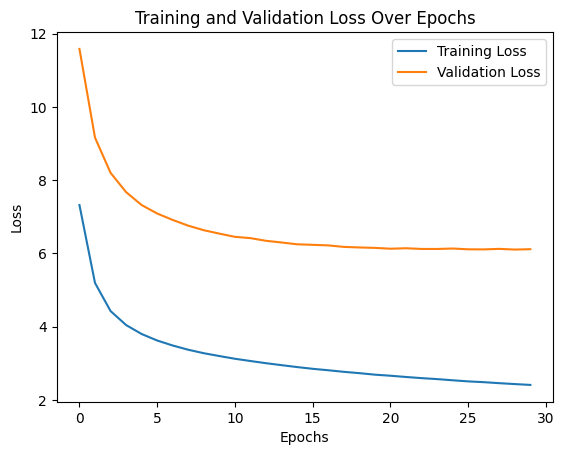

Training loss plot saved at /results/caption_model_training_plot.png
Training history saved at /results/caption_model_training_history.csv


In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint
import csv
import matplotlib.pyplot as plt

# Define checkpoint callback
checkpoint_cb = ModelCheckpoint(
    filepath=f'{tmpx}imgcap_{mdx}', 
    save_weights_only=True, 
    save_best_only=True,
    verbose=1
)

try:
    # Fit the model
    # Train the model and capture the history
    history = caption_model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=valid_dataset,
        callbacks=[early_stopping, checkpoint_cb],
    )

    # Save training history as a CSV
    csv_path = "/results/caption_model_training_history.csv"
    history_data = history.history
    with open(csv_path, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow(["epoch"] + list(history_data.keys()))
        # Write data
        for i in range(len(history_data["loss"])):
            writer.writerow([i + 1] + [history_data[key][i] for key in history_data.keys()])

    # Save and show the loss curves as a plot
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.title("Training and Validation Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plot_path = "/results/caption_model_training_plot.png"
    plt.savefig(plot_path)
    plt.show()
    plt.close()
    print(f"Training loss plot saved at {plot_path}")
    
    print(f"Training history saved at {csv_path}")
except ValueError as e:
    print(f"ValueError during model fitting: {e}")

Test image path.

In [29]:
# Main loop to process test images
dataset_directory = "/data/test/rxxch9vw59-2/"
test_image_filenames = os.listdir(dataset_directory+"images")

# Random Image Selection and Controlled Display

Generates a caption for a random image among test images.

In [30]:
random_image = np.random.choice(test_image_filenames)

Show Random Image and Caption Without Saving

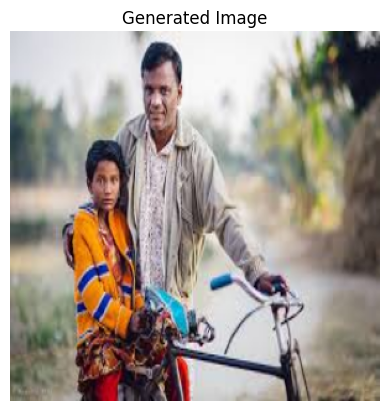

Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

'একজন পুরুষ বসে আছে।'

In [31]:
# Generate and display the caption for the selected random image
# print(f"Generating caption for randomly selected image: {random_image}")
# caption = generate_caption(dataset_directory, random_image)

generate_caption(dataset_directory,'1228.png')

Display Only a Few Images Without Saving

In [32]:
# for idx, image_filename in enumerate(test_image_filenames[:5]):  # Process first 5 images
#     generate_caption(dataset_directory, image_filename, display_count=5)

# Generate captions for multiple random images

In [33]:
# # Generate captions for 5 random test images
# num_random_images = 5

# for i in range(num_random_images):
#     random_image = np.random.choice(test_image_filenames)
#     print(f"\nGenerating caption for image {i + 1}: {random_image}")
#     caption = generate_caption(dataset_directory, random_image)
#     # print(f"Generated Caption: {caption}")


Generate captions for all test images.

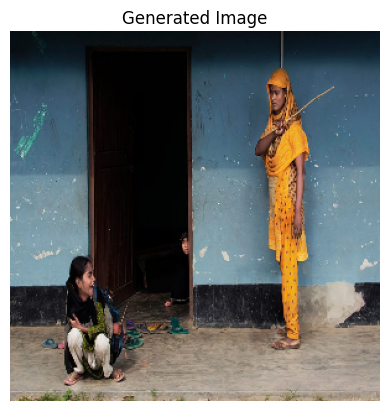

Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

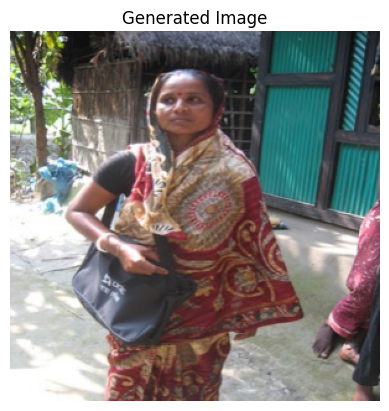

Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

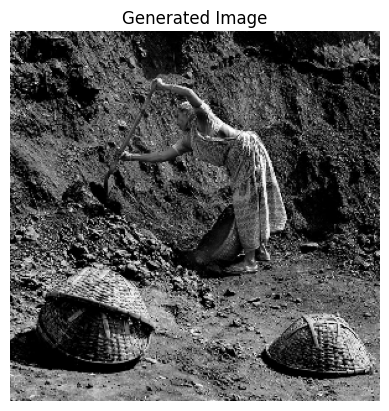

Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

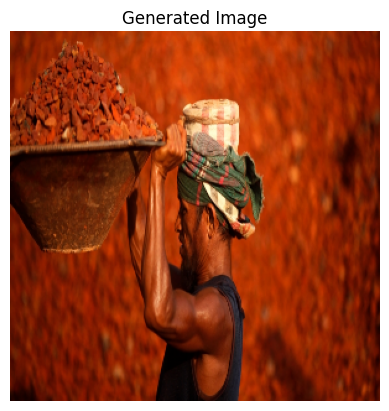

Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:18:33.783353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:18:34.247436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:18:44.758211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  সরিষা ক্ষেতের মাঝ দিয়ে একজন পুরুষ হেঁটে
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shap

2024-12-21 14:18:47.111538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:18:49.390678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:18:54.449128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_

2024-12-21 14:18:56.612662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:18:57.922887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float

2024-12-21 14:19:02.530653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:19:09.494224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  কয়েকজন ছেলে একসাথে দাড়িয়ে আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after Layer

2024-12-21 14:19:16.965987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:19:19.355796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:19:19.826499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:19:20.799248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:19:23.006445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:19:24.381410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:19:36.190663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_

2024-12-21 14:19:39.250896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:19:41.456708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:19:46.196693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 25

2024-12-21 14:19:47.925462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:19:50.631933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:19:54.604057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
em

2024-12-21 14:20:01.140241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:20:04.700034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:20:05.179991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:20:06.104490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 25

2024-12-21 14:20:09.188698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:20:15.699352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:20:18.819209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একটি রিক্সা ও অনেকগুলো মানুষ আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1,

2024-12-21 14:20:21.419669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।


2024-12-21 14:20:21.845623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:20:25.745569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:20:28.360649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:20:32.859352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  কয়েকজন পুরুষ দাড়িয়ে আছে।


2024-12-21 14:20:33.328859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:20:37.382708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:20:37.907831: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:20:55.965373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  কয়েকজন নারী ও পুরুষ আছে। শিশু
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 

2024-12-21 14:21:05.985660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ বসে আছে।


2024-12-21 14:21:06.429804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:21:07.334010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একটি শিশু আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encode

2024-12-21 14:21:12.967229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:21:13.884837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:21:18.070864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন নারী ও একজন পুরুষ আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1

2024-12-21 14:21:28.055400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:21:38.616841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:21:39.619104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:21:40.623020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:21:42.821184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ বসে আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
E

2024-12-21 14:21:45.191056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:21:47.417752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:21:49.751961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:21:56.215226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:21:57.582380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:22:07.163533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:22:10.470190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:22:21.673653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:22:30.658790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:22:31.155046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:22:42.593385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:22:55.973727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:22:58.706679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:23:00.524832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:23:05.983572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:23:06.447452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:23:09.682966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  অনেকগুলো মানুষ আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
E

2024-12-21 14:23:13.858470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ ও একজন নারী আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1

2024-12-21 14:23:19.194616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  কয়েকজন মানুষ আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedde

2024-12-21 14:23:20.118525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  কয়েকজন পুরুষ আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedde

2024-12-21 14:23:24.275235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:23:28.313761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:23:33.954609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:23:37.606285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একটি নৌকায় একজন মানুষ আছে। মানুষ


2024-12-21 14:23:38.072566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:23:39.031374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encod

2024-12-21 14:23:50.765740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  অনেকগুলো ভবন দেখা যাচ্ছে। ভবন ভবন
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1,

2024-12-21 14:23:52.075143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:23:52.510154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  কয়েকজন ছেলে একসাথে দাড়িয়ে আছে। অনেকগুলো
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shap

2024-12-21 14:23:55.197036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ বসে আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embed

2024-12-21 14:23:56.919262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন মানুষ আছে।


2024-12-21 14:23:57.347986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:23:59.997920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:24:00.883288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:24:01.778911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:24:17.194196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:24:21.872250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:24:25.145232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:24:30.505680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encod

2024-12-21 14:24:37.939141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:24:43.867376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ আছে।


2024-12-21 14:24:44.316502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:24:47.337391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:25:03.103727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:25:05.424352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:25:06.798417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ ও একজন নারী দাড়িয়ে আছে।


2024-12-21 14:25:07.295941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:25:08.388310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:25:10.208437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ বসে আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1

2024-12-21 14:25:17.062213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  রাস্তা দিয়ে কয়েকজন মানুষ হেঁটে যাচ্ছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape

2024-12-21 14:25:18.827061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:25:27.211542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_

2024-12-21 14:25:40.617819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float

2024-12-21 14:25:43.684132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:25:47.948447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একটি শিশু আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_t

2024-12-21 14:25:57.295265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:25:59.489637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:26:07.355493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ বসে আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
E

2024-12-21 14:26:09.574328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:26:11.828284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:26:21.716154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ দাড়িয়ে আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
em

2024-12-21 14:26:34.191825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন পুরুষ সাইকেল চালিয়ে আসছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7,

2024-12-21 14:26:57.047633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  কয়েকজন নারী ও পুরুষ আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)


2024-12-21 14:26:58.888103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:27:04.399428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  অনেকগুলো মানুষ আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embed

2024-12-21 14:27:11.583229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>

Predicted Caption:  একজন মানুষ আছে।
Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_

2024-12-21 14:27:16.080886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:27:34.382739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:27:42.571761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:27:46.083814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:27:47.807034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:28:16.075967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:28:22.353292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:28:30.023569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:28:31.520147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:28:32.428316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

2024-12-21 14:29:08.526347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


Encoder Input Shape: (1, 1, 256)
Encoder Input Shape before LayerNorm: (1, 1, 256)
Encoder Input Shape after LayerNorm: (1, 1, 256)
Encoder Output Shape: (1, 1, 256)
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embedded_positions dtype: <dtype: 'float32'>
Positional Embedding Input Shape: (1, 7)
Positional Embedding Output Shape: (1, 7, 256)
embedded_tokens dtype: <dtype: 'float32'>
embe

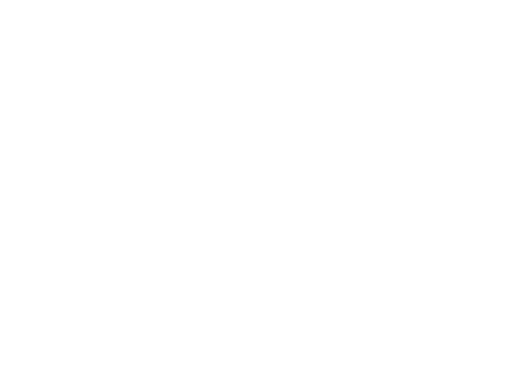

In [34]:
for idx, image_filename in enumerate(test_image_filenames):
    generate_caption(dataset_directory, image_filename, save_dir=output_dir, save_idx=f"test_{idx+1}", display_count=5)

In [35]:
# Finalize and save HTML report only if images and captions were added
if "<div>" in html_content or saved_image_count > 0:  # Check if any image-caption pair was added
    html_content += "</body></html>"
    with open(html_report_path, "w", encoding="utf-8") as f:
        f.write(html_content)
    print(f"HTML report saved at: {html_report_path}")
else:
    print("No images or captions were saved. HTML report was not created.")

HTML report saved at: /results/generated_captions_report.html


Save the weights of the trained model.

In [36]:
# After training the model, save the weights
caption_model.save_weights(f'{tmpx}imgcap_{mdx}', save_format='tf')

Dump the vectorised vocabulary.

In [37]:
# Define the directory path
directory = f'/results/Vocab/{mdx}'

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Save the vocabulary using pickle
with open(f'{directory}/vocab_{mdx}', 'wb') as f:
    pickle.dump(vocab, f)